# 🦠 Emergent Molecular Communication

A preliminary study of emergent molecular communication protocols learned by graph-based agents in a diffusion channel environment.

## Table of Contents
- [Imports](#introduction)
- [Utils](#utils)
  - [Data](#data)
  - [Neural Networks](#neural-networks)
  - [Communication Model](#communication-model)
  - [Train the Communication Model](#train-the-communication-model)
- [Running the Experiments](#running-the-experiments)
  - [Experiments on Ideal and Diffusion Channel](#experiments-on-ideal-and-diffusion-channel)
  - [Experiments on Pure Relay Nodes](#experiments-on-pure-relay-nodes)
- [Collect and Visualize Results](#collect-and-visualize-results)

## Imports

In [2]:
import os
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F  # Ensure F is imported for cross_entropy, mse_loss, softmax
from typing import Optional, Tuple, Union, Dict, List, Any

import warnings
from copy import deepcopy
import logging
from logging import getLogger
import math
import random
from random import shuffle
from itertools import product
from datetime import datetime
import glob
from functools import cache
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy.special import erfc

try:
    from ucimlrepo import fetch_ucirepo
except ImportError:
    warnings.warn(
        "ucimlrepo not found. Please install it using 'pip install ucimlrepo' "
        "if you intend to use the dataset fetching functionality."
    )
    fetch_ucirepo = None

import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import ray
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback

# --- Setup (only once) ---
# Initialize Ray for potential parallel processing; ignore_reinit_error is useful for notebooks
ray.init(ignore_reinit_error=True, include_dashboard=False, local_mode=True)
sns.set_style("whitegrid")

# Configure logging to show INFO messages to the console
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = getLogger(__name__)

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

2025-06-15 22:07:00,624	INFO worker.py:1852 -- Started a local Ray instance.


## Utils

### Data

In [3]:
def generate_graph(
    n_nodes: int, density: float, random_state: Optional[int] = None
) -> np.ndarray:
    """
    Generate random (x, y) positions for nodes in a graph.

    The nodes are uniformly distributed in a square region.
    The side length of the square is computed based on the given density,
    so that the area of the square is n_nodes/density.

    Parameters:
        n_nodes (int): Number of nodes.
        density (float): Average number of nodes per unit square.
        random_state (int): Seed for the random number generator.

    Returns:
        np.ndarray: An array of shape (n_nodes, 2) with the (x, y) positions.
    """
    # Initialize the random number generator with the provided seed.
    if random_state is not None:
        rng = np.random.default_rng(random_state)

    # Compute the side length of the square domain.
    side_length = np.sqrt(n_nodes / density)

    # Generate positions uniformly in the square [0, side_length] x [0, side_length].
    positions = rng.uniform(low=0, high=side_length, size=(n_nodes, 2))

    return positions


def get_sender_receiver(graph: np.ndarray) -> tuple[int, int]:
    """
    Return the index of the sender and receiver nodes. The sender and the receiver are the nodes
    that are furthest apart in the graph.

    Parameters:
        graph (np.ndarray): An array of shape (n_nodes, 2) with the (x, y) positions of the nodes.

    Returns:
        Tuple[int, int]: The indices of the sender and receiver nodes.
    """
    # Compute the pairwise distances between all nodes.
    distances = np.linalg.norm(graph[:, None] - graph, axis=-1)

    # Find the indices of the sender and receiver nodes.
    sender, receiver = np.unravel_index(np.argmax(distances), distances.shape)

    return sender.item(), receiver.item()


def get_distance_matrix(graph: np.ndarray) -> np.ndarray:
    """
    Compute the pairwise distance matrix between all nodes in the graph.

    Parameters:
        graph (np.ndarray): An array of shape (n_nodes, 2) with the (x, y) positions of the nodes.

    Returns:
        np.ndarray: A distance matrix of shape (n_nodes, n_nodes) where the entry (i, j) is the
            Euclidean distance between nodes i and j.
    """
    # Compute the pairwise distances between all nodes.
    distances = np.linalg.norm(graph[:, None] - graph, axis=-1)

    return distances


def plot_graph(graph: np.ndarray, ax=None):
    """
    Plot the graph with nodes and edges.

    Parameters:
        graph (np.ndarray): An array of shape (n_nodes, 2) with the (x, y) positions of the nodes.
        ax (plt.Axes): The axes where to plot the graph.
    """
    if ax is None:
        _, ax = plt.subplots()

    # Plot the nodes.
    ax.plot(graph[:, 0], graph[:, 1], "o", label="Nodes")
    for i, (x, y) in enumerate(graph):
        ax.text(x, y, f"{i}", ha="center", va="bottom")

    # Plot the sender and the receiver nodes with a different color.
    sender, receiver = get_sender_receiver(graph)
    ax.plot(graph[sender, 0], graph[sender, 1], "o", color="green", label="Sender")
    ax.plot(graph[receiver, 0], graph[receiver, 1], "o", color="red", label="Receiver")

    ax.set_aspect("equal", "box")
    ax.grid(True)
    ax.legend()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Graph")

In [4]:
DATASETS = [
    "iris",
    "wine",
    "breast_cancer",
]

def get_classification_data(
    dataset_name: str,
    test_size: float = 0.2,
    val_size: float = 0.1,
    random_state: int = 42,
):
    """
    Load a dataset from OpenML (UCI repository) and preprocess it:
    - Detect numerical and categorical features
    - Impute missing values
    - One-hot encode categorical features
    - Standardize all features
    - Encode target labels
    - Split into train/validation/test sets

    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test as numpy arrays
    """
    # Check if the dataset is in the list of available datasets
    if dataset_name not in DATASETS:
        raise ValueError(
            f"Dataset {dataset_name} is not available. Please choose from {DATASETS}."
        )

    # Check if the dataset file exists
    dataset_path = os.path.join("..", "data", f"{dataset_name}.npz")
    if os.path.exists(dataset_path):
        with np.load(dataset_path, allow_pickle=False) as data:
            X_train = data["X_train"]
            X_val = data["X_val"]
            X_test = data["X_test"]
            y_train = data["y_train"]
            y_val = data["y_val"]
            y_test = data["y_test"]
        return X_train, X_val, X_test, y_train, y_val, y_test

    # fetch dataset
    ids = {
        "iris": 53,
        "wine": 109,
        "breast_cancer": 17,
    }
    if dataset_name not in DATASETS:
        raise ValueError(
            f"Dataset {dataset_name} is not available. Please choose from {DATASETS}."
        )

    ds = fetch_ucirepo(id=ids[dataset_name])
    X = ds.data.features
    y = ds.data.targets

    # Identify feature types
    numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_features = [col for col in X.columns if col not in numeric_features]

    # Pipelines for numerical and categorical features
    numeric_pipeline = Pipeline(
        [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
    )
    categorical_pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocessor = ColumnTransformer(
        [
            ("num", numeric_pipeline, numeric_features),
            ("cat", categorical_pipeline, categorical_features),
        ]
    )

    # Encode target labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )
    # Adjust validation size relative to the remaining data
    val_relative_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=val_relative_size,
        random_state=random_state,
        stratify=y_temp,
    )

    # Fit the preprocessor on the training data and transform all sets
    if dataset_name in ids:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X_train_processed = preprocessor.fit_transform(X_train)
            X_val_processed = preprocessor.transform(X_val)
            X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed = X_train
        X_val_processed = X_val
        X_test_processed = X_test

    # Save the dataset as a numpy array
    os.makedirs(os.path.join("..", "data"), exist_ok=True)
    np.savez_compressed(
        os.path.join("..", "data", f"{dataset_name}.npz"),
        X_train=X_train_processed,
        X_val=X_val_processed,
        X_test=X_test_processed,
        y_train=y_train,
        y_val=y_val,
        y_test=y_test,
        allow_pickle=False,
    )

    return X_train_processed, X_val_processed, X_test_processed, y_train, y_val, y_test


data_stats_dict = {
    "name": [],
    "n_samples": [],
    "n_features": [],
    "n_classes": [],
}
for dataset in DATASETS:
    X_train, X_val, X_test, y_train, y_val, y_test = get_classification_data(dataset)
    data_stats_dict["name"].append(dataset)
    data_stats_dict["n_samples"].append(
        X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
    )
    data_stats_dict["n_features"].append(X_train.shape[1])
    data_stats_dict["n_classes"].append(len(np.unique(y_train)))
data_stats_df = pd.DataFrame(data_stats_dict)
data_stats_df

name  n_samples  n_features  n_classes
0           iris        150           4          3
1           wine        178          13          3
2  breast_cancer        569          30          2

### Neural Networks

In [5]:
class FeedForwardNeuralNetwork(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_dims: list = [4],
        dropout_rate: float = 0.0,
        use_batchnorm: bool = False,
    ):
        """
        Feedforward Neural Network with ReLU activations and Dropout.

        Parameters:
            in_features (int): Dimensionality of the input features.
            out_features (int): Dimensionality of the output features.
            hidden_dims (list): List with the number of neurons for each hidden layer.
            dropout_rate (float): Dropout probability.
            use_batchnorm (bool): Whether to use Batch Normalization.
            residual_coefficient (float): Coefficient for the residual connection.
            output_coefficient (float): Coefficient for the output layer.
        """
        super().__init__()
        layers = []
        prev_dim = in_features
        # Build hidden layers
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, out_features))
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.network(x)

In [6]:
def train_encoder_decoder(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    n_features,
    n_classes,
    hidden_dims,
    use_batchnorm,
    lr=1e-3,
    n_epochs=50,
    patience=5,
    lr_drop_after=0.5,
    warmup_epochs=10,
    l1_lambda=0.01,
    batch_size=256,
    device="cpu",
    weights_dir="enc_dec_weights",
    verbose=False,
):
    os.makedirs(weights_dir, exist_ok=True)
    torch.manual_seed(42)
    np.random.seed(42)

    # Build the two networks
    n_chem = n_classes
    encoder = FeedForwardNeuralNetwork(
        in_features=n_features,
        out_features=n_chem,
        hidden_dims=hidden_dims,
        use_batchnorm=use_batchnorm,
    ).to(device)
    decoder = FeedForwardNeuralNetwork(
        in_features=n_chem,
        out_features=n_classes,
        hidden_dims=hidden_dims,
        use_batchnorm=use_batchnorm,
    ).to(device)

    # Joint optimizer & loss
    optimizer = optim.Adam(
        list(encoder.parameters()) + list(decoder.parameters()), lr=lr
    )
    criterion = nn.CrossEntropyLoss()

    # DataLoaders
    train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long), # <--- Add dtype=torch.long
)
    val_ds = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.long),   # <--- Add dtype=torch.long
)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    best_acc = 0.0
    best_enc = deepcopy(encoder.state_dict())
    best_dec = deepcopy(decoder.state_dict())
    no_imp = 0

    for epoch in range(1, n_epochs + 1):
        # — train epoch —
        encoder.train()
        decoder.train()
        running = total = 0.0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            chem = encoder(Xb)
            logits = decoder(chem)
            loss = criterion(logits, yb)

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in encoder.parameters()) + sum(
                p.abs().sum() for p in decoder.parameters()
            )
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            running += loss.item() * Xb.size(0)
            total += Xb.size(0)

        # — validation epoch —
        encoder.eval()
        decoder.eval()
        vrun = vtot = 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                vchem = encoder(Xb)
                vlogits = decoder(vchem)
                vrun += criterion(vlogits, yb).item() * Xb.size(0)
                vtot += Xb.size(0)

        train_loss = running / total
        val_loss = vrun / vtot
        val_acc = (vlogits.argmax(dim=1) == yb).float().mean().item()
        if verbose:
            logger.info(
                f"[EncDec] Epoch {epoch}: train={train_loss:.4f} val={val_loss:.4f} acc={val_acc:.4f}"
            )

        # early stop
        if val_acc > best_acc:
            best_acc = val_acc
            best_enc = deepcopy(encoder.state_dict())
            best_dec = deepcopy(decoder.state_dict())
            no_imp = 0
        else:
            no_imp += 1
            if no_imp >= patience and epoch > warmup_epochs:
                if verbose:
                    logger.warning("Encoder-decoder pretraining stopped early.")
                break

        # learning rate drop
        drop_epoch = math.ceil(n_epochs * lr_drop_after)
        if epoch > warmup_epochs and epoch == drop_epoch:
            for g in optimizer.param_groups:
                g["lr"] = lr / 10
            if verbose:
                logger.info(f"Learning rate dropped to {lr / 10:.1e} at epoch {epoch}.")

    # save best
    encoder.load_state_dict(best_enc)
    decoder.load_state_dict(best_dec)
    enc_path = os.path.join(weights_dir, f"{dataset_name}_encoder_weights.pth")
    dec_path = os.path.join(weights_dir, f"{dataset_name}_decoder_weights.pth")
    torch.save(encoder.state_dict(), enc_path)
    torch.save(decoder.state_dict(), dec_path)
    if verbose:
        logger.debug(f"Saved encoder → {enc_path}")
        logger.debug(f"Saved decoder → {dec_path}")

    # test
    encoder.eval()
    decoder.eval()
    correct, total = 0.0, 0.0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            tchem = encoder(Xb)
            tlogits = decoder(tchem)
            correct += (tlogits.argmax(dim=1) == yb).float().sum().item()
            total += Xb.size(0)
    test_acc = correct / total
    return enc_path, dec_path, test_acc


os.makedirs("enc_dec_weights", exist_ok=True)
res_csv_path = os.path.join("enc_dec_weights", "enc_dec_results.csv")
if os.path.exists(res_csv_path):
    df = pd.read_csv(res_csv_path)
else:
    df = pd.DataFrame(columns=["dataset", "n_features", "n_classes", "acc"])
    df.to_csv(res_csv_path, index=False)

for dataset_name in DATASETS:
    if dataset_name in ["identity", "shift", "negate"]:
        continue
    enc_path = os.path.join("enc_dec_weights", f"{dataset_name}_encoder_weights.pth")
    dec_path = os.path.join("enc_dec_weights", f"{dataset_name}_decoder_weights.pth")
    if not os.path.exists(enc_path) or not os.path.exists(dec_path):
        X_train, X_val, X_test, y_train, y_val, y_test = get_classification_data(
            dataset_name
        )
        n_features = X_train.shape[1]
        n_classes = len(np.unique(y_train))
        _, _, acc = train_encoder_decoder(
            X_train,
            y_train,
            X_val,
            y_val,
            X_test,
            y_test,
            n_features,
            n_classes,
            hidden_dims=[],
            use_batchnorm=False,
            lr=1e-3,
            n_epochs=10000,
            patience=100,
            batch_size=1024,
            device="cpu",
            weights_dir="enc_dec_weights",
        )
        logger.info(f"Trained encoder-decoder on {dataset_name}. Acc: {acc:.4f}")
        df = pd.read_csv(res_csv_path)
        new_row = pd.DataFrame(
            {
                "dataset": [dataset_name],
                "n_features": [n_features],
                "n_classes": [n_classes],
                "acc": [acc],
            }
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv(res_csv_path, index=False)
    else:
        logger.info(f"Encoder-decoder weights already exist for {dataset_name}.")

2025-06-15 22:07:05,165 - INFO - Encoder-decoder weights already exist for iris.
2025-06-15 22:07:05,166 - INFO - Encoder-decoder weights already exist for wine.
2025-06-15 22:07:05,167 - INFO - Encoder-decoder weights already exist for breast_cancer.


### Communication Model

In [7]:
def message_passing(
    message: torch.Tensor,
    distance: torch.Tensor,
    phi: nn.ModuleList,
    residual_coefficient: float = 0.0,
    output_coefficient: float = 1.0,
    use_diffusion_noise: bool = True,
    memory: bool = False,
) -> torch.Tensor:
    """
    Perform one message passing iteration, optionally incorporating memory.

    Parameters:
        message: Tensor of shape (B, n, d)  -- messages at current iteration
        distance: Tensor of shape (n, n)     -- distance matrix between nodes
        phi:     ModuleList of n mappings   -- each maps R^{d or 2d} -> R^d
        residual_coefficient: float         -- coefficient for residual connection
        output_coefficient: float          -- coefficient for output layer
        use_diffusion_noise: bool          -- whether to add diffusion noise
        memory:  bool                        -- whether to concatenate previous message

    Returns:
        new_message: Tensor of shape (B, n, d) -- updated messages
    """
    B, N, D = message.shape

    # Save previous messages if memory is on
    prev_msg = message.clone() if memory else None

    # Compute detection probabilities
    p = torch.erfc(distance / 2.0)  # (n, n)
    p_exp = p.unsqueeze(0).unsqueeze(-1).expand(B, N, N, D)  # (B,n,n,d)

    # Channel noise
    if use_diffusion_noise:
        eps = torch.randn(B, N, N, D, device=message.device)
        Delta = (p_exp * (1 + eps - eps * p_exp)).clip(min=0)  # (B,n,n,d)
    else:
        Delta = torch.ones_like(p_exp, device=message.device)

    # Compute aggregated messages
    aggregated = torch.einsum("bijk,bjk->bik", Delta, message)  # (B,n,d)

    # Compute new messages per node
    new_message = torch.zeros_like(message, device=message.device)
    for i in range(N):
        if memory:
            # concat along feature dim: [aggregated, previous]
            inp = torch.cat([aggregated[:, i, :], prev_msg[:, i, :]], dim=-1)
        else:
            inp = aggregated[:, i, :]
        new_message[:, i, :] = phi[i](inp)

    # Apply residual connection
    new_message = residual_coefficient * message + output_coefficient * new_message
    return new_message


class MolComNetwork(nn.Module):
    def __init__(
        self,
        graph: np.ndarray,
        n_features: int,
        n_classes: int,
        encoder: torch.nn.Module = None,
        n_iters: int = 1,
        hidden_dims: list = [4],
        dropout_rate: float = 0.0,
        use_batchnorm: bool = False,
        residual_coefficient: float = 0.0,
        output_coefficient: float = 1.0,
        use_diffusion_noise: bool = True,
        memory: bool = False,
        freeze_encoders: bool = False,
    ):
        super().__init__()
        self.n_features = n_features
        self.graph = graph
        self.graph_size = len(graph)
        self.distances = torch.tensor(get_distance_matrix(graph), dtype=torch.float32)
        self.sender, self.receiver = get_sender_receiver(graph)
        self.n_iters = n_iters
        self.residual_coefficient = residual_coefficient
        self.output_coefficient = output_coefficient
        self.n_classes = n_classes
        self.use_diffusion_noise = use_diffusion_noise
        self.memory = memory

        # Encoder unchanged
        self.encoder = encoder
        if freeze_encoders and encoder is not None:
            for param in self.encoder.parameters():
                param.requires_grad = False

        # φ‐networks: double in_features if memory=True
        phi_in = 2 * n_classes if memory else n_classes
        self.phi = nn.ModuleList(
            [
                FeedForwardNeuralNetwork(
                    in_features=phi_in,
                    out_features=n_classes,
                    hidden_dims=hidden_dims,
                    dropout_rate=dropout_rate,
                    use_batchnorm=use_batchnorm,
                )
                for _ in range(self.graph_size)
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        self.distances = self.distances.to(x.device)
        assert (
            x.shape[1] == self.n_features
        ), f"Expected {self.n_features} features, got {x.shape[1]}"

        # Initialize messages: only sender nodes get the encoded signal
        msg = torch.zeros(B, self.graph_size, self.n_classes, device=x.device)
        msg[:, self.sender, :] = self.encoder(x) if self.encoder is not None else x
        msg = torch.relu(msg)
        out = torch.zeros(B, self.n_classes, self.n_iters, device=x.device)

        # Iterative message passing
        for i in range(self.n_iters):
            msg = message_passing(
                msg,
                self.distances,
                self.phi,
                residual_coefficient=self.residual_coefficient,
                output_coefficient=self.output_coefficient,
                memory=self.memory,
                use_diffusion_noise=self.use_diffusion_noise,
            )
            msg = torch.relu(msg)
            # Save the output of the last iteration
            out[:, :, i] = msg[:, self.receiver, :]

        return out

### Train the Communication Model

In [8]:
def compute_iter_metrics(
    outputs: torch.Tensor, targets: torch.Tensor, k: int
) -> dict[str, float | list[float]]:
    """
    Returns a dict with:
      - acc_last       float
      - acc_avg        float
      - mean_first     float
      - conv_rate      float
      - stability      float
      - acc_per_iter   list[float]
    """
    B, C, T = outputs.shape

    preds = outputs.argmax(dim=1)  # (B, T)
    correct = preds.eq(targets.unsqueeze(1))  # (B, T)
    acc_per_iter = correct.float().mean(dim=0).tolist()

    acc_last = acc_per_iter[-1]

    probs = F.softmax(outputs, dim=1)  # (B, C, T)
    acc_avg = (probs.mean(dim=2).argmax(dim=1) == targets).float().mean().item()

    idx = torch.arange(T, device=outputs.device).unsqueeze(0).expand(B, T)
    first_idx = torch.where(correct, idx, torch.full_like(idx, T)).min(dim=1)[0] + 1
    valid = first_idx <= T
    mean_first = first_idx[valid].float().mean().item() if valid.any() else float("nan")

    k_clamped = max(1, min(k, T))
    stable = (preds[:, k_clamped - 1].unsqueeze(1) == preds[:, k_clamped - 1 :]).all(
        dim=1
    )
    conv_rate = stable.float().mean().item()

    flips = (preds[:, 1:] != preds[:, :-1]).float().sum(dim=1)
    stability = 1 - (flips / (T - 1)).mean().item()

    return {
        "acc_last": acc_last,
        "acc_avg": acc_avg,
        "mean_first": mean_first,
        "conv_rate": conv_rate,
        "stability": stability,
        "acc_per_iter": acc_per_iter,
    }


def train_one_epoch(model, loader, optimizer, criterion, device, k):
    model.train()
    meters = {
        "loss": 0.0,
        "acc_last": 0.0,
        "acc_avg": 0.0,
        "mean_first": 0.0,
        "conv_rate": 0.0,
        "stability": 0.0,
        "acc_per_iter": None,  # will become list
        "count": 0,
    }

    for X, y in loader:
        B = X.size(0)
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        out = model(X)  # (B, C, T)
        T = out.size(2)

        loss = sum(criterion(out[:, :, t], y) for t in range(T)) / T
        loss.backward()
        optimizer.step()

        metrics = compute_iter_metrics(out, y, k)

        meters["loss"] += loss.item() * B
        meters["acc_last"] += metrics["acc_last"] * B
        meters["acc_avg"] += metrics["acc_avg"] * B
        meters["mean_first"] += metrics["mean_first"] * B
        meters["conv_rate"] += metrics["conv_rate"] * B
        meters["stability"] += metrics["stability"] * B

        if meters["acc_per_iter"] is None:
            meters["acc_per_iter"] = torch.zeros(T, dtype=torch.float64)
        meters["acc_per_iter"] += (
            torch.tensor(metrics["acc_per_iter"], dtype=torch.float64) * B
        )

        meters["count"] += B

    # normalize
    N = meters["count"]
    epoch = {
        k: (v / N if k != "acc_per_iter" else (meters["acc_per_iter"] / N).tolist())
        for k, v in meters.items()
        if k != "count"
    }
    return epoch


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device, k):
    model.eval()
    meters = {
        "loss": 0.0,
        "acc_last": 0.0,
        "acc_avg": 0.0,
        "mean_first": 0.0,
        "conv_rate": 0.0,
        "stability": 0.0,
        "acc_per_iter": None,
        "count": 0,
    }

    for X, y in loader:
        B = X.size(0)
        X, y = X.to(device), y.to(device)

        out = model(X)
        T = out.size(2)
        loss = sum(criterion(out[:, :, t], y) for t in range(T)) / T

        metrics = compute_iter_metrics(out, y, k)

        meters["loss"] += loss.item() * B
        meters["acc_last"] += metrics["acc_last"] * B
        meters["acc_avg"] += metrics["acc_avg"] * B
        meters["mean_first"] += metrics["mean_first"] * B
        meters["conv_rate"] += metrics["conv_rate"] * B
        meters["stability"] += metrics["stability"] * B

        if meters["acc_per_iter"] is None:
            meters["acc_per_iter"] = torch.zeros(T, dtype=torch.float64)
        meters["acc_per_iter"] += (
            torch.tensor(metrics["acc_per_iter"], dtype=torch.float64) * B
        )

        meters["count"] += B

    N = meters["count"]
    epoch = {
        k: (v / N if k != "acc_per_iter" else (meters["acc_per_iter"] / N).tolist())
        for k, v in meters.items()
        if k != "count"
    }
    return epoch


def train_model(
    model: nn.Module,
    train_loader,
    val_loader,
    test_loader,
    n_epochs: int = 100,
    patience: int = 10,
    warmup_epochs: int = 25,
    lr_drop_after: float = 0.5,
    lr: float = 1e-3,
    device: str = "cpu",
    verbose: bool = True,
):
    warmup_epochs = min(warmup_epochs, n_epochs)
    lr_drop_epoch = math.ceil(n_epochs * lr_drop_after)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        device = torch.device(device)
        model.to(device)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        best_val_loss = float("inf")
        best_state = deepcopy(model.state_dict())
        no_improve = 0

        # Initialize history
        history: dict[str, dict[str, list]] = {
            "train": {
                k: []
                for k in [
                    "loss",
                    "acc_last",
                    "acc_avg",
                    "mean_first",
                    "conv_rate",
                    "stability",
                    "acc_per_iter",
                ]
            },
            "val": {
                k: []
                for k in [
                    "loss",
                    "acc_last",
                    "acc_avg",
                    "mean_first",
                    "conv_rate",
                    "stability",
                    "acc_per_iter",
                ]
            },
        }

        k = int(math.sqrt(model.graph_size))

        for epoch in range(1, n_epochs + 1):
            train_metrics = train_one_epoch(
                model, train_loader, optimizer, criterion, device, k
            )
            val_metrics = eval_one_epoch(model, val_loader, criterion, device, k)

            # Log and store
            for phase, metrics in [("train", train_metrics), ("val", val_metrics)]:
                for name, val in metrics.items():
                    history[phase][name].append(val)
                # Logging with loguru
            if verbose:
                logger.info(
                    f"Epoch {epoch:03} | "
                    f"Train L={train_metrics['loss']:.4f}, last@={train_metrics['acc_last']:.3f}, "
                    f"avg@={train_metrics['acc_avg']:.3f}, conv@k={train_metrics['conv_rate']:.3f}, "
                    f"stab={train_metrics['stability']:.3f}, "
                    f"mean_first={train_metrics['mean_first']:.3f} | "
                    f"Val   L={val_metrics['loss']:.4f}, last@={val_metrics['acc_last']:.3f}, "
                    f"avg@={val_metrics['acc_avg']:.3f}, conv@k={val_metrics['conv_rate']:.3f}, "
                    f"stab={val_metrics['stability']:.3f}, "
                    f"mean_first={val_metrics['mean_first']:.3f}"
                )

            # Early stopping
            if val_metrics["loss"] < best_val_loss:
                best_val_loss = val_metrics["loss"]
                best_state = deepcopy(model.state_dict())
                no_improve = 0
                if verbose:
                    logger.debug(
                        f"Epoch {epoch}: New best val loss: {best_val_loss:.4f}"
                    )
            else:
                no_improve += 1
                if no_improve >= patience and epoch > warmup_epochs:
                    if verbose:
                        logger.info(
                            f"Early stopping at epoch {epoch} with patience {patience}."
                        )
                    break

            # Learning rate drop
            if epoch > warmup_epochs and epoch == lr_drop_epoch:
                for g in optimizer.param_groups:
                    g["lr"] = lr / 10
                if verbose:
                    logger.info(
                        f"Learning rate dropped to {lr / 10:.1e} at epoch {epoch}."
                    )

        # Restore best and test
        model.load_state_dict(best_state)
        test_metrics = eval_one_epoch(model, test_loader, criterion, device, k)
        if verbose:
            logger.info(
                f"Test L={test_metrics['loss']:.4f}, last@={test_metrics['acc_last']:.3f}, "
                f"avg@={test_metrics['acc_avg']:.3f}, conv@k={test_metrics['conv_rate']:.3f}, "
                f"stab={test_metrics['stability']:.3f}, "
                f"mean_first={test_metrics['mean_first']:.3f}"
            )

    return history, test_metrics

In [9]:
def get_dataloader(
    X: np.ndarray, y: np.ndarray, batch_size: int = 1, shuffle: bool = True
) -> DataLoader:
    """
    Create a DataLoader from the features and targets.

    Parameters:
        X (np.ndarray): Features.
        y (np.ndarray): Targets.
        batch_size (int): Batch size.
        shuffle (bool): Whether to shuffle the data.

    Returns:
        DataLoader: PyTorch DataLoader.
    """
    dataset = torch.utils.data.TensorDataset(
        torch.tensor(X, dtype=torch.float32), torch.tensor(y)
    )
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [10]:
def single_run(
    n_nodes: int = 10,
    density: float = 1,
    dataset_name: str = "iris",
    n_iters: int = 10,
    hidden_dims: list = [4],
    dropout_rate: float = 0.0,
    use_batchnorm: bool = False,
    residual_coefficient: float = 0.0,
    output_coefficient: float = 1.0,
    use_diffusion_noise: bool = True,
    memory: bool = False,
    freeze_encoders: bool = True,
    n_epochs: int = 2000,
    patience: int = -1,
    warmup_epochs: int = 500,
    lr_drop_after: float = 0.66,
    device: str = "cpu",
    results_dir: str = "results",
    random_state: int = 42,
    verbose: bool = False,
):
    np.random.seed(random_state)
    torch.manual_seed(random_state)

    os.makedirs(results_dir, exist_ok=True)

    df_dict = {
        "n_nodes": n_nodes,
        "density": density,
        "dataset_name": dataset_name,
        "n_iters": n_iters,
        "dropout_rate": dropout_rate,
        "use_batchnorm": use_batchnorm,
        "residual_coefficient": residual_coefficient,
        "output_coefficient": output_coefficient,
        "use_diffusion_noise": use_diffusion_noise,
        "memory": memory,
        "freeze_encoders": freeze_encoders,
        "n_epochs": n_epochs,
        "patience": patience,
        "warmup_epochs": warmup_epochs,
        "lr_drop_after": lr_drop_after,
        "device": device,
        "random_state": random_state,
    }
    uuid = str(abs(hash(tuple(df_dict.values()))))[:16]
    log_file_name = f"results_{uuid}.csv"
    if os.path.exists(os.path.join(results_dir, log_file_name)):
        logger.warning(
            f"Results file {log_file_name} already exists. Skipping this run."
        )
        return None, None

    # Generate the graph
    graph = generate_graph(n_nodes=n_nodes, density=density, random_state=random_state)

    # Generate the classification dataset
    X_train, X_val, X_test, y_train, y_val, y_test = get_classification_data(
        dataset_name
    )

    # Create the DataLoader instances
    batch_size = 256
    train_loader = get_dataloader(X_train, y_train, batch_size=batch_size)
    val_loader = get_dataloader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = get_dataloader(X_test, y_test, batch_size=batch_size, shuffle=False)

    encoder_weights = os.path.join(
        "enc_dec_weights", f"{dataset_name}_encoder_weights.pth"
    )
    if not os.path.exists(encoder_weights):
        raise FileNotFoundError(f"Pretrained weights not found for {dataset_name}.")
    n_classes = len(np.unique(y_train))
    encoder_model = FeedForwardNeuralNetwork(
        in_features=X_train.shape[1],
        out_features=n_classes,
        hidden_dims=[],
        dropout_rate=0.0,
        use_batchnorm=False,
    )
    encoder_model.load_state_dict(torch.load(encoder_weights))
    encoder_model.to(device)

    # Create the model
    model = MolComNetwork(
        graph,
        n_features=X_train.shape[1],
        n_classes=n_classes,
        n_iters=n_iters,
        dropout_rate=dropout_rate,
        use_batchnorm=use_batchnorm,
        hidden_dims=hidden_dims,
        residual_coefficient=residual_coefficient,
        output_coefficient=output_coefficient,
        encoder=encoder_model,
        use_diffusion_noise=use_diffusion_noise,
        memory=memory,
        freeze_encoders=freeze_encoders,
    )

    if patience is None or patience < 0:
        patience = n_epochs

    # Train the model
    train_metrics, test_metrics = train_model(
        model,
        train_loader,
        val_loader,
        test_loader,
        n_epochs=n_epochs,
        patience=patience,
        warmup_epochs=warmup_epochs,
        lr_drop_after=lr_drop_after,
        device=device,
        verbose=verbose,
    )

    # Log the results
    best_epoch = np.argmin(train_metrics["val"]["loss"])
    df_dict["best_epoch"] = best_epoch
    for key in train_metrics["train"]:
        df_dict[f"train_{key}"] = train_metrics["train"][key][best_epoch]
    for key in train_metrics["val"]:
        df_dict[f"val_{key}"] = train_metrics["val"][key][best_epoch]
    for key in test_metrics:
        df_dict[f"test_{key}"] = test_metrics[key]

    pd.DataFrame([df_dict]).to_csv(
        os.path.join(results_dir, log_file_name), index=False
    )

    return train_metrics, test_metrics

## Running the Experiments

In [11]:
# Initialize Ray for parallel processing
ray.init(ignore_reinit_error=True)


@ray.remote
def single_run_remote(**kwargs):
    return single_run(**kwargs)

2025-06-15 22:07:19,215	INFO worker.py:1684 -- Calling ray.init() again after it has already been called.


### Experiments on Ideal and Diffusion Channel

In [1]:
# Define the parameters for the set of experiments
param_lists = {
    "random_state": [42 + i for i in range(3)],
    #"n_nodes": [4, 8, 16, 32, 48, 64],
    "n_nodes": [4, 8],
    "dataset_name": ["breast_cancer", "iris", "wine"],
    "n_iters": [1, 2],
    "use_diffusion_noise": [True, False],
    "results_dir": ["results_cls"],
}

# Generate all combinations of parameters
experiment_params = list(
    dict(zip(param_lists.keys(), values)) for values in product(*param_lists.values())
)

# Shuffle the parameters
shuffle(experiment_params)
print(f"Number of experiments: {len(experiment_params)}. Time: {datetime.now()}")

# Run the experiments in parallel
results = []
for params in experiment_params:
    results.append(
        single_run_remote.remote(
            **params,
            device="cpu",
        )
    )
results = ray.get(results)

NameError: name 'product' is not defined

### Experiments on Pure Relay Nodes

In [ ]:
# Define the parameters for the set of experiments
param_lists = {
    "random_state": [42 + i for i in range(3)],
    "n_nodes": [4, 8],
    "dataset_name": ["breast_cancer", "iris", "wine"],
    "n_iters": [1, 2],
    "residual_coefficient": [1.0],
    "output_coefficient": [0.0],
    "results_dir": ["results_cls_relay"],
}

# Generate all combinations of parameters
experiment_params = list(
    dict(zip(param_lists.keys(), values)) for values in product(*param_lists.values())
)

# Shuffle the parameters
shuffle(experiment_params)
print(f"Number of experiments: {len(experiment_params)}. Time: {datetime.now()}")

# Run the experiments in parallel
results = []
for params in experiment_params:
    results.append(
        single_run_remote.remote(
            **params,
            device="cpu",
        )
    )
results = ray.get(results)

In [ ]:
ray.shutdown()

## Collect and Visualize Results

In [ ]:
def load_results(path, csv_file=None) -> pd.DataFrame:
    if type(path) != list:
        path = [path]
    dfs = []
    for p in path:
        for file in tqdm(glob.glob(os.path.join(p, "*.csv"))):
            dfs.append(pd.read_csv(file))
    if len(dfs) == 0:
        raise ValueError(f"No files found in {path}")
    results_df = pd.concat(dfs, ignore_index=True)

    # Drop rows with freeze_encoders is False
    if "freeze_encoders" in results_df.columns:
        results_df = results_df[results_df["freeze_encoders"] == True]

    # Delete columns with constant values
    results_df = results_df.loc[:, results_df.apply(pd.Series.nunique) != 1]

    # Delete columns with loss or acc different from test
    results_df = results_df.loc[:, ~results_df.columns.str.contains("train|val")]

    if csv_file is not None:
        # Save the dataframe to a CSV file
        results_df.to_csv(csv_file, index=False)
        print(f"Results saved to {csv_file}")
    return results_df


@cache
def load_baseline() -> pd.DataFrame:
    df = load_results("results_cls_relay")
    # Filter only numerical columns
    _df = df.select_dtypes(include=[np.number])
    _df["dataset_name"] = df["dataset_name"]
    # Average every numerical column grouping by dataset_name
    df = _df.groupby(["dataset_name"]).mean().reset_index()
    df.drop(
        columns=["n_nodes", "n_iters", "random_state", "test_loss", "test_acc_avg"],
        inplace=True,
    )
    df.rename(
        columns={"dataset_name": "dataset", "test_acc_last": "acc_nl"}, inplace=True
    )

    df_clf_baseline = pd.read_csv(
        os.path.join("enc_dec_weights", "enc_dec_results.csv")
    )
    # Join dataframe on dataset
    df_clf_baseline = df_clf_baseline.merge(df, on="dataset", how="right")
    return df_clf_baseline

In [31]:
df_baseline = load_baseline()
df_baseline

100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:03<00:00, 67.34it/s]


dataset  n_features  n_classes       acc    acc_nl
0  breast_cancer          30          2  0.982456  0.631579
1           iris           4          3  1.000000  0.333333
2           wine          13          3  1.000000  0.333333

In [32]:
df = load_results(["results_cls"], csv_file=os.path.join("results_cls.csv"))
df_res = df[df["use_diffusion_noise"] == True]
df_res_nn = df[df["use_diffusion_noise"] == False]

100%|████████████████████████████████████████████████████████████████████████████████| 432/432 [00:06<00:00, 69.23it/s]


Results saved to results_cls.csv


In [33]:
def plot_single_exp(ax, dataset, df, df_baseline, axes):
    subset = df[df["dataset_name"] == dataset]
    n_iter = subset["n_iters"].unique()[0]
    sns.lineplot(
        data=subset,
        x="n_nodes",
        y="test_acc_last",
        hue="n_iters",
        ax=ax,
        palette="tab10",
        marker="o",
    )

    # Look up random‐guess and encoder–decoder acc from data_df
    row = df_baseline.loc[df_baseline["dataset"] == dataset].iloc[0]
    rand_guess = 1.0 / row["n_classes"]
    enc_dec_acc = row["acc"]
    no_learning_acc = row["acc_nl"]

    # Draw dashed lines; only label them on the first subplot
    if ax is axes[0]:
        ax.axhline(enc_dec_acc, linestyle="--", color="black", label="Opt")
        ax.axhline(no_learning_acc, linestyle="--", color="gray", label="No Learning")
    else:
        ax.axhline(enc_dec_acc, linestyle="--", color="black")
        ax.axhline(no_learning_acc, linestyle="--", color="gray")

    # Formatting
    ax.get_legend().remove()
    ax.set_ylim(rand_guess - 0.01, 1.01)
    ax.set_xlim(df["n_nodes"].min(), df["n_nodes"].max())
    ax.set_ylabel("")
    ax.set_xlabel("")


def plot_results(df_res: pd.DataFrame, df_res_nn: pd.DataFrame, output_fig: str = None):
    num_datasets = len(df_res["dataset_name"].unique())

    fig, axes = plt.subplots(
        nrows=num_datasets,
        ncols=2,
        figsize=(6.3, 2 * num_datasets),
        sharex=True,
        sharey=True,
    )
    fig.tight_layout()

    for i, df in enumerate([df_res_nn, df_res]):
        for j, dataset in enumerate(sorted(df["dataset_name"].unique())):
            plot_single_exp(axes[j, i], dataset, df, df_baseline, axes)

    for j, dataset in enumerate(sorted(df_res["dataset_name"].unique())):
        axes[j, 0].set_ylabel(
            f"Test Accuracy\non {' '.join(dataset.split('_')).title()}"
        )

    for i in range(2):
        axes[-1, i].set_xlabel("Number of Nodes")

    axes[0, 0].set_title("Ideal Channel")
    axes[0, 1].set_title("Diffusion Channel")

    # Build a global legend (includes both the line‐plot handles and our dashed‐line handles)
    handles, labels = axes[-1, -1].get_legend_handles_labels()

    handles, labels = axes[-1, -1].get_legend_handles_labels()

    # Create explicit dashed‐line handles
    opt_handle = Line2D([0], [0], color="black", linestyle="--", label="Optimal")
    no_learn_handle = Line2D([0], [0], color="gray", linestyle="--", label="Relay")

    # Append them
    handles.extend([opt_handle, no_learn_handle])
    labels.extend(["Optimal", "Relay"])

    fig.legend(
        handles,
        labels,
        loc="upper right",
        bbox_to_anchor=(0.94, -0.03),
        title="Iterations",
        ncol=6,
    )
    if output_fig is not None:
        plt.savefig(output_fig, bbox_inches="tight", dpi=300)
    plt.show();

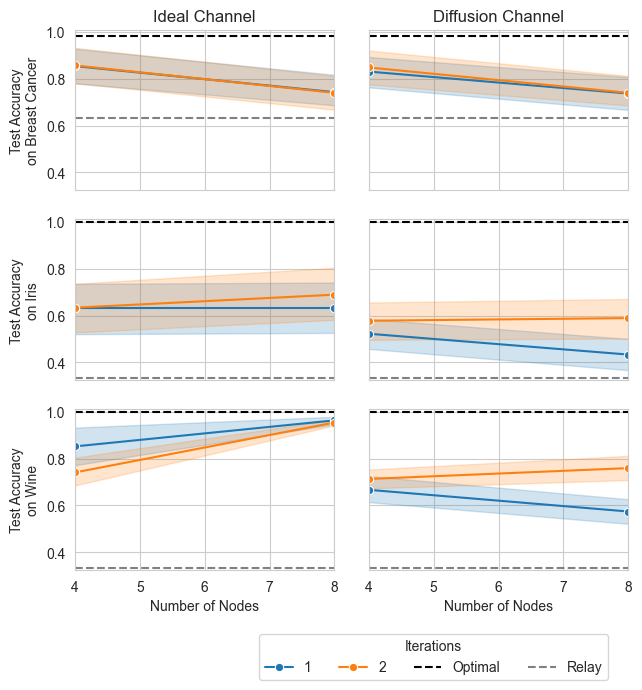

In [34]:
plot_results(df_res, df_res_nn, output_fig=os.path.join("results_cls.png"))

In [42]:
# --- RL Environment ---
class MolComEnv(gym.Env):
    """
    A custom Gym environment for Molecular Communication with node failures.
    The agent learns to ensure message delivery despite node outages.
    """
    metadata = {'render_modes': ['human'], 'render_fps': 30}

    def __init__(self, dataset_name='iris', n_nodes=10, n_iters=5):
        super().__init__()
        self.dataset_name = dataset_name
        self.n_nodes = n_nodes
        self.n_iters = n_iters
        self.current_step = 0
        self.script_dir = os.getcwd()
        self.enc_dec_weights_dir = os.path.join(self.script_dir, "enc_dec_weights")

        # Load data (for message content and classification task)
        self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test = \
            get_classification_data(dataset_name)

        n_features = self.X_train.shape[1]
        n_classes = len(np.unique(self.y_train))
        graph = generate_graph(self.n_nodes, density=0.5, random_state=42)

        # --- Load the pre-trained encoder ---
        encoder = FeedForwardNeuralNetwork(
            in_features=n_features,
            out_features=n_classes,  # Output of encoder is n_classes
            hidden_dims=[]  # Assuming encoder was trained with no hidden layers based on pretraining snippet
        )
        encoder_weights_path = os.path.join(self.enc_dec_weights_dir, f"{dataset_name}_encoder_weights.pth")
        if os.path.exists(encoder_weights_path):
            encoder.load_state_dict(torch.load(encoder_weights_path, map_location='cpu'))
            encoder.eval()  # Set to evaluation mode
            logger.info(f"Loaded pre-trained encoder for {dataset_name}.")
        else:
            logger.warning(f"Pre-trained encoder not found at {encoder_weights_path}. "
                           "MolComNetwork will attempt to run without it, which may lead to errors if feature_dim != n_classes.")
            encoder = None  # Keep encoder as None if not found

        self.molcom_network = MolComNetwork(
            graph=graph,
            n_features=n_features,
            n_classes=n_classes,
            encoder=encoder,  # Pass the loaded encoder here
            n_iters=self.n_iters,
            hidden_dims=[4],
            use_diffusion_noise=True,
            memory=True,
            freeze_encoders=True  # Freeze encoder weights during RL training
        )

        # Define action and observation spaces
        self.action_space = spaces.MultiBinary(self.n_nodes)

        self.observation_space = spaces.Dict({
            "messages": spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_nodes, n_classes), dtype=np.float32),
            "active_nodes_mask": spaces.MultiBinary(self.n_nodes)
        })

        self.active_nodes_mask = np.ones(self.n_nodes, dtype=np.int8)
        self.current_message_state = torch.zeros(1, self.n_nodes, n_classes, dtype=torch.float32)

    def _get_obs(self):
        """Helper to get current observation."""
        # Detach the tensor from the computation graph before converting to numpy
        return {
            "messages": self.current_message_state.squeeze(0).detach().numpy(),
            "active_nodes_mask": self.active_nodes_mask
        }

    def _get_info(self):
        """Helper to get current info."""
        return {"current_step": self.current_step}

    def reset(self, seed=None, options=None):
        """
        Reset the environment to an initial state.
        A new message is generated, and a random node might fail.
        """
        super().reset(seed=seed)

        self.active_nodes_mask = np.ones(self.n_nodes, dtype=np.int8)

        if self.np_random.random() < 0.2:
            failed_node_idx = self.np_random.integers(0, self.n_nodes)
            self.active_nodes_mask[failed_node_idx] = 0
            #logger.info(f"Node {failed_node_idx} has failed at reset.")

        sample_idx = self.np_random.integers(0, len(self.X_train))
        self.current_input = torch.tensor(self.X_train[sample_idx:sample_idx + 1], dtype=torch.float32)
        self.current_target = torch.tensor(self.y_train[sample_idx:sample_idx + 1], dtype=torch.long)

        self.current_message_state = torch.zeros(1, self.n_nodes, self.molcom_network.n_classes, dtype=torch.float32)

        if self.molcom_network.encoder is not None:
            self.current_message_state[:, self.molcom_network.sender, :] = self.molcom_network.encoder(
                self.current_input)
        else:
            if self.current_input.shape[1] != self.molcom_network.n_classes:
                raise ValueError("Input features must match n_classes when encoder is None for MolComEnv.")
            self.current_message_state[:, self.molcom_network.sender, :] = self.current_input

        self.current_message_state = torch.relu(self.current_message_state)

        self.current_step = 0

        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action):
        """
        Execute one step in the environment.
        The action here could influence how messages are relayed, or active nodes.
        """
        self.current_step += 1
        reward = 0.0
        terminated = False
        truncated = False

        if self.current_step > self.n_iters // 2 and self.np_random.random() < 0.1:
            active_indices = np.where(self.active_nodes_mask == 1)[0]
            if len(active_indices) > 1:
                failed_node_idx = self.np_random.integers(0, len(active_indices))
                failed_node_idx_in_graph = active_indices[failed_node_idx]
                self.active_nodes_mask[failed_node_idx_in_graph] = 0
                #logger.info(f"Node {failed_node_idx_in_graph} has failed at step {self.current_step}.")

        relay_strength = torch.tensor(action, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)


        msg_for_step = self.current_message_state.clone().to(self.molcom_network.distances.device)

        msg_for_step = msg_for_step * torch.tensor(self.active_nodes_mask, device=msg_for_step.device,
                                                   dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

        msg_for_step = msg_for_step * relay_strength

        new_msg = message_passing(
            msg_for_step,
            self.molcom_network.distances,
            self.molcom_network.phi,
            residual_coefficient=self.molcom_network.residual_coefficient,
            output_coefficient=self.molcom_network.output_coefficient,
            memory=self.molcom_network.memory,
            use_diffusion_noise=self.molcom_network.use_diffusion_noise,
        )
        new_msg = torch.relu(new_msg)
        self.current_message_state = new_msg.clone()

        receiver_output = self.current_message_state[:, self.molcom_network.receiver, :]

        logits = receiver_output

        if self.molcom_network.n_classes > 1:
            predicted_class = logits.argmax(dim=1)
            is_correct = (predicted_class == self.current_target.to(logits.device)).float().item()
            reward = is_correct * 10.0

            reward -= (1 - self.active_nodes_mask).sum() * 0.1

            if self.active_nodes_mask[self.molcom_network.receiver] == 0:
                reward -= 5.0
                terminated = True
        else:
            # Note: F.mse_loss should be torch.nn.functional.mse_loss
            reward = -torch.nn.functional.mse_loss(logits, self.current_target.float().to(logits.device)).item()

        if self.current_step >= self.n_iters:
            terminated = True

            final_logits = receiver_output
            if self.molcom_network.n_classes > 1:
                final_predicted_class = final_logits.argmax(dim=1)
                final_is_correct = (final_predicted_class == self.current_target.to(logits.device)).float().item()
                reward += final_is_correct * 50.0

        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def render(self):
        """Visualize the environment (optional)."""
        pass

    def close(self):
        """Clean up resources."""
        pass


# --- RL Agent Training Loop (High-Level) ---
def train_rl_agent():
    # 1. Create the environment
    # Using make_vec_env can run multiple environments in parallel for faster training
    env = make_vec_env(MolComEnv, n_envs=4, seed=0, env_kwargs={'dataset_name': 'iris', 'n_nodes': 6, 'n_iters': 8})
    #env = DummyVecEnv([lambda: MolComEnv(dataset_name='iris', n_nodes=6, n_iters=8) for _ in range(4)])
    # 2. Define the RL model (e.g., PPO)
    # IMPORTANT: Use "MultiInputPolicy" for dictionary observation spaces
    model = PPO("MultiInputPolicy", env, verbose=1, learning_rate=1e-4, gamma=0.99, tensorboard_log="./ppo_molcom_log/")

    # 3. Train the agent
    logger.info("Starting RL agent training...")
    model.learn(total_timesteps=10000)  # Adjust total_timesteps based on complexity and desired training duration
    logger.info("RL agent training finished.")

    # 4. Save the trained agent (optional)
    model.save("molcom_rl_agent")
    logger.info("RL agent saved as molcom_rl_agent.zip")

    # 5. Evaluate the trained agent (optional)
    logger.info("Evaluating the trained RL agent...")
    eval_env = MolComEnv(dataset_name='iris', n_nodes=6, n_iters=8)  # Single environment for evaluation
    obs, _ = eval_env.reset()
    total_reward = 0
    episodes = 5  # Number of episodes to evaluate
    for episode in range(episodes):
        done = False
        episode_reward = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            # stable_baselines3 envs already return tuple for terminated, truncated
            obs, reward, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated
            episode_reward += reward
        total_reward += episode_reward
        logger.info(f"Evaluation Episode {episode + 1}: Total Reward = {episode_reward:.2f}")
        obs, _ = eval_env.reset()  # Reset for the next episode
    logger.info(f"Average reward over {episodes} evaluation episodes: {total_reward / episodes:.2f}")
    eval_env.close()  # Close the evaluation environment

In [43]:
if __name__ == "__main__":
    logger.info("Starting data preprocessing and encoder-decoder training.")
    script_dir = os.getcwd()
    enc_dec_weights_dir = os.path.join(script_dir, "enc_dec_weights")
    os.makedirs(enc_dec_weights_dir, exist_ok=True)

    res_csv_path = os.path.join(enc_dec_weights_dir, "enc_dec_results.csv")
    if os.path.exists(res_csv_path):
        df = pd.read_csv(res_csv_path)
        logger.info(f"Loaded existing results from {res_csv_path}")
    else:
        df = pd.DataFrame(columns=["dataset", "n_features", "n_classes", "acc"])
        df.to_csv(res_csv_path, index=False)
        logger.info(f"Created new results file at {res_csv_path}")

    for dataset_name in DATASETS:
        if dataset_name in ["identity", "shift", "negate"]:
            logger.info(f"Skipping dataset: {dataset_name}")
            continue

        enc_path = os.path.join(enc_dec_weights_dir, f"{dataset_name}_encoder_weights.pth")
        dec_path = os.path.join(enc_dec_weights_dir, f"{dataset_name}_decoder_weights.pth")

        if not os.path.exists(enc_path) or not os.path.exists(dec_path):
            logger.info(f"Training encoder-decoder for dataset: {dataset_name}")
            X_train, X_val, X_test, y_train, y_val, y_test = get_classification_data(dataset_name)
            n_features = X_train.shape[1]
            n_classes = len(np.unique(y_train))
            _, _, acc = train_encoder_decoder(
                X_train, y_train, X_val, y_val, X_test, y_test,
                n_features, n_classes, hidden_dims=[], use_batchnorm=False,
                lr=1e-3, n_epochs=10000, patience=100, batch_size=1024,
                device = "cuda" , weights_dir=enc_dec_weights_dir, verbose=True,
            )
            logger.info(f"Finished training encoder-decoder on {dataset_name}. Test Accuracy: {acc:.4f}")
            new_row = pd.DataFrame(
                {"dataset": [dataset_name], "n_features": [n_features], "n_classes": [n_classes], "acc": [acc]})
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                df = pd.concat([df, new_row], ignore_index=True)
            df.to_csv(res_csv_path, index=False)
            logger.info(f"Updated results file: {res_csv_path}")
        else:
            logger.info(f"Encoder-decoder weights already exist for {dataset_name}. Skipping training.")

    logger.info("All specified datasets processed for encoder-decoder training.")
    print("\n--- Encoder-Decoder Training Results ---")
    print(df)
    print("--------------------------------------")

    logger.info("Attempting to run conceptual RL agent training...")
    try:
        train_rl_agent()
    except Exception as e:
        logger.error(f"Error during conceptual RL agent training: {e}")

2025-06-15 13:53:44,486 - INFO - Starting data preprocessing and encoder-decoder training.
2025-06-15 13:53:44,489 - INFO - Loaded existing results from C:\Users\New\Desktop\Commence\commence-tmbc\enc_dec_weights\enc_dec_results.csv
2025-06-15 13:53:44,490 - INFO - Encoder-decoder weights already exist for iris. Skipping training.
2025-06-15 13:53:44,491 - INFO - Encoder-decoder weights already exist for wine. Skipping training.
2025-06-15 13:53:44,492 - INFO - Encoder-decoder weights already exist for breast_cancer. Skipping training.
2025-06-15 13:53:44,492 - INFO - All specified datasets processed for encoder-decoder training.
2025-06-15 13:53:44,494 - INFO - Attempting to run conceptual RL agent training...
2025-06-15 13:53:44,499 - INFO - Loaded pre-trained encoder for iris.
2025-06-15 13:53:44,505 - INFO - Loaded pre-trained encoder for iris.
2025-06-15 13:53:44,512 - INFO - Loaded pre-trained encoder for iris.
2025-06-15 13:53:44,519 - INFO - Loaded pre-trained encoder for iris.


--- Encoder-Decoder Training Results ---
         dataset  n_features  n_classes       acc
0           iris           4          3  1.000000
1           wine          13          3  1.000000
2  breast_cancer          30          2  0.982456
--------------------------------------
Using cpu device


2025-06-15 13:53:45,149 - INFO - Starting RL agent training...
2025-06-15 13:53:45,203 - INFO - Node 1 has failed at reset.


Logging to ./ppo_molcom_log/PPO_6


2025-06-15 13:53:45,489 - INFO - Node 1 has failed at step 5.
2025-06-15 13:53:45,497 - INFO - Node 0 has failed at step 6.
2025-06-15 13:53:45,502 - INFO - Node 1 has failed at step 6.
2025-06-15 13:53:45,515 - INFO - Node 2 has failed at step 7.
2025-06-15 13:53:45,530 - INFO - Node 5 has failed at reset.
2025-06-15 13:53:45,579 - INFO - Node 5 has failed at step 7.
2025-06-15 13:53:45,586 - INFO - Node 2 has failed at step 8.
2025-06-15 13:53:45,590 - INFO - Node 5 has failed at reset.
2025-06-15 13:53:45,699 - INFO - Node 0 has failed at step 5.
2025-06-15 13:53:45,712 - INFO - Node 0 has failed at step 7.
2025-06-15 13:53:45,796 - INFO - Node 1 has failed at reset.
2025-06-15 13:53:45,802 - INFO - Node 1 has failed at reset.
2025-06-15 13:53:45,807 - INFO - Node 1 has failed at reset.
2025-06-15 13:53:45,847 - INFO - Node 4 has failed at step 6.
2025-06-15 13:53:45,913 - INFO - Node 5 has failed at step 5.
2025-06-15 13:53:45,944 - INFO - Node 2 has failed at step 8.
2025-06-15 13

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.42     |
|    ep_rew_mean     | 38.2     |
| time/              |          |
|    fps             | 460      |
|    iterations      | 1        |
|    time_elapsed    | 17       |
|    total_timesteps | 8192     |
---------------------------------


2025-06-15 13:54:08,792 - INFO - Node 2 has failed at reset.
2025-06-15 13:54:08,807 - INFO - Node 0 has failed at reset.
2025-06-15 13:54:08,840 - INFO - Node 2 has failed at step 5.
2025-06-15 13:54:08,864 - INFO - Node 2 has failed at step 8.
2025-06-15 13:54:08,868 - INFO - Node 3 has failed at reset.
2025-06-15 13:54:08,919 - INFO - Node 0 has failed at step 5.
2025-06-15 13:54:08,927 - INFO - Node 5 has failed at step 8.
2025-06-15 13:54:08,946 - INFO - Node 4 has failed at step 8.
2025-06-15 13:54:09,032 - INFO - Node 1 has failed at step 6.
2025-06-15 13:54:09,056 - INFO - Node 3 has failed at step 6.
2025-06-15 13:54:09,058 - INFO - Node 4 has failed at step 6.
2025-06-15 13:54:09,068 - INFO - Node 0 has failed at step 7.
2025-06-15 13:54:09,109 - INFO - Node 5 has failed at step 6.
2025-06-15 13:54:09,114 - INFO - Node 0 has failed at step 5.
2025-06-15 13:54:09,128 - INFO - Node 1 has failed at reset.
2025-06-15 13:54:09,138 - INFO - Node 0 has failed at step 8.
2025-06-15 1

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.65        |
|    ep_rew_mean          | 40.8        |
| time/                   |             |
|    fps                  | 406         |
|    iterations           | 2           |
|    time_elapsed         | 40          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.004906044 |
|    clip_fraction        | 0.0139      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.16       |
|    explained_variance   | -1.24e-05   |
|    learning_rate        | 0.0001      |
|    loss                 | 810         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00199    |
|    value_loss           | 1.69e+03    |
-----------------------------------------


2025-06-15 13:54:30,139 - INFO - Node 1 has failed at step 5.
2025-06-15 13:54:30,143 - INFO - Node 3 has failed at step 5.
2025-06-15 13:54:30,163 - INFO - Node 0 has failed at reset.
2025-06-15 13:54:30,202 - INFO - Node 4 has failed at step 7.
2025-06-15 13:54:30,209 - INFO - Node 1 has failed at step 6.
2025-06-15 13:54:30,221 - INFO - Node 3 has failed at reset.
2025-06-15 13:54:30,244 - INFO - Node 1 has failed at step 5.
2025-06-15 13:54:30,277 - INFO - Node 0 has failed at step 5.
2025-06-15 13:54:30,293 - INFO - Node 3 has failed at step 7.
2025-06-15 13:54:30,315 - INFO - Node 4 has failed at step 5.
2025-06-15 13:54:30,322 - INFO - Node 5 has failed at step 6.
2025-06-15 13:54:30,333 - INFO - Node 5 has failed at step 8.
2025-06-15 13:54:30,343 - INFO - Node 3 has failed at step 6.
2025-06-15 13:54:30,357 - INFO - Node 0 has failed at reset.
2025-06-15 13:54:30,371 - INFO - Node 2 has failed at step 5.
2025-06-15 13:54:30,474 - INFO - Node 3 has failed at reset.
2025-06-15 1

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.92         |
|    ep_rew_mean          | 45           |
| time/                   |              |
|    fps                  | 406          |
|    iterations           | 3            |
|    time_elapsed         | 60           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0039352803 |
|    clip_fraction        | 0.0161       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.15        |
|    explained_variance   | 0.000174     |
|    learning_rate        | 0.0001       |
|    loss                 | 774          |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.0019      |
|    value_loss           | 1.54e+03     |
------------------------------------------


2025-06-15 13:54:50,416 - INFO - Node 2 has failed at step 5.
2025-06-15 13:54:50,428 - INFO - Node 5 has failed at step 5.
2025-06-15 13:54:50,465 - INFO - Node 3 has failed at step 6.
2025-06-15 13:54:50,471 - INFO - Node 5 has failed at step 8.
2025-06-15 13:54:50,528 - INFO - Node 5 has failed at reset.
2025-06-15 13:54:50,532 - INFO - Node 3 has failed at step 7.
2025-06-15 13:54:50,542 - INFO - Node 2 has failed at step 8.
2025-06-15 13:54:50,545 - INFO - Node 0 has failed at reset.
2025-06-15 13:54:50,610 - INFO - Node 2 has failed at reset.
2025-06-15 13:54:50,620 - INFO - Node 0 has failed at step 8.
2025-06-15 13:54:50,725 - INFO - Node 0 has failed at step 6.
2025-06-15 13:54:50,733 - INFO - Node 5 has failed at reset.
2025-06-15 13:54:50,745 - INFO - Node 2 has failed at reset.
2025-06-15 13:54:50,750 - INFO - Node 5 has failed at step 7.
2025-06-15 13:54:50,810 - INFO - Node 0 has failed at step 6.
2025-06-15 13:54:50,850 - INFO - Node 4 has failed at step 7.
2025-06-15 13

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.78         |
|    ep_rew_mean          | 46.8         |
| time/                   |              |
|    fps                  | 402          |
|    iterations           | 4            |
|    time_elapsed         | 81           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0058784643 |
|    clip_fraction        | 0.0118       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.15        |
|    explained_variance   | 8.99e-05     |
|    learning_rate        | 0.0001       |
|    loss                 | 786          |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00239     |
|    value_loss           | 1.42e+03     |
------------------------------------------


2025-06-15 13:55:11,244 - INFO - Node 3 has failed at reset.
2025-06-15 13:55:11,252 - INFO - Node 2 has failed at step 5.
2025-06-15 13:55:11,295 - INFO - Node 4 has failed at step 6.
2025-06-15 13:55:11,305 - INFO - Node 4 has failed at reset.
2025-06-15 13:55:11,342 - INFO - Node 1 has failed at step 5.
2025-06-15 13:55:11,374 - INFO - Node 0 has failed at reset.
2025-06-15 13:55:11,407 - INFO - Node 2 has failed at step 5.
2025-06-15 13:55:11,432 - INFO - Node 4 has failed at step 5.
2025-06-15 13:55:11,440 - INFO - Node 3 has failed at step 8.
2025-06-15 13:55:11,475 - INFO - Node 5 has failed at step 8.
2025-06-15 13:55:11,535 - INFO - Node 5 has failed at reset.
2025-06-15 13:55:11,540 - INFO - Node 2 has failed at step 6.
2025-06-15 13:55:11,548 - INFO - Node 1 has failed at step 5.
2025-06-15 13:55:11,597 - INFO - Node 2 has failed at reset.
2025-06-15 13:55:11,611 - INFO - Node 0 has failed at reset.
2025-06-15 13:55:11,641 - INFO - Node 0 has failed at step 8.
2025-06-15 13:

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.69        |
|    ep_rew_mean          | 41.3        |
| time/                   |             |
|    fps                  | 399         |
|    iterations           | 5           |
|    time_elapsed         | 102         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.004850538 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | 0.0104      |
|    learning_rate        | 0.0001      |
|    loss                 | 625         |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00222    |
|    value_loss           | 1.44e+03    |
-----------------------------------------


2025-06-15 13:55:32,213 - INFO - Node 5 has failed at step 7.
2025-06-15 13:55:32,225 - INFO - Node 0 has failed at step 8.
2025-06-15 13:55:32,231 - INFO - Node 5 has failed at step 6.
2025-06-15 13:55:32,421 - INFO - Node 1 has failed at step 6.
2025-06-15 13:55:32,437 - INFO - Node 3 has failed at step 8.
2025-06-15 13:55:32,440 - INFO - Node 4 has failed at reset.
2025-06-15 13:55:32,481 - INFO - Node 0 has failed at step 5.
2025-06-15 13:55:32,498 - INFO - Node 0 has failed at step 6.
2025-06-15 13:55:32,505 - INFO - Node 1 has failed at step 5.
2025-06-15 13:55:32,556 - INFO - Node 1 has failed at step 6.
2025-06-15 13:55:32,569 - INFO - Node 3 has failed at reset.
2025-06-15 13:55:32,574 - INFO - Node 3 has failed at step 8.
2025-06-15 13:55:32,606 - INFO - Node 1 has failed at step 5.
2025-06-15 13:55:32,612 - INFO - Node 3 has failed at step 5.
2025-06-15 13:55:32,629 - INFO - Node 5 has failed at step 7.
2025-06-15 13:55:32,646 - INFO - Node 3 has failed at step 8.
2025-06-15

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.85         |
|    ep_rew_mean          | 38.5         |
| time/                   |              |
|    fps                  | 393          |
|    iterations           | 6            |
|    time_elapsed         | 125          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0067522437 |
|    clip_fraction        | 0.0144       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.12        |
|    explained_variance   | 0.0128       |
|    learning_rate        | 0.0001       |
|    loss                 | 657          |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00222     |
|    value_loss           | 1.52e+03     |
------------------------------------------


2025-06-15 13:55:55,350 - INFO - Node 0 has failed at reset.
2025-06-15 13:55:55,355 - INFO - Node 1 has failed at step 6.
2025-06-15 13:55:55,435 - INFO - Node 5 has failed at reset.
2025-06-15 13:55:55,486 - INFO - Node 0 has failed at step 5.
2025-06-15 13:55:55,533 - INFO - Node 1 has failed at reset.
2025-06-15 13:55:55,581 - INFO - Node 5 has failed at step 7.
2025-06-15 13:55:55,618 - INFO - Node 2 has failed at step 6.
2025-06-15 13:55:55,640 - INFO - Node 0 has failed at step 7.
2025-06-15 13:55:55,655 - INFO - Node 2 has failed at reset.
2025-06-15 13:55:55,680 - INFO - Node 5 has failed at step 6.
2025-06-15 13:55:55,706 - INFO - Node 1 has failed at reset.
2025-06-15 13:55:55,758 - INFO - Node 2 has failed at reset.
2025-06-15 13:55:55,783 - INFO - Node 1 has failed at step 6.
2025-06-15 13:55:55,837 - INFO - Node 2 has failed at step 8.
2025-06-15 13:55:55,853 - INFO - Node 4 has failed at step 7.
2025-06-15 13:55:55,859 - INFO - Node 1 has failed at step 6.
2025-06-15 13:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.8          |
|    ep_rew_mean          | 35.8         |
| time/                   |              |
|    fps                  | 385          |
|    iterations           | 7            |
|    time_elapsed         | 148          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0056176526 |
|    clip_fraction        | 0.0115       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.11        |
|    explained_variance   | 0.0116       |
|    learning_rate        | 0.0001       |
|    loss                 | 812          |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00161     |
|    value_loss           | 1.44e+03     |
------------------------------------------


2025-06-15 13:56:19,062 - INFO - Node 5 has failed at step 5.
2025-06-15 13:56:19,069 - INFO - Node 3 has failed at step 5.
2025-06-15 13:56:19,075 - INFO - Node 1 has failed at step 6.
2025-06-15 13:56:19,120 - INFO - Node 2 has failed at step 6.
2025-06-15 13:56:19,146 - INFO - Node 1 has failed at step 5.
2025-06-15 13:56:19,170 - INFO - Node 2 has failed at reset.
2025-06-15 13:56:19,175 - INFO - Node 3 has failed at step 8.
2025-06-15 13:56:19,245 - INFO - Node 2 has failed at step 6.
2025-06-15 13:56:19,249 - INFO - Node 1 has failed at reset.
2025-06-15 13:56:19,255 - INFO - Node 5 has failed at step 5.
2025-06-15 13:56:19,263 - INFO - Node 5 has failed at reset.
2025-06-15 13:56:19,267 - INFO - Node 4 has failed at step 8.
2025-06-15 13:56:19,325 - INFO - Node 1 has failed at step 5.
2025-06-15 13:56:19,347 - INFO - Node 0 has failed at reset.
2025-06-15 13:56:19,370 - INFO - Node 0 has failed at reset.
2025-06-15 13:56:19,379 - INFO - Node 5 has failed at step 6.
2025-06-15 13

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.55         |
|    ep_rew_mean          | 43.8         |
| time/                   |              |
|    fps                  | 379          |
|    iterations           | 8            |
|    time_elapsed         | 172          |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0061361557 |
|    clip_fraction        | 0.0189       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.09        |
|    explained_variance   | 0.0196       |
|    learning_rate        | 0.0001       |
|    loss                 | 799          |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00234     |
|    value_loss           | 1.51e+03     |
------------------------------------------


2025-06-15 13:56:42,398 - INFO - Node 5 has failed at step 5.
2025-06-15 13:56:42,421 - INFO - Node 2 has failed at step 5.
2025-06-15 13:56:42,454 - INFO - Node 2 has failed at step 5.
2025-06-15 13:56:42,470 - INFO - Node 0 has failed at step 6.
2025-06-15 13:56:42,482 - INFO - Node 0 has failed at reset.
2025-06-15 13:56:42,488 - INFO - Node 5 has failed at reset.
2025-06-15 13:56:42,530 - INFO - Node 4 has failed at step 6.
2025-06-15 13:56:42,547 - INFO - Node 0 has failed at reset.
2025-06-15 13:56:42,554 - INFO - Node 3 has failed at reset.
2025-06-15 13:56:42,594 - INFO - Node 2 has failed at step 6.
2025-06-15 13:56:42,623 - INFO - Node 3 has failed at step 5.
2025-06-15 13:56:42,638 - INFO - Node 4 has failed at step 7.
2025-06-15 13:56:42,660 - INFO - Node 4 has failed at reset.
2025-06-15 13:56:42,670 - INFO - Node 4 has failed at step 6.
2025-06-15 13:56:42,691 - INFO - Node 0 has failed at reset.
2025-06-15 13:56:42,723 - INFO - Node 5 has failed at reset.
2025-06-15 13:5

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.6         |
|    ep_rew_mean          | 41.2        |
| time/                   |             |
|    fps                  | 380         |
|    iterations           | 9           |
|    time_elapsed         | 193         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.009562436 |
|    clip_fraction        | 0.0285      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.08       |
|    explained_variance   | 0.0186      |
|    learning_rate        | 0.0001      |
|    loss                 | 775         |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00347    |
|    value_loss           | 1.43e+03    |
-----------------------------------------


2025-06-15 13:57:03,475 - INFO - Node 0 has failed at reset.
2025-06-15 13:57:03,509 - INFO - Node 4 has failed at step 8.
2025-06-15 13:57:03,532 - INFO - Node 4 has failed at step 5.
2025-06-15 13:57:03,548 - INFO - Node 5 has failed at reset.
2025-06-15 13:57:03,552 - INFO - Node 3 has failed at reset.
2025-06-15 13:57:03,599 - INFO - Node 1 has failed at step 6.
2025-06-15 13:57:03,605 - INFO - Node 1 has failed at step 7.
2025-06-15 13:57:03,615 - INFO - Node 2 has failed at step 8.
2025-06-15 13:57:03,624 - INFO - Node 4 has failed at step 7.
2025-06-15 13:57:03,635 - INFO - Node 3 has failed at reset.
2025-06-15 13:57:03,652 - INFO - Node 3 has failed at reset.
2025-06-15 13:57:03,676 - INFO - Node 5 has failed at step 7.
2025-06-15 13:57:03,700 - INFO - Node 3 has failed at reset.
2025-06-15 13:57:03,737 - INFO - Node 1 has failed at step 6.
2025-06-15 13:57:03,769 - INFO - Node 1 has failed at reset.
2025-06-15 13:57:03,793 - INFO - Node 2 has failed at step 7.
2025-06-15 13:5

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.78         |
|    ep_rew_mean          | 42.3         |
| time/                   |              |
|    fps                  | 381          |
|    iterations           | 10           |
|    time_elapsed         | 214          |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0045768605 |
|    clip_fraction        | 0.00483      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.07        |
|    explained_variance   | 0.0284       |
|    learning_rate        | 0.0001       |
|    loss                 | 725          |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.000985    |
|    value_loss           | 1.42e+03     |
------------------------------------------


2025-06-15 13:57:24,587 - INFO - Node 0 has failed at step 8.
2025-06-15 13:57:24,590 - INFO - Node 0 has failed at reset.
2025-06-15 13:57:24,606 - INFO - Node 5 has failed at reset.
2025-06-15 13:57:24,625 - INFO - Node 4 has failed at reset.
2025-06-15 13:57:24,642 - INFO - Node 4 has failed at step 6.
2025-06-15 13:57:24,647 - INFO - Node 2 has failed at step 5.
2025-06-15 13:57:24,691 - INFO - Node 1 has failed at reset.
2025-06-15 13:57:24,709 - INFO - Node 5 has failed at step 6.
2025-06-15 13:57:24,713 - INFO - Node 3 has failed at step 8.
2025-06-15 13:57:24,773 - INFO - Node 1 has failed at step 7.
2025-06-15 13:57:24,793 - INFO - Node 2 has failed at step 8.
2025-06-15 13:57:24,801 - INFO - Node 2 has failed at step 7.
2025-06-15 13:57:24,833 - INFO - Node 0 has failed at step 5.
2025-06-15 13:57:24,860 - INFO - Node 4 has failed at reset.
2025-06-15 13:57:24,907 - INFO - Node 2 has failed at step 7.
2025-06-15 13:57:24,929 - INFO - Node 5 has failed at step 6.
2025-06-15 13

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.46        |
|    ep_rew_mean          | 40.5        |
| time/                   |             |
|    fps                  | 379         |
|    iterations           | 11          |
|    time_elapsed         | 237         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.008002879 |
|    clip_fraction        | 0.0247      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.03       |
|    explained_variance   | 0.0248      |
|    learning_rate        | 0.0001      |
|    loss                 | 724         |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00253    |
|    value_loss           | 1.38e+03    |
-----------------------------------------


2025-06-15 13:57:48,083 - INFO - Node 4 has failed at reset.
2025-06-15 13:57:48,149 - INFO - Node 2 has failed at step 6.
2025-06-15 13:57:48,157 - INFO - Node 4 has failed at step 7.
2025-06-15 13:57:48,161 - INFO - Node 5 has failed at step 8.
2025-06-15 13:57:48,164 - INFO - Node 0 has failed at reset.
2025-06-15 13:57:48,272 - INFO - Node 4 has failed at step 5.
2025-06-15 13:57:48,304 - INFO - Node 1 has failed at step 8.
2025-06-15 13:57:48,343 - INFO - Node 1 has failed at step 7.
2025-06-15 13:57:48,346 - INFO - Node 4 has failed at step 6.
2025-06-15 13:57:48,405 - INFO - Node 4 has failed at step 6.
2025-06-15 13:57:48,424 - INFO - Node 4 has failed at step 8.
2025-06-15 13:57:48,461 - INFO - Node 2 has failed at step 5.
2025-06-15 13:57:48,488 - INFO - Node 4 has failed at reset.
2025-06-15 13:57:48,519 - INFO - Node 0 has failed at step 8.
2025-06-15 13:57:48,521 - INFO - Node 0 has failed at reset.
2025-06-15 13:57:48,536 - INFO - Node 3 has failed at reset.
2025-06-15 13

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.54        |
|    ep_rew_mean          | 36.4        |
| time/                   |             |
|    fps                  | 376         |
|    iterations           | 12          |
|    time_elapsed         | 261         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.008495618 |
|    clip_fraction        | 0.0188      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.04       |
|    explained_variance   | 0.034       |
|    learning_rate        | 0.0001      |
|    loss                 | 832         |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00295    |
|    value_loss           | 1.41e+03    |
-----------------------------------------


2025-06-15 13:58:11,354 - INFO - Node 0 has failed at step 7.
2025-06-15 13:58:11,368 - INFO - Node 4 has failed at reset.
2025-06-15 13:58:11,428 - INFO - Node 3 has failed at step 8.
2025-06-15 13:58:11,502 - INFO - Node 0 has failed at reset.
2025-06-15 13:58:11,507 - INFO - Node 0 has failed at step 5.
2025-06-15 13:58:11,528 - INFO - Node 1 has failed at step 8.
2025-06-15 13:58:11,594 - INFO - Node 2 has failed at step 6.
2025-06-15 13:58:11,600 - INFO - Node 0 has failed at step 5.
2025-06-15 13:58:11,629 - INFO - Node 3 has failed at step 8.
2025-06-15 13:58:11,679 - INFO - Node 0 has failed at reset.
2025-06-15 13:58:11,726 - INFO - Node 0 has failed at step 5.
2025-06-15 13:58:11,760 - INFO - Node 4 has failed at reset.
2025-06-15 13:58:11,770 - INFO - Node 3 has failed at reset.
2025-06-15 13:58:11,935 - INFO - Node 2 has failed at step 6.
2025-06-15 13:58:11,939 - INFO - Node 3 has failed at reset.
2025-06-15 13:58:11,943 - INFO - Node 3 has failed at step 6.
2025-06-15 13:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.68         |
|    ep_rew_mean          | 38.4         |
| time/                   |              |
|    fps                  | 374          |
|    iterations           | 13           |
|    time_elapsed         | 284          |
|    total_timesteps      | 106496       |
| train/                  |              |
|    approx_kl            | 0.0047715586 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.06        |
|    explained_variance   | 0.0343       |
|    learning_rate        | 0.0001       |
|    loss                 | 784          |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00193     |
|    value_loss           | 1.4e+03      |
------------------------------------------


2025-06-15 13:58:35,141 - INFO - Node 3 has failed at step 6.
2025-06-15 13:58:35,217 - INFO - Node 1 has failed at step 7.
2025-06-15 13:58:35,235 - INFO - Node 0 has failed at reset.
2025-06-15 13:58:35,274 - INFO - Node 4 has failed at reset.
2025-06-15 13:58:35,281 - INFO - Node 5 has failed at step 5.
2025-06-15 13:58:35,357 - INFO - Node 1 has failed at reset.
2025-06-15 13:58:35,363 - INFO - Node 3 has failed at reset.
2025-06-15 13:58:35,409 - INFO - Node 2 has failed at step 6.
2025-06-15 13:58:35,418 - INFO - Node 4 has failed at reset.
2025-06-15 13:58:35,480 - INFO - Node 5 has failed at step 7.
2025-06-15 13:58:35,521 - INFO - Node 2 has failed at step 6.
2025-06-15 13:58:35,523 - INFO - Node 4 has failed at reset.
2025-06-15 13:58:35,554 - INFO - Node 1 has failed at step 8.
2025-06-15 13:58:35,576 - INFO - Node 2 has failed at step 6.
2025-06-15 13:58:35,731 - INFO - Node 4 has failed at step 8.
2025-06-15 13:58:35,747 - INFO - Node 0 has failed at step 6.
2025-06-15 13:

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.57        |
|    ep_rew_mean          | 25.9        |
| time/                   |             |
|    fps                  | 372         |
|    iterations           | 14          |
|    time_elapsed         | 307         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.006145658 |
|    clip_fraction        | 0.0188      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.06       |
|    explained_variance   | 0.0397      |
|    learning_rate        | 0.0001      |
|    loss                 | 647         |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00249    |
|    value_loss           | 1.48e+03    |
-----------------------------------------


2025-06-15 13:58:57,511 - INFO - Node 1 has failed at step 7.
2025-06-15 13:58:57,529 - INFO - Node 2 has failed at step 7.
2025-06-15 13:58:57,531 - INFO - Node 4 has failed at reset.
2025-06-15 13:58:57,544 - INFO - Node 3 has failed at step 6.
2025-06-15 13:58:57,574 - INFO - Node 2 has failed at step 6.
2025-06-15 13:58:57,587 - INFO - Node 3 has failed at reset.
2025-06-15 13:58:57,629 - INFO - Node 0 has failed at reset.
2025-06-15 13:58:57,637 - INFO - Node 1 has failed at step 6.
2025-06-15 13:58:57,674 - INFO - Node 0 has failed at reset.
2025-06-15 13:58:57,706 - INFO - Node 3 has failed at step 7.
2025-06-15 13:58:57,721 - INFO - Node 1 has failed at reset.
2025-06-15 13:58:57,726 - INFO - Node 0 has failed at step 6.
2025-06-15 13:58:57,810 - INFO - Node 1 has failed at step 6.
2025-06-15 13:58:57,840 - INFO - Node 5 has failed at reset.
2025-06-15 13:58:57,849 - INFO - Node 3 has failed at step 8.
2025-06-15 13:58:57,901 - INFO - Node 0 has failed at step 7.
2025-06-15 13:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.83         |
|    ep_rew_mean          | 39.2         |
| time/                   |              |
|    fps                  | 370          |
|    iterations           | 15           |
|    time_elapsed         | 331          |
|    total_timesteps      | 122880       |
| train/                  |              |
|    approx_kl            | 0.0056927945 |
|    clip_fraction        | 0.017        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.04        |
|    explained_variance   | 0.0302       |
|    learning_rate        | 0.0001       |
|    loss                 | 810          |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00206     |
|    value_loss           | 1.36e+03     |
------------------------------------------


2025-06-15 13:59:21,539 - INFO - Node 5 has failed at step 6.
2025-06-15 13:59:21,547 - INFO - Node 0 has failed at reset.
2025-06-15 13:59:21,560 - INFO - Node 1 has failed at step 8.
2025-06-15 13:59:21,567 - INFO - Node 2 has failed at step 7.
2025-06-15 13:59:21,611 - INFO - Node 0 has failed at reset.
2025-06-15 13:59:21,613 - INFO - Node 0 has failed at step 7.
2025-06-15 13:59:21,654 - INFO - Node 1 has failed at reset.
2025-06-15 13:59:21,684 - INFO - Node 1 has failed at step 7.
2025-06-15 13:59:21,730 - INFO - Node 1 has failed at step 5.
2025-06-15 13:59:21,737 - INFO - Node 1 has failed at step 7.
2025-06-15 13:59:21,740 - INFO - Node 5 has failed at step 6.
2025-06-15 13:59:21,754 - INFO - Node 1 has failed at step 7.
2025-06-15 13:59:21,763 - INFO - Node 4 has failed at step 8.
2025-06-15 13:59:21,792 - INFO - Node 5 has failed at step 5.
2025-06-15 13:59:21,822 - INFO - Node 5 has failed at step 5.
2025-06-15 13:59:21,918 - INFO - Node 2 has failed at step 7.
2025-06-15 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.67         |
|    ep_rew_mean          | 35.5         |
| time/                   |              |
|    fps                  | 370          |
|    iterations           | 16           |
|    time_elapsed         | 353          |
|    total_timesteps      | 131072       |
| train/                  |              |
|    approx_kl            | 0.0061540958 |
|    clip_fraction        | 0.0187       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.02        |
|    explained_variance   | 0.0308       |
|    learning_rate        | 0.0001       |
|    loss                 | 783          |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00223     |
|    value_loss           | 1.39e+03     |
------------------------------------------


2025-06-15 13:59:43,629 - INFO - Node 0 has failed at reset.
2025-06-15 13:59:43,677 - INFO - Node 0 has failed at step 6.
2025-06-15 13:59:43,694 - INFO - Node 3 has failed at step 8.
2025-06-15 13:59:43,701 - INFO - Node 2 has failed at step 8.
2025-06-15 13:59:43,797 - INFO - Node 2 has failed at step 8.
2025-06-15 13:59:43,815 - INFO - Node 3 has failed at step 7.
2025-06-15 13:59:43,890 - INFO - Node 3 has failed at reset.
2025-06-15 13:59:43,892 - INFO - Node 1 has failed at step 5.
2025-06-15 13:59:43,931 - INFO - Node 2 has failed at step 5.
2025-06-15 13:59:43,960 - INFO - Node 3 has failed at step 5.
2025-06-15 13:59:43,978 - INFO - Node 5 has failed at step 5.
2025-06-15 13:59:43,994 - INFO - Node 4 has failed at reset.
2025-06-15 13:59:44,008 - INFO - Node 4 has failed at step 5.
2025-06-15 13:59:44,012 - INFO - Node 0 has failed at step 8.
2025-06-15 13:59:44,027 - INFO - Node 5 has failed at step 7.
2025-06-15 13:59:44,061 - INFO - Node 5 has failed at step 6.
2025-06-15 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.79        |
|    ep_rew_mean          | 44.4        |
| time/                   |             |
|    fps                  | 371         |
|    iterations           | 17          |
|    time_elapsed         | 375         |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.006030863 |
|    clip_fraction        | 0.0175      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.98       |
|    explained_variance   | 0.0398      |
|    learning_rate        | 0.0001      |
|    loss                 | 645         |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00214    |
|    value_loss           | 1.35e+03    |
-----------------------------------------


2025-06-15 14:00:05,005 - INFO - Node 2 has failed at step 8.
2025-06-15 14:00:05,055 - INFO - Node 3 has failed at step 6.
2025-06-15 14:00:05,129 - INFO - Node 2 has failed at step 7.
2025-06-15 14:00:05,160 - INFO - Node 2 has failed at step 5.
2025-06-15 14:00:05,186 - INFO - Node 5 has failed at step 6.
2025-06-15 14:00:05,198 - INFO - Node 0 has failed at step 7.
2025-06-15 14:00:05,218 - INFO - Node 1 has failed at reset.
2025-06-15 14:00:05,226 - INFO - Node 3 has failed at step 6.
2025-06-15 14:00:05,276 - INFO - Node 4 has failed at step 5.
2025-06-15 14:00:05,319 - INFO - Node 4 has failed at reset.
2025-06-15 14:00:05,341 - INFO - Node 5 has failed at step 7.
2025-06-15 14:00:05,350 - INFO - Node 2 has failed at reset.
2025-06-15 14:00:05,413 - INFO - Node 0 has failed at step 8.
2025-06-15 14:00:05,459 - INFO - Node 4 has failed at step 6.
2025-06-15 14:00:05,515 - INFO - Node 1 has failed at step 8.
2025-06-15 14:00:05,519 - INFO - Node 4 has failed at reset.
2025-06-15 1

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.58         |
|    ep_rew_mean          | 52           |
| time/                   |              |
|    fps                  | 370          |
|    iterations           | 18           |
|    time_elapsed         | 397          |
|    total_timesteps      | 147456       |
| train/                  |              |
|    approx_kl            | 0.0076145753 |
|    clip_fraction        | 0.0264       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.95        |
|    explained_variance   | 0.0391       |
|    learning_rate        | 0.0001       |
|    loss                 | 775          |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00266     |
|    value_loss           | 1.42e+03     |
------------------------------------------


2025-06-15 14:00:27,147 - INFO - Node 3 has failed at step 5.
2025-06-15 14:00:27,172 - INFO - Node 5 has failed at reset.
2025-06-15 14:00:27,192 - INFO - Node 0 has failed at reset.
2025-06-15 14:00:27,237 - INFO - Node 2 has failed at step 6.
2025-06-15 14:00:27,241 - INFO - Node 0 has failed at reset.
2025-06-15 14:00:27,311 - INFO - Node 5 has failed at reset.
2025-06-15 14:00:27,340 - INFO - Node 1 has failed at reset.
2025-06-15 14:00:27,345 - INFO - Node 1 has failed at reset.
2025-06-15 14:00:27,356 - INFO - Node 0 has failed at step 5.
2025-06-15 14:00:27,380 - INFO - Node 5 has failed at reset.
2025-06-15 14:00:27,382 - INFO - Node 5 has failed at step 5.
2025-06-15 14:00:27,412 - INFO - Node 1 has failed at reset.
2025-06-15 14:00:27,425 - INFO - Node 1 has failed at step 5.
2025-06-15 14:00:27,454 - INFO - Node 4 has failed at step 5.
2025-06-15 14:00:27,478 - INFO - Node 1 has failed at reset.
2025-06-15 14:00:27,482 - INFO - Node 5 has failed at reset.
2025-06-15 14:00:2

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.65        |
|    ep_rew_mean          | 31.9        |
| time/                   |             |
|    fps                  | 371         |
|    iterations           | 19          |
|    time_elapsed         | 419         |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.005888819 |
|    clip_fraction        | 0.0177      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.94       |
|    explained_variance   | 0.0393      |
|    learning_rate        | 0.0001      |
|    loss                 | 814         |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00204    |
|    value_loss           | 1.46e+03    |
-----------------------------------------


2025-06-15 14:00:49,594 - INFO - Node 2 has failed at step 6.
2025-06-15 14:00:49,630 - INFO - Node 5 has failed at step 6.
2025-06-15 14:00:49,723 - INFO - Node 5 has failed at step 6.
2025-06-15 14:00:49,757 - INFO - Node 0 has failed at step 5.
2025-06-15 14:00:49,782 - INFO - Node 1 has failed at step 7.
2025-06-15 14:00:49,888 - INFO - Node 4 has failed at step 8.
2025-06-15 14:00:49,892 - INFO - Node 3 has failed at reset.
2025-06-15 14:00:49,894 - INFO - Node 1 has failed at step 5.
2025-06-15 14:00:49,925 - INFO - Node 3 has failed at step 8.
2025-06-15 14:00:49,944 - INFO - Node 5 has failed at reset.
2025-06-15 14:00:50,011 - INFO - Node 3 has failed at reset.
2025-06-15 14:00:50,046 - INFO - Node 0 has failed at reset.
2025-06-15 14:00:50,130 - INFO - Node 5 has failed at step 5.
2025-06-15 14:00:50,144 - INFO - Node 3 has failed at step 5.
2025-06-15 14:00:50,166 - INFO - Node 4 has failed at step 7.
2025-06-15 14:00:50,179 - INFO - Node 1 has failed at reset.
2025-06-15 14

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.27         |
|    ep_rew_mean          | 34.4         |
| time/                   |              |
|    fps                  | 369          |
|    iterations           | 20           |
|    time_elapsed         | 443          |
|    total_timesteps      | 163840       |
| train/                  |              |
|    approx_kl            | 0.0071557155 |
|    clip_fraction        | 0.0319       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.87        |
|    explained_variance   | 0.04         |
|    learning_rate        | 0.0001       |
|    loss                 | 622          |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00302     |
|    value_loss           | 1.36e+03     |
------------------------------------------


2025-06-15 14:01:13,275 - INFO - Node 2 has failed at step 8.
2025-06-15 14:01:13,293 - INFO - Node 0 has failed at reset.
2025-06-15 14:01:13,320 - INFO - Node 5 has failed at step 5.
2025-06-15 14:01:13,339 - INFO - Node 3 has failed at step 5.
2025-06-15 14:01:13,366 - INFO - Node 4 has failed at reset.
2025-06-15 14:01:13,456 - INFO - Node 0 has failed at step 5.
2025-06-15 14:01:13,484 - INFO - Node 5 has failed at reset.
2025-06-15 14:01:13,495 - INFO - Node 5 has failed at step 7.
2025-06-15 14:01:13,531 - INFO - Node 1 has failed at step 6.
2025-06-15 14:01:13,550 - INFO - Node 4 has failed at step 6.
2025-06-15 14:01:13,623 - INFO - Node 3 has failed at reset.
2025-06-15 14:01:13,641 - INFO - Node 5 has failed at step 8.
2025-06-15 14:01:13,654 - INFO - Node 3 has failed at step 5.
2025-06-15 14:01:13,670 - INFO - Node 1 has failed at step 5.
2025-06-15 14:01:13,686 - INFO - Node 0 has failed at step 7.
2025-06-15 14:01:13,701 - INFO - Node 0 has failed at reset.
2025-06-15 14

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.78        |
|    ep_rew_mean          | 48.3        |
| time/                   |             |
|    fps                  | 369         |
|    iterations           | 21          |
|    time_elapsed         | 465         |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.005670136 |
|    clip_fraction        | 0.0133      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.89       |
|    explained_variance   | 0.0401      |
|    learning_rate        | 0.0001      |
|    loss                 | 740         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00154    |
|    value_loss           | 1.45e+03    |
-----------------------------------------


2025-06-15 14:01:34,624 - INFO - Node 1 has failed at step 6.
2025-06-15 14:01:34,632 - INFO - Node 4 has failed at step 7.
2025-06-15 14:01:34,635 - INFO - Node 3 has failed at step 6.
2025-06-15 14:01:34,639 - INFO - Node 0 has failed at step 6.
2025-06-15 14:01:34,687 - INFO - Node 2 has failed at step 5.
2025-06-15 14:01:34,690 - INFO - Node 0 has failed at reset.
2025-06-15 14:01:34,714 - INFO - Node 4 has failed at step 7.
2025-06-15 14:01:34,758 - INFO - Node 0 has failed at reset.
2025-06-15 14:01:34,788 - INFO - Node 2 has failed at reset.
2025-06-15 14:01:34,823 - INFO - Node 1 has failed at step 5.
2025-06-15 14:01:34,847 - INFO - Node 2 has failed at reset.
2025-06-15 14:01:34,860 - INFO - Node 3 has failed at reset.
2025-06-15 14:01:34,890 - INFO - Node 2 has failed at reset.
2025-06-15 14:01:34,907 - INFO - Node 2 has failed at step 5.
2025-06-15 14:01:34,910 - INFO - Node 3 has failed at reset.
2025-06-15 14:01:34,949 - INFO - Node 0 has failed at step 5.
2025-06-15 14:0

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.51        |
|    ep_rew_mean          | 55.8        |
| time/                   |             |
|    fps                  | 369         |
|    iterations           | 22          |
|    time_elapsed         | 487         |
|    total_timesteps      | 180224      |
| train/                  |             |
|    approx_kl            | 0.005496993 |
|    clip_fraction        | 0.0158      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.86       |
|    explained_variance   | 0.0367      |
|    learning_rate        | 0.0001      |
|    loss                 | 766         |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00159    |
|    value_loss           | 1.38e+03    |
-----------------------------------------


2025-06-15 14:01:57,078 - INFO - Node 2 has failed at step 8.
2025-06-15 14:01:57,100 - INFO - Node 2 has failed at step 5.
2025-06-15 14:01:57,138 - INFO - Node 3 has failed at step 8.
2025-06-15 14:01:57,141 - INFO - Node 2 has failed at reset.
2025-06-15 14:01:57,151 - INFO - Node 1 has failed at step 6.
2025-06-15 14:01:57,155 - INFO - Node 4 has failed at step 7.
2025-06-15 14:01:57,211 - INFO - Node 4 has failed at step 5.
2025-06-15 14:01:57,219 - INFO - Node 1 has failed at step 6.
2025-06-15 14:01:57,230 - INFO - Node 5 has failed at reset.
2025-06-15 14:01:57,267 - INFO - Node 3 has failed at step 5.
2025-06-15 14:01:57,337 - INFO - Node 1 has failed at step 5.
2025-06-15 14:01:57,343 - INFO - Node 4 has failed at step 8.
2025-06-15 14:01:57,394 - INFO - Node 0 has failed at step 6.
2025-06-15 14:01:57,445 - INFO - Node 2 has failed at step 5.
2025-06-15 14:01:57,448 - INFO - Node 3 has failed at reset.
2025-06-15 14:01:57,461 - INFO - Node 3 has failed at step 5.
2025-06-15 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.53         |
|    ep_rew_mean          | 36.5         |
| time/                   |              |
|    fps                  | 369          |
|    iterations           | 23           |
|    time_elapsed         | 509          |
|    total_timesteps      | 188416       |
| train/                  |              |
|    approx_kl            | 0.0064122016 |
|    clip_fraction        | 0.0353       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.78        |
|    explained_variance   | 0.036        |
|    learning_rate        | 0.0001       |
|    loss                 | 714          |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.00282     |
|    value_loss           | 1.46e+03     |
------------------------------------------


2025-06-15 14:02:19,114 - INFO - Node 0 has failed at step 6.
2025-06-15 14:02:19,125 - INFO - Node 5 has failed at step 5.
2025-06-15 14:02:19,131 - INFO - Node 5 has failed at reset.
2025-06-15 14:02:19,154 - INFO - Node 4 has failed at reset.
2025-06-15 14:02:19,178 - INFO - Node 0 has failed at step 7.
2025-06-15 14:02:19,200 - INFO - Node 4 has failed at reset.
2025-06-15 14:02:19,245 - INFO - Node 2 has failed at step 6.
2025-06-15 14:02:19,254 - INFO - Node 5 has failed at reset.
2025-06-15 14:02:19,259 - INFO - Node 1 has failed at step 6.
2025-06-15 14:02:19,283 - INFO - Node 3 has failed at step 6.
2025-06-15 14:02:19,323 - INFO - Node 4 has failed at step 5.
2025-06-15 14:02:19,367 - INFO - Node 1 has failed at step 5.
2025-06-15 14:02:19,375 - INFO - Node 4 has failed at step 8.
2025-06-15 14:02:19,452 - INFO - Node 4 has failed at step 6.
2025-06-15 14:02:19,456 - INFO - Node 1 has failed at step 8.
2025-06-15 14:02:19,503 - INFO - Node 1 has failed at step 8.
2025-06-15 1

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.37        |
|    ep_rew_mean          | 28.8        |
| time/                   |             |
|    fps                  | 371         |
|    iterations           | 24          |
|    time_elapsed         | 529         |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.003512122 |
|    clip_fraction        | 0.0191      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.8        |
|    explained_variance   | 0.0304      |
|    learning_rate        | 0.0001      |
|    loss                 | 664         |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.0023     |
|    value_loss           | 1.35e+03    |
-----------------------------------------


2025-06-15 14:02:40,073 - INFO - Node 0 has failed at step 8.
2025-06-15 14:02:40,121 - INFO - Node 4 has failed at reset.
2025-06-15 14:02:40,193 - INFO - Node 0 has failed at reset.
2025-06-15 14:02:40,198 - INFO - Node 5 has failed at step 7.
2025-06-15 14:02:40,208 - INFO - Node 3 has failed at step 8.
2025-06-15 14:02:40,216 - INFO - Node 4 has failed at step 5.
2025-06-15 14:02:40,225 - INFO - Node 5 has failed at step 5.
2025-06-15 14:02:40,254 - INFO - Node 1 has failed at step 7.
2025-06-15 14:02:40,300 - INFO - Node 2 has failed at step 7.
2025-06-15 14:02:40,302 - INFO - Node 5 has failed at reset.
2025-06-15 14:02:40,342 - INFO - Node 5 has failed at step 8.
2025-06-15 14:02:40,383 - INFO - Node 4 has failed at step 6.
2025-06-15 14:02:40,424 - INFO - Node 0 has failed at step 7.
2025-06-15 14:02:40,497 - INFO - Node 5 has failed at reset.
2025-06-15 14:02:40,512 - INFO - Node 2 has failed at reset.
2025-06-15 14:02:40,555 - INFO - Node 5 has failed at reset.
2025-06-15 14:

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.36        |
|    ep_rew_mean          | 41.6        |
| time/                   |             |
|    fps                  | 372         |
|    iterations           | 25          |
|    time_elapsed         | 549         |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.008840329 |
|    clip_fraction        | 0.0241      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.76       |
|    explained_variance   | 0.0456      |
|    learning_rate        | 0.0001      |
|    loss                 | 839         |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00246    |
|    value_loss           | 1.48e+03    |
-----------------------------------------


2025-06-15 14:02:59,236 - INFO - Node 2 has failed at step 6.
2025-06-15 14:02:59,259 - INFO - Node 2 has failed at step 5.
2025-06-15 14:02:59,274 - INFO - Node 4 has failed at step 7.
2025-06-15 14:02:59,321 - INFO - Node 5 has failed at step 6.
2025-06-15 14:02:59,367 - INFO - Node 3 has failed at step 8.
2025-06-15 14:02:59,376 - INFO - Node 2 has failed at step 5.
2025-06-15 14:02:59,378 - INFO - Node 0 has failed at reset.
2025-06-15 14:02:59,390 - INFO - Node 5 has failed at reset.
2025-06-15 14:02:59,425 - INFO - Node 0 has failed at reset.
2025-06-15 14:02:59,433 - INFO - Node 5 has failed at step 8.
2025-06-15 14:02:59,456 - INFO - Node 2 has failed at step 5.
2025-06-15 14:02:59,458 - INFO - Node 0 has failed at reset.
2025-06-15 14:02:59,496 - INFO - Node 5 has failed at step 8.
2025-06-15 14:02:59,539 - INFO - Node 5 has failed at step 7.
2025-06-15 14:02:59,564 - INFO - Node 5 has failed at reset.
2025-06-15 14:02:59,585 - INFO - Node 4 has failed at step 5.
2025-06-15 14

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.52         |
|    ep_rew_mean          | 38.6         |
| time/                   |              |
|    fps                  | 374          |
|    iterations           | 26           |
|    time_elapsed         | 569          |
|    total_timesteps      | 212992       |
| train/                  |              |
|    approx_kl            | 0.0052888566 |
|    clip_fraction        | 0.0243       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.74        |
|    explained_variance   | 0.0409       |
|    learning_rate        | 0.0001       |
|    loss                 | 691          |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.00288     |
|    value_loss           | 1.41e+03     |
------------------------------------------


2025-06-15 14:03:18,519 - INFO - Node 1 has failed at step 7.
2025-06-15 14:03:18,561 - INFO - Node 5 has failed at reset.
2025-06-15 14:03:18,565 - INFO - Node 3 has failed at reset.
2025-06-15 14:03:18,574 - INFO - Node 4 has failed at step 6.
2025-06-15 14:03:18,588 - INFO - Node 0 has failed at reset.
2025-06-15 14:03:18,592 - INFO - Node 0 has failed at step 8.
2025-06-15 14:03:18,615 - INFO - Node 0 has failed at reset.
2025-06-15 14:03:18,685 - INFO - Node 1 has failed at step 5.
2025-06-15 14:03:18,705 - INFO - Node 4 has failed at step 8.
2025-06-15 14:03:18,730 - INFO - Node 0 has failed at reset.
2025-06-15 14:03:18,744 - INFO - Node 0 has failed at step 7.
2025-06-15 14:03:18,753 - INFO - Node 4 has failed at reset.
2025-06-15 14:03:18,814 - INFO - Node 2 has failed at reset.
2025-06-15 14:03:18,823 - INFO - Node 0 has failed at step 6.
2025-06-15 14:03:18,833 - INFO - Node 5 has failed at step 7.
2025-06-15 14:03:18,843 - INFO - Node 3 has failed at reset.
2025-06-15 14:03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.72        |
|    ep_rew_mean          | 43.3        |
| time/                   |             |
|    fps                  | 375         |
|    iterations           | 27          |
|    time_elapsed         | 588         |
|    total_timesteps      | 221184      |
| train/                  |             |
|    approx_kl            | 0.007758724 |
|    clip_fraction        | 0.0127      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.7        |
|    explained_variance   | 0.0444      |
|    learning_rate        | 0.0001      |
|    loss                 | 571         |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0015     |
|    value_loss           | 1.46e+03    |
-----------------------------------------


2025-06-15 14:03:37,680 - INFO - Node 5 has failed at step 6.
2025-06-15 14:03:37,730 - INFO - Node 1 has failed at step 5.
2025-06-15 14:03:37,733 - INFO - Node 0 has failed at step 6.
2025-06-15 14:03:37,778 - INFO - Node 3 has failed at step 5.
2025-06-15 14:03:37,783 - INFO - Node 5 has failed at step 7.
2025-06-15 14:03:37,793 - INFO - Node 4 has failed at step 8.
2025-06-15 14:03:37,829 - INFO - Node 0 has failed at step 8.
2025-06-15 14:03:37,831 - INFO - Node 3 has failed at reset.
2025-06-15 14:03:37,884 - INFO - Node 2 has failed at reset.
2025-06-15 14:03:37,889 - INFO - Node 5 has failed at step 8.
2025-06-15 14:03:37,931 - INFO - Node 5 has failed at step 6.
2025-06-15 14:03:37,938 - INFO - Node 2 has failed at step 7.
2025-06-15 14:03:37,947 - INFO - Node 1 has failed at step 8.
2025-06-15 14:03:37,987 - INFO - Node 4 has failed at step 8.
2025-06-15 14:03:37,989 - INFO - Node 3 has failed at reset.
2025-06-15 14:03:38,002 - INFO - Node 1 has failed at step 7.
2025-06-15 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.86        |
|    ep_rew_mean          | 45.6        |
| time/                   |             |
|    fps                  | 377         |
|    iterations           | 28          |
|    time_elapsed         | 607         |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.004205335 |
|    clip_fraction        | 0.0174      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.69       |
|    explained_variance   | 0.0407      |
|    learning_rate        | 0.0001      |
|    loss                 | 765         |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.00159    |
|    value_loss           | 1.44e+03    |
-----------------------------------------


2025-06-15 14:03:57,019 - INFO - Node 4 has failed at step 6.
2025-06-15 14:03:57,025 - INFO - Node 3 has failed at step 7.
2025-06-15 14:03:57,039 - INFO - Node 3 has failed at step 5.
2025-06-15 14:03:57,041 - INFO - Node 1 has failed at step 5.
2025-06-15 14:03:57,049 - INFO - Node 0 has failed at step 6.
2025-06-15 14:03:57,063 - INFO - Node 0 has failed at reset.
2025-06-15 14:03:57,086 - INFO - Node 4 has failed at step 8.
2025-06-15 14:03:57,089 - INFO - Node 1 has failed at reset.
2025-06-15 14:03:57,113 - INFO - Node 4 has failed at step 7.
2025-06-15 14:03:57,124 - INFO - Node 4 has failed at reset.
2025-06-15 14:03:57,181 - INFO - Node 1 has failed at step 5.
2025-06-15 14:03:57,221 - INFO - Node 4 has failed at step 6.
2025-06-15 14:03:57,228 - INFO - Node 2 has failed at step 7.
2025-06-15 14:03:57,295 - INFO - Node 1 has failed at step 8.
2025-06-15 14:03:57,306 - INFO - Node 2 has failed at step 6.
2025-06-15 14:03:57,324 - INFO - Node 0 has failed at step 5.
2025-06-15 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.81       |
|    ep_rew_mean          | 40.4       |
| time/                   |            |
|    fps                  | 378        |
|    iterations           | 29         |
|    time_elapsed         | 627        |
|    total_timesteps      | 237568     |
| train/                  |            |
|    approx_kl            | 0.00876365 |
|    clip_fraction        | 0.0264     |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.66      |
|    explained_variance   | 0.039      |
|    learning_rate        | 0.0001     |
|    loss                 | 755        |
|    n_updates            | 280        |
|    policy_gradient_loss | -0.00261   |
|    value_loss           | 1.46e+03   |
----------------------------------------


2025-06-15 14:04:16,648 - INFO - Node 3 has failed at step 6.
2025-06-15 14:04:16,703 - INFO - Node 2 has failed at step 5.
2025-06-15 14:04:16,706 - INFO - Node 1 has failed at step 8.
2025-06-15 14:04:16,711 - INFO - Node 5 has failed at step 7.
2025-06-15 14:04:16,739 - INFO - Node 1 has failed at reset.
2025-06-15 14:04:16,775 - INFO - Node 0 has failed at reset.
2025-06-15 14:04:16,795 - INFO - Node 3 has failed at step 8.
2025-06-15 14:04:16,808 - INFO - Node 1 has failed at step 6.
2025-06-15 14:04:16,892 - INFO - Node 5 has failed at reset.
2025-06-15 14:04:16,912 - INFO - Node 0 has failed at step 5.
2025-06-15 14:04:16,928 - INFO - Node 3 has failed at step 6.
2025-06-15 14:04:16,932 - INFO - Node 2 has failed at reset.
2025-06-15 14:04:17,004 - INFO - Node 5 has failed at reset.
2025-06-15 14:04:17,010 - INFO - Node 3 has failed at step 6.
2025-06-15 14:04:17,060 - INFO - Node 5 has failed at reset.
2025-06-15 14:04:17,080 - INFO - Node 2 has failed at step 5.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.72         |
|    ep_rew_mean          | 38.4         |
| time/                   |              |
|    fps                  | 380          |
|    iterations           | 30           |
|    time_elapsed         | 646          |
|    total_timesteps      | 245760       |
| train/                  |              |
|    approx_kl            | 0.0038470486 |
|    clip_fraction        | 0.0115       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.68        |
|    explained_variance   | 0.0457       |
|    learning_rate        | 0.0001       |
|    loss                 | 665          |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.000873    |
|    value_loss           | 1.39e+03     |
------------------------------------------


2025-06-15 14:04:35,830 - INFO - Node 0 has failed at step 7.
2025-06-15 14:04:35,834 - INFO - Node 4 has failed at step 5.
2025-06-15 14:04:35,841 - INFO - Node 0 has failed at reset.
2025-06-15 14:04:35,851 - INFO - Node 3 has failed at step 6.
2025-06-15 14:04:35,895 - INFO - Node 4 has failed at step 8.
2025-06-15 14:04:35,910 - INFO - Node 4 has failed at step 6.
2025-06-15 14:04:35,940 - INFO - Node 2 has failed at step 5.
2025-06-15 14:04:35,946 - INFO - Node 3 has failed at step 6.
2025-06-15 14:04:35,959 - INFO - Node 1 has failed at reset.
2025-06-15 14:04:35,990 - INFO - Node 5 has failed at reset.
2025-06-15 14:04:36,018 - INFO - Node 3 has failed at reset.
2025-06-15 14:04:36,091 - INFO - Node 1 has failed at reset.
2025-06-15 14:04:36,113 - INFO - Node 3 has failed at reset.
2025-06-15 14:04:36,154 - INFO - Node 1 has failed at reset.
2025-06-15 14:04:36,173 - INFO - Node 2 has failed at reset.
2025-06-15 14:04:36,219 - INFO - Node 3 has failed at step 6.
2025-06-15 14:04

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.63         |
|    ep_rew_mean          | 38.6         |
| time/                   |              |
|    fps                  | 381          |
|    iterations           | 31           |
|    time_elapsed         | 665          |
|    total_timesteps      | 253952       |
| train/                  |              |
|    approx_kl            | 0.0046218033 |
|    clip_fraction        | 0.0187       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.63        |
|    explained_variance   | 0.0362       |
|    learning_rate        | 0.0001       |
|    loss                 | 764          |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00134     |
|    value_loss           | 1.38e+03     |
------------------------------------------


2025-06-15 14:04:54,724 - INFO - Node 5 has failed at step 7.
2025-06-15 14:04:54,732 - INFO - Node 3 has failed at step 8.
2025-06-15 14:04:54,758 - INFO - Node 1 has failed at reset.
2025-06-15 14:04:54,760 - INFO - Node 4 has failed at step 7.
2025-06-15 14:04:54,770 - INFO - Node 2 has failed at step 8.
2025-06-15 14:04:54,774 - INFO - Node 1 has failed at reset.
2025-06-15 14:04:54,792 - INFO - Node 2 has failed at reset.
2025-06-15 14:04:54,800 - INFO - Node 5 has failed at reset.
2025-06-15 14:04:54,823 - INFO - Node 5 has failed at reset.
2025-06-15 14:04:54,833 - INFO - Node 5 has failed at reset.
2025-06-15 14:04:54,836 - INFO - Node 0 has failed at step 5.
2025-06-15 14:04:54,859 - INFO - Node 0 has failed at reset.
2025-06-15 14:04:54,895 - INFO - Node 4 has failed at step 5.
2025-06-15 14:04:54,936 - INFO - Node 1 has failed at step 6.
2025-06-15 14:04:54,979 - INFO - Node 0 has failed at reset.
2025-06-15 14:04:54,987 - INFO - Node 4 has failed at step 6.
2025-06-15 14:04

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.52         |
|    ep_rew_mean          | 38.4         |
| time/                   |              |
|    fps                  | 382          |
|    iterations           | 32           |
|    time_elapsed         | 684          |
|    total_timesteps      | 262144       |
| train/                  |              |
|    approx_kl            | 0.0028860834 |
|    clip_fraction        | 0.0134       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.68        |
|    explained_variance   | 0.041        |
|    learning_rate        | 0.0001       |
|    loss                 | 567          |
|    n_updates            | 310          |
|    policy_gradient_loss | -0.001       |
|    value_loss           | 1.41e+03     |
------------------------------------------


2025-06-15 14:05:14,192 - INFO - Node 1 has failed at step 5.
2025-06-15 14:05:14,204 - INFO - Node 4 has failed at step 7.
2025-06-15 14:05:14,213 - INFO - Node 0 has failed at step 8.
2025-06-15 14:05:14,215 - INFO - Node 4 has failed at reset.
2025-06-15 14:05:14,270 - INFO - Node 3 has failed at step 7.
2025-06-15 14:05:14,278 - INFO - Node 4 has failed at step 8.
2025-06-15 14:05:14,328 - INFO - Node 3 has failed at step 7.
2025-06-15 14:05:14,386 - INFO - Node 5 has failed at step 8.
2025-06-15 14:05:14,391 - INFO - Node 3 has failed at step 5.
2025-06-15 14:05:14,416 - INFO - Node 4 has failed at reset.
2025-06-15 14:05:14,446 - INFO - Node 5 has failed at reset.
2025-06-15 14:05:14,469 - INFO - Node 0 has failed at step 8.
2025-06-15 14:05:14,492 - INFO - Node 3 has failed at step 7.
2025-06-15 14:05:14,501 - INFO - Node 1 has failed at reset.
2025-06-15 14:05:14,504 - INFO - Node 2 has failed at step 5.
2025-06-15 14:05:14,534 - INFO - Node 2 has failed at step 5.
2025-06-15 1

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.49         |
|    ep_rew_mean          | 44.7         |
| time/                   |              |
|    fps                  | 384          |
|    iterations           | 33           |
|    time_elapsed         | 703          |
|    total_timesteps      | 270336       |
| train/                  |              |
|    approx_kl            | 0.0057992907 |
|    clip_fraction        | 0.00974      |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.72        |
|    explained_variance   | 0.0484       |
|    learning_rate        | 0.0001       |
|    loss                 | 743          |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.000957    |
|    value_loss           | 1.41e+03     |
------------------------------------------


2025-06-15 14:05:33,301 - INFO - Node 5 has failed at step 7.
2025-06-15 14:05:33,313 - INFO - Node 2 has failed at step 7.
2025-06-15 14:05:33,347 - INFO - Node 4 has failed at reset.
2025-06-15 14:05:33,400 - INFO - Node 1 has failed at step 8.
2025-06-15 14:05:33,406 - INFO - Node 5 has failed at step 5.
2025-06-15 14:05:33,424 - INFO - Node 5 has failed at step 8.
2025-06-15 14:05:33,467 - INFO - Node 5 has failed at step 6.
2025-06-15 14:05:33,472 - INFO - Node 4 has failed at reset.
2025-06-15 14:05:33,488 - INFO - Node 3 has failed at reset.
2025-06-15 14:05:33,497 - INFO - Node 3 has failed at step 5.
2025-06-15 14:05:33,507 - INFO - Node 1 has failed at step 5.
2025-06-15 14:05:33,531 - INFO - Node 3 has failed at step 7.
2025-06-15 14:05:33,584 - INFO - Node 1 has failed at step 5.
2025-06-15 14:05:33,593 - INFO - Node 0 has failed at step 6.
2025-06-15 14:05:33,611 - INFO - Node 3 has failed at step 8.
2025-06-15 14:05:33,645 - INFO - Node 1 has failed at step 8.
2025-06-15 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.78        |
|    ep_rew_mean          | 43.9        |
| time/                   |             |
|    fps                  | 385         |
|    iterations           | 34          |
|    time_elapsed         | 722         |
|    total_timesteps      | 278528      |
| train/                  |             |
|    approx_kl            | 0.007164145 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.71       |
|    explained_variance   | 0.0461      |
|    learning_rate        | 0.0001      |
|    loss                 | 701         |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.00197    |
|    value_loss           | 1.43e+03    |
-----------------------------------------


2025-06-15 14:05:52,286 - INFO - Node 4 has failed at step 5.
2025-06-15 14:05:52,356 - INFO - Node 2 has failed at reset.
2025-06-15 14:05:52,385 - INFO - Node 1 has failed at step 7.
2025-06-15 14:05:52,401 - INFO - Node 4 has failed at step 6.
2025-06-15 14:05:52,425 - INFO - Node 1 has failed at step 5.
2025-06-15 14:05:52,459 - INFO - Node 3 has failed at step 7.
2025-06-15 14:05:52,490 - INFO - Node 5 has failed at step 8.
2025-06-15 14:05:52,492 - INFO - Node 2 has failed at reset.
2025-06-15 14:05:52,521 - INFO - Node 3 has failed at step 8.
2025-06-15 14:05:52,548 - INFO - Node 1 has failed at reset.
2025-06-15 14:05:52,552 - INFO - Node 0 has failed at reset.
2025-06-15 14:05:52,599 - INFO - Node 2 has failed at step 6.
2025-06-15 14:05:52,602 - INFO - Node 0 has failed at reset.
2025-06-15 14:05:52,612 - INFO - Node 5 has failed at reset.
2025-06-15 14:05:52,616 - INFO - Node 0 has failed at step 5.
2025-06-15 14:05:52,629 - INFO - Node 2 has failed at step 7.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.73         |
|    ep_rew_mean          | 26           |
| time/                   |              |
|    fps                  | 386          |
|    iterations           | 35           |
|    time_elapsed         | 742          |
|    total_timesteps      | 286720       |
| train/                  |              |
|    approx_kl            | 0.0046515116 |
|    clip_fraction        | 0.0158       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.72        |
|    explained_variance   | 0.0402       |
|    learning_rate        | 0.0001       |
|    loss                 | 814          |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.00158     |
|    value_loss           | 1.33e+03     |
------------------------------------------


2025-06-15 14:06:11,553 - INFO - Node 5 has failed at reset.
2025-06-15 14:06:11,572 - INFO - Node 3 has failed at step 8.
2025-06-15 14:06:11,579 - INFO - Node 2 has failed at step 5.
2025-06-15 14:06:11,625 - INFO - Node 1 has failed at step 7.
2025-06-15 14:06:11,665 - INFO - Node 2 has failed at step 6.
2025-06-15 14:06:11,668 - INFO - Node 5 has failed at reset.
2025-06-15 14:06:11,674 - INFO - Node 4 has failed at reset.
2025-06-15 14:06:11,690 - INFO - Node 4 has failed at step 8.
2025-06-15 14:06:11,716 - INFO - Node 2 has failed at step 7.
2025-06-15 14:06:11,722 - INFO - Node 1 has failed at reset.
2025-06-15 14:06:11,752 - INFO - Node 2 has failed at step 8.
2025-06-15 14:06:11,782 - INFO - Node 5 has failed at step 8.
2025-06-15 14:06:11,805 - INFO - Node 0 has failed at step 7.
2025-06-15 14:06:11,808 - INFO - Node 2 has failed at reset.
2025-06-15 14:06:11,852 - INFO - Node 5 has failed at step 6.
2025-06-15 14:06:11,887 - INFO - Node 3 has failed at step 7.
2025-06-15 14

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.65        |
|    ep_rew_mean          | 37.3        |
| time/                   |             |
|    fps                  | 387         |
|    iterations           | 36          |
|    time_elapsed         | 761         |
|    total_timesteps      | 294912      |
| train/                  |             |
|    approx_kl            | 0.003396488 |
|    clip_fraction        | 0.00914     |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.68       |
|    explained_variance   | 0.0365      |
|    learning_rate        | 0.0001      |
|    loss                 | 811         |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.000959   |
|    value_loss           | 1.41e+03    |
-----------------------------------------


2025-06-15 14:06:30,535 - INFO - Node 4 has failed at reset.
2025-06-15 14:06:30,615 - INFO - Node 5 has failed at step 6.
2025-06-15 14:06:30,624 - INFO - Node 4 has failed at step 8.
2025-06-15 14:06:30,630 - INFO - Node 0 has failed at step 8.
2025-06-15 14:06:30,679 - INFO - Node 5 has failed at step 7.
2025-06-15 14:06:30,689 - INFO - Node 3 has failed at step 6.
2025-06-15 14:06:30,697 - INFO - Node 3 has failed at step 5.
2025-06-15 14:06:30,709 - INFO - Node 0 has failed at step 8.
2025-06-15 14:06:30,724 - INFO - Node 5 has failed at reset.
2025-06-15 14:06:30,753 - INFO - Node 3 has failed at step 7.
2025-06-15 14:06:30,770 - INFO - Node 2 has failed at step 7.
2025-06-15 14:06:30,773 - INFO - Node 0 has failed at reset.
2025-06-15 14:06:30,821 - INFO - Node 3 has failed at step 7.
2025-06-15 14:06:30,829 - INFO - Node 4 has failed at reset.
2025-06-15 14:06:30,844 - INFO - Node 0 has failed at step 6.
2025-06-15 14:06:30,876 - INFO - Node 3 has failed at step 5.
2025-06-15 1

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.67        |
|    ep_rew_mean          | 51.2        |
| time/                   |             |
|    fps                  | 388         |
|    iterations           | 37          |
|    time_elapsed         | 780         |
|    total_timesteps      | 303104      |
| train/                  |             |
|    approx_kl            | 0.005537253 |
|    clip_fraction        | 0.0195      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.69       |
|    explained_variance   | 0.0349      |
|    learning_rate        | 0.0001      |
|    loss                 | 731         |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.00202    |
|    value_loss           | 1.42e+03    |
-----------------------------------------


2025-06-15 14:06:49,726 - INFO - Node 1 has failed at step 5.
2025-06-15 14:06:49,748 - INFO - Node 2 has failed at step 5.
2025-06-15 14:06:49,775 - INFO - Node 3 has failed at step 7.
2025-06-15 14:06:49,792 - INFO - Node 5 has failed at step 6.
2025-06-15 14:06:49,804 - INFO - Node 1 has failed at reset.
2025-06-15 14:06:49,836 - INFO - Node 4 has failed at step 5.
2025-06-15 14:06:49,838 - INFO - Node 4 has failed at step 5.
2025-06-15 14:06:49,860 - INFO - Node 2 has failed at step 8.
2025-06-15 14:06:49,871 - INFO - Node 3 has failed at step 7.
2025-06-15 14:06:49,899 - INFO - Node 5 has failed at step 8.
2025-06-15 14:06:49,925 - INFO - Node 1 has failed at reset.
2025-06-15 14:06:49,976 - INFO - Node 3 has failed at step 8.
2025-06-15 14:06:49,978 - INFO - Node 1 has failed at reset.
2025-06-15 14:06:50,061 - INFO - Node 1 has failed at step 7.
2025-06-15 14:06:50,069 - INFO - Node 5 has failed at reset.
2025-06-15 14:06:50,104 - INFO - Node 5 has failed at reset.
2025-06-15 14

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.59         |
|    ep_rew_mean          | 47.6         |
| time/                   |              |
|    fps                  | 389          |
|    iterations           | 38           |
|    time_elapsed         | 799          |
|    total_timesteps      | 311296       |
| train/                  |              |
|    approx_kl            | 0.0077656526 |
|    clip_fraction        | 0.0292       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.65        |
|    explained_variance   | 0.0357       |
|    learning_rate        | 0.0001       |
|    loss                 | 651          |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.00288     |
|    value_loss           | 1.42e+03     |
------------------------------------------


2025-06-15 14:07:08,870 - INFO - Node 2 has failed at step 5.
2025-06-15 14:07:08,955 - INFO - Node 2 has failed at step 6.
2025-06-15 14:07:08,958 - INFO - Node 3 has failed at reset.
2025-06-15 14:07:08,977 - INFO - Node 5 has failed at step 5.
2025-06-15 14:07:08,980 - INFO - Node 5 has failed at step 8.
2025-06-15 14:07:08,987 - INFO - Node 2 has failed at step 6.
2025-06-15 14:07:09,013 - INFO - Node 3 has failed at step 5.
2025-06-15 14:07:09,018 - INFO - Node 1 has failed at step 5.
2025-06-15 14:07:09,026 - INFO - Node 4 has failed at step 7.
2025-06-15 14:07:09,042 - INFO - Node 4 has failed at reset.
2025-06-15 14:07:09,046 - INFO - Node 0 has failed at reset.
2025-06-15 14:07:09,066 - INFO - Node 5 has failed at step 7.
2025-06-15 14:07:09,094 - INFO - Node 2 has failed at step 8.
2025-06-15 14:07:09,104 - INFO - Node 3 has failed at reset.
2025-06-15 14:07:09,135 - INFO - Node 5 has failed at step 5.
2025-06-15 14:07:09,195 - INFO - Node 2 has failed at step 5.
2025-06-15 1

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.71         |
|    ep_rew_mean          | 35.8         |
| time/                   |              |
|    fps                  | 390          |
|    iterations           | 39           |
|    time_elapsed         | 818          |
|    total_timesteps      | 319488       |
| train/                  |              |
|    approx_kl            | 0.0042111604 |
|    clip_fraction        | 0.0191       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.62        |
|    explained_variance   | 0.0435       |
|    learning_rate        | 0.0001       |
|    loss                 | 570          |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.00199     |
|    value_loss           | 1.39e+03     |
------------------------------------------


2025-06-15 14:07:27,842 - INFO - Node 4 has failed at step 5.
2025-06-15 14:07:27,865 - INFO - Node 3 has failed at reset.
2025-06-15 14:07:27,888 - INFO - Node 3 has failed at step 5.
2025-06-15 14:07:27,896 - INFO - Node 4 has failed at step 5.
2025-06-15 14:07:27,904 - INFO - Node 0 has failed at step 7.
2025-06-15 14:07:27,914 - INFO - Node 2 has failed at step 8.
2025-06-15 14:07:27,939 - INFO - Node 2 has failed at step 5.
2025-06-15 14:07:27,988 - INFO - Node 4 has failed at reset.
2025-06-15 14:07:27,994 - INFO - Node 4 has failed at reset.
2025-06-15 14:07:28,026 - INFO - Node 2 has failed at step 5.
2025-06-15 14:07:28,080 - INFO - Node 5 has failed at step 6.
2025-06-15 14:07:28,088 - INFO - Node 2 has failed at reset.
2025-06-15 14:07:28,135 - INFO - Node 2 has failed at step 6.
2025-06-15 14:07:28,147 - INFO - Node 2 has failed at reset.
2025-06-15 14:07:28,155 - INFO - Node 2 has failed at reset.
2025-06-15 14:07:28,162 - INFO - Node 1 has failed at reset.
2025-06-15 14:0

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.72        |
|    ep_rew_mean          | 28.1        |
| time/                   |             |
|    fps                  | 391         |
|    iterations           | 40          |
|    time_elapsed         | 837         |
|    total_timesteps      | 327680      |
| train/                  |             |
|    approx_kl            | 0.005256855 |
|    clip_fraction        | 0.0307      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.65       |
|    explained_variance   | 0.0495      |
|    learning_rate        | 0.0001      |
|    loss                 | 778         |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.00324    |
|    value_loss           | 1.41e+03    |
-----------------------------------------


2025-06-15 14:07:46,860 - INFO - Node 5 has failed at step 7.
2025-06-15 14:07:46,864 - INFO - Node 5 has failed at reset.
2025-06-15 14:07:46,871 - INFO - Node 1 has failed at reset.
2025-06-15 14:07:46,931 - INFO - Node 1 has failed at reset.
2025-06-15 14:07:46,990 - INFO - Node 5 has failed at reset.
2025-06-15 14:07:47,007 - INFO - Node 3 has failed at step 8.
2025-06-15 14:07:47,086 - INFO - Node 1 has failed at step 7.
2025-06-15 14:07:47,152 - INFO - Node 1 has failed at reset.
2025-06-15 14:07:47,209 - INFO - Node 3 has failed at reset.
2025-06-15 14:07:47,268 - INFO - Node 4 has failed at step 7.
2025-06-15 14:07:47,274 - INFO - Node 2 has failed at step 5.
2025-06-15 14:07:47,279 - INFO - Node 2 has failed at reset.
2025-06-15 14:07:47,365 - INFO - Node 3 has failed at step 7.
2025-06-15 14:07:47,370 - INFO - Node 4 has failed at step 7.
2025-06-15 14:07:47,378 - INFO - Node 2 has failed at step 7.
2025-06-15 14:07:47,384 - INFO - Node 2 has failed at step 7.
2025-06-15 14:0

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.8        |
|    ep_rew_mean          | 48.6       |
| time/                   |            |
|    fps                  | 392        |
|    iterations           | 41         |
|    time_elapsed         | 856        |
|    total_timesteps      | 335872     |
| train/                  |            |
|    approx_kl            | 0.00534314 |
|    clip_fraction        | 0.00775    |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.61      |
|    explained_variance   | 0.0473     |
|    learning_rate        | 0.0001     |
|    loss                 | 729        |
|    n_updates            | 400        |
|    policy_gradient_loss | -0.000595  |
|    value_loss           | 1.4e+03    |
----------------------------------------


2025-06-15 14:08:06,248 - INFO - Node 1 has failed at step 8.
2025-06-15 14:08:06,250 - INFO - Node 4 has failed at reset.
2025-06-15 14:08:06,252 - INFO - Node 5 has failed at step 7.
2025-06-15 14:08:06,260 - INFO - Node 5 has failed at reset.
2025-06-15 14:08:06,279 - INFO - Node 0 has failed at step 7.
2025-06-15 14:08:06,288 - INFO - Node 0 has failed at step 5.
2025-06-15 14:08:06,315 - INFO - Node 2 has failed at step 7.
2025-06-15 14:08:06,318 - INFO - Node 3 has failed at reset.
2025-06-15 14:08:06,347 - INFO - Node 4 has failed at step 5.
2025-06-15 14:08:06,357 - INFO - Node 3 has failed at step 6.
2025-06-15 14:08:06,419 - INFO - Node 1 has failed at reset.
2025-06-15 14:08:06,449 - INFO - Node 3 has failed at step 7.
2025-06-15 14:08:06,455 - INFO - Node 3 has failed at step 5.
2025-06-15 14:08:06,461 - INFO - Node 4 has failed at reset.
2025-06-15 14:08:06,480 - INFO - Node 4 has failed at reset.
2025-06-15 14:08:06,514 - INFO - Node 1 has failed at step 5.
2025-06-15 14:

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.59        |
|    ep_rew_mean          | 48.6        |
| time/                   |             |
|    fps                  | 392         |
|    iterations           | 42          |
|    time_elapsed         | 875         |
|    total_timesteps      | 344064      |
| train/                  |             |
|    approx_kl            | 0.003895902 |
|    clip_fraction        | 0.0166      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.66       |
|    explained_variance   | 0.0427      |
|    learning_rate        | 0.0001      |
|    loss                 | 768         |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00184    |
|    value_loss           | 1.44e+03    |
-----------------------------------------


2025-06-15 14:08:25,287 - INFO - Node 4 has failed at step 5.
2025-06-15 14:08:25,352 - INFO - Node 5 has failed at step 6.
2025-06-15 14:08:25,363 - INFO - Node 1 has failed at step 8.
2025-06-15 14:08:25,368 - INFO - Node 0 has failed at reset.
2025-06-15 14:08:25,414 - INFO - Node 3 has failed at step 7.
2025-06-15 14:08:25,451 - INFO - Node 0 has failed at step 7.
2025-06-15 14:08:25,457 - INFO - Node 1 has failed at step 5.
2025-06-15 14:08:25,461 - INFO - Node 0 has failed at step 5.
2025-06-15 14:08:25,521 - INFO - Node 0 has failed at step 8.
2025-06-15 14:08:25,532 - INFO - Node 1 has failed at step 7.
2025-06-15 14:08:25,572 - INFO - Node 5 has failed at step 5.
2025-06-15 14:08:25,582 - INFO - Node 5 has failed at step 7.
2025-06-15 14:08:25,645 - INFO - Node 2 has failed at reset.
2025-06-15 14:08:25,650 - INFO - Node 2 has failed at reset.
2025-06-15 14:08:25,653 - INFO - Node 3 has failed at reset.
2025-06-15 14:08:25,689 - INFO - Node 5 has failed at reset.
2025-06-15 14

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.52         |
|    ep_rew_mean          | 35.4         |
| time/                   |              |
|    fps                  | 393          |
|    iterations           | 43           |
|    time_elapsed         | 895          |
|    total_timesteps      | 352256       |
| train/                  |              |
|    approx_kl            | 0.0044263555 |
|    clip_fraction        | 0.0207       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.6         |
|    explained_variance   | 0.045        |
|    learning_rate        | 0.0001       |
|    loss                 | 737          |
|    n_updates            | 420          |
|    policy_gradient_loss | -0.00235     |
|    value_loss           | 1.44e+03     |
------------------------------------------


2025-06-15 14:08:44,444 - INFO - Node 2 has failed at step 8.
2025-06-15 14:08:44,508 - INFO - Node 2 has failed at reset.
2025-06-15 14:08:44,540 - INFO - Node 5 has failed at step 7.
2025-06-15 14:08:44,543 - INFO - Node 4 has failed at step 7.
2025-06-15 14:08:44,547 - INFO - Node 1 has failed at step 8.
2025-06-15 14:08:44,555 - INFO - Node 1 has failed at reset.
2025-06-15 14:08:44,639 - INFO - Node 4 has failed at step 8.
2025-06-15 14:08:44,657 - INFO - Node 4 has failed at step 5.
2025-06-15 14:08:44,664 - INFO - Node 5 has failed at step 6.
2025-06-15 14:08:44,712 - INFO - Node 3 has failed at step 5.
2025-06-15 14:08:44,732 - INFO - Node 2 has failed at reset.
2025-06-15 14:08:44,795 - INFO - Node 4 has failed at reset.
2025-06-15 14:08:44,828 - INFO - Node 5 has failed at step 6.
2025-06-15 14:08:44,838 - INFO - Node 2 has failed at step 7.
2025-06-15 14:08:44,889 - INFO - Node 4 has failed at reset.
2025-06-15 14:08:44,903 - INFO - Node 3 has failed at step 7.
2025-06-15 14

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.57         |
|    ep_rew_mean          | 38.9         |
| time/                   |              |
|    fps                  | 394          |
|    iterations           | 44           |
|    time_elapsed         | 913          |
|    total_timesteps      | 360448       |
| train/                  |              |
|    approx_kl            | 0.0039841356 |
|    clip_fraction        | 0.00475      |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.61        |
|    explained_variance   | 0.0441       |
|    learning_rate        | 0.0001       |
|    loss                 | 700          |
|    n_updates            | 430          |
|    policy_gradient_loss | -0.000798    |
|    value_loss           | 1.33e+03     |
------------------------------------------


2025-06-15 14:09:03,472 - INFO - Node 5 has failed at step 6.
2025-06-15 14:09:03,479 - INFO - Node 3 has failed at step 6.
2025-06-15 14:09:03,490 - INFO - Node 5 has failed at reset.
2025-06-15 14:09:03,530 - INFO - Node 0 has failed at step 6.
2025-06-15 14:09:03,574 - INFO - Node 1 has failed at step 7.
2025-06-15 14:09:03,583 - INFO - Node 3 has failed at reset.
2025-06-15 14:09:03,585 - INFO - Node 4 has failed at step 7.
2025-06-15 14:09:03,596 - INFO - Node 4 has failed at step 8.
2025-06-15 14:09:03,640 - INFO - Node 3 has failed at step 5.
2025-06-15 14:09:03,681 - INFO - Node 2 has failed at step 5.
2025-06-15 14:09:03,708 - INFO - Node 5 has failed at reset.
2025-06-15 14:09:03,719 - INFO - Node 5 has failed at step 8.
2025-06-15 14:09:03,745 - INFO - Node 0 has failed at step 5.
2025-06-15 14:09:03,777 - INFO - Node 0 has failed at step 6.
2025-06-15 14:09:03,806 - INFO - Node 1 has failed at step 5.
2025-06-15 14:09:03,817 - INFO - Node 2 has failed at step 7.
2025-06-15 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.75         |
|    ep_rew_mean          | 46.2         |
| time/                   |              |
|    fps                  | 395          |
|    iterations           | 45           |
|    time_elapsed         | 933          |
|    total_timesteps      | 368640       |
| train/                  |              |
|    approx_kl            | 0.0056975354 |
|    clip_fraction        | 0.0251       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.56        |
|    explained_variance   | 0.0516       |
|    learning_rate        | 0.0001       |
|    loss                 | 752          |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.00256     |
|    value_loss           | 1.42e+03     |
------------------------------------------


2025-06-15 14:09:23,009 - INFO - Node 1 has failed at reset.
2025-06-15 14:09:23,049 - INFO - Node 0 has failed at step 6.
2025-06-15 14:09:23,056 - INFO - Node 5 has failed at step 7.
2025-06-15 14:09:23,071 - INFO - Node 3 has failed at step 5.
2025-06-15 14:09:23,090 - INFO - Node 2 has failed at step 8.
2025-06-15 14:09:23,116 - INFO - Node 1 has failed at reset.
2025-06-15 14:09:23,153 - INFO - Node 0 has failed at reset.
2025-06-15 14:09:23,203 - INFO - Node 2 has failed at reset.
2025-06-15 14:09:23,225 - INFO - Node 2 has failed at step 8.
2025-06-15 14:09:23,271 - INFO - Node 1 has failed at step 7.
2025-06-15 14:09:23,279 - INFO - Node 4 has failed at reset.
2025-06-15 14:09:23,298 - INFO - Node 2 has failed at step 6.
2025-06-15 14:09:23,307 - INFO - Node 1 has failed at step 7.
2025-06-15 14:09:23,312 - INFO - Node 4 has failed at step 8.
2025-06-15 14:09:23,367 - INFO - Node 2 has failed at reset.
2025-06-15 14:09:23,387 - INFO - Node 3 has failed at step 8.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.88         |
|    ep_rew_mean          | 45.3         |
| time/                   |              |
|    fps                  | 395          |
|    iterations           | 46           |
|    time_elapsed         | 952          |
|    total_timesteps      | 376832       |
| train/                  |              |
|    approx_kl            | 0.0044032093 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.54        |
|    explained_variance   | 0.0447       |
|    learning_rate        | 0.0001       |
|    loss                 | 757          |
|    n_updates            | 450          |
|    policy_gradient_loss | -0.00267     |
|    value_loss           | 1.37e+03     |
------------------------------------------


2025-06-15 14:09:42,064 - INFO - Node 1 has failed at reset.
2025-06-15 14:09:42,074 - INFO - Node 1 has failed at step 5.
2025-06-15 14:09:42,143 - INFO - Node 3 has failed at step 5.
2025-06-15 14:09:42,181 - INFO - Node 2 has failed at step 8.
2025-06-15 14:09:42,188 - INFO - Node 3 has failed at reset.
2025-06-15 14:09:42,206 - INFO - Node 2 has failed at step 6.
2025-06-15 14:09:42,209 - INFO - Node 1 has failed at reset.
2025-06-15 14:09:42,235 - INFO - Node 1 has failed at step 7.
2025-06-15 14:09:42,279 - INFO - Node 0 has failed at step 5.
2025-06-15 14:09:42,312 - INFO - Node 5 has failed at step 7.
2025-06-15 14:09:42,318 - INFO - Node 5 has failed at reset.
2025-06-15 14:09:42,372 - INFO - Node 3 has failed at reset.
2025-06-15 14:09:42,418 - INFO - Node 4 has failed at step 5.
2025-06-15 14:09:42,427 - INFO - Node 0 has failed at step 6.
2025-06-15 14:09:42,440 - INFO - Node 3 has failed at step 8.
2025-06-15 14:09:42,476 - INFO - Node 2 has failed at step 5.
2025-06-15 14

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.53         |
|    ep_rew_mean          | 42           |
| time/                   |              |
|    fps                  | 396          |
|    iterations           | 47           |
|    time_elapsed         | 971          |
|    total_timesteps      | 385024       |
| train/                  |              |
|    approx_kl            | 0.0056451317 |
|    clip_fraction        | 0.0189       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.52        |
|    explained_variance   | 0.0389       |
|    learning_rate        | 0.0001       |
|    loss                 | 864          |
|    n_updates            | 460          |
|    policy_gradient_loss | -0.00189     |
|    value_loss           | 1.41e+03     |
------------------------------------------


2025-06-15 14:10:01,057 - INFO - Node 3 has failed at step 5.
2025-06-15 14:10:01,073 - INFO - Node 2 has failed at step 8.
2025-06-15 14:10:01,079 - INFO - Node 2 has failed at reset.
2025-06-15 14:10:01,105 - INFO - Node 4 has failed at reset.
2025-06-15 14:10:01,112 - INFO - Node 2 has failed at step 5.
2025-06-15 14:10:01,122 - INFO - Node 4 has failed at reset.
2025-06-15 14:10:01,223 - INFO - Node 3 has failed at step 8.
2025-06-15 14:10:01,248 - INFO - Node 2 has failed at reset.
2025-06-15 14:10:01,256 - INFO - Node 0 has failed at reset.
2025-06-15 14:10:01,283 - INFO - Node 1 has failed at reset.
2025-06-15 14:10:01,286 - INFO - Node 4 has failed at step 5.
2025-06-15 14:10:01,371 - INFO - Node 2 has failed at step 7.
2025-06-15 14:10:01,401 - INFO - Node 1 has failed at reset.
2025-06-15 14:10:01,416 - INFO - Node 3 has failed at step 5.
2025-06-15 14:10:01,507 - INFO - Node 0 has failed at reset.
2025-06-15 14:10:01,531 - INFO - Node 3 has failed at step 7.
2025-06-15 14:10

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.63        |
|    ep_rew_mean          | 33.7        |
| time/                   |             |
|    fps                  | 396         |
|    iterations           | 48          |
|    time_elapsed         | 990         |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.005001138 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.47       |
|    explained_variance   | 0.0547      |
|    learning_rate        | 0.0001      |
|    loss                 | 715         |
|    n_updates            | 470         |
|    policy_gradient_loss | -0.00207    |
|    value_loss           | 1.42e+03    |
-----------------------------------------


2025-06-15 14:10:20,156 - INFO - Node 3 has failed at step 5.
2025-06-15 14:10:20,173 - INFO - Node 0 has failed at step 7.
2025-06-15 14:10:20,187 - INFO - Node 1 has failed at step 7.
2025-06-15 14:10:20,199 - INFO - Node 2 has failed at reset.
2025-06-15 14:10:20,246 - INFO - Node 1 has failed at reset.
2025-06-15 14:10:20,254 - INFO - Node 0 has failed at step 6.
2025-06-15 14:10:20,295 - INFO - Node 4 has failed at step 7.
2025-06-15 14:10:20,362 - INFO - Node 0 has failed at step 7.
2025-06-15 14:10:20,372 - INFO - Node 2 has failed at step 8.
2025-06-15 14:10:20,374 - INFO - Node 4 has failed at reset.
2025-06-15 14:10:20,415 - INFO - Node 0 has failed at step 5.
2025-06-15 14:10:20,428 - INFO - Node 2 has failed at step 7.
2025-06-15 14:10:20,438 - INFO - Node 1 has failed at reset.
2025-06-15 14:10:20,441 - INFO - Node 5 has failed at step 6.
2025-06-15 14:10:20,478 - INFO - Node 0 has failed at step 7.
2025-06-15 14:10:20,486 - INFO - Node 0 has failed at step 7.
2025-06-15 1

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.65         |
|    ep_rew_mean          | 44.1         |
| time/                   |              |
|    fps                  | 397          |
|    iterations           | 49           |
|    time_elapsed         | 1009         |
|    total_timesteps      | 401408       |
| train/                  |              |
|    approx_kl            | 0.0062785754 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.43        |
|    explained_variance   | 0.0471       |
|    learning_rate        | 0.0001       |
|    loss                 | 799          |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.00213     |
|    value_loss           | 1.44e+03     |
------------------------------------------


2025-06-15 14:10:39,373 - INFO - Node 2 has failed at reset.
2025-06-15 14:10:39,415 - INFO - Node 1 has failed at step 5.
2025-06-15 14:10:39,425 - INFO - Node 2 has failed at reset.
2025-06-15 14:10:39,434 - INFO - Node 2 has failed at reset.
2025-06-15 14:10:39,439 - INFO - Node 5 has failed at step 8.
2025-06-15 14:10:39,444 - INFO - Node 0 has failed at reset.
2025-06-15 14:10:39,474 - INFO - Node 5 has failed at step 5.
2025-06-15 14:10:39,478 - INFO - Node 4 has failed at step 6.
2025-06-15 14:10:39,521 - INFO - Node 4 has failed at step 5.
2025-06-15 14:10:39,537 - INFO - Node 5 has failed at step 7.
2025-06-15 14:10:39,541 - INFO - Node 5 has failed at reset.
2025-06-15 14:10:39,547 - INFO - Node 4 has failed at reset.
2025-06-15 14:10:39,550 - INFO - Node 5 has failed at reset.
2025-06-15 14:10:39,598 - INFO - Node 4 has failed at reset.
2025-06-15 14:10:39,640 - INFO - Node 0 has failed at step 6.
2025-06-15 14:10:39,655 - INFO - Node 2 has failed at step 8.
2025-06-15 14:10

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.66        |
|    ep_rew_mean          | 41.6        |
| time/                   |             |
|    fps                  | 398         |
|    iterations           | 50          |
|    time_elapsed         | 1028        |
|    total_timesteps      | 409600      |
| train/                  |             |
|    approx_kl            | 0.003094031 |
|    clip_fraction        | 0.018       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.5        |
|    explained_variance   | 0.0377      |
|    learning_rate        | 0.0001      |
|    loss                 | 660         |
|    n_updates            | 490         |
|    policy_gradient_loss | -0.00194    |
|    value_loss           | 1.46e+03    |
-----------------------------------------


2025-06-15 14:10:58,350 - INFO - Node 4 has failed at reset.
2025-06-15 14:10:58,374 - INFO - Node 1 has failed at step 6.
2025-06-15 14:10:58,417 - INFO - Node 3 has failed at reset.
2025-06-15 14:10:58,443 - INFO - Node 1 has failed at reset.
2025-06-15 14:10:58,469 - INFO - Node 5 has failed at step 6.
2025-06-15 14:10:58,482 - INFO - Node 0 has failed at step 6.
2025-06-15 14:10:58,487 - INFO - Node 1 has failed at step 8.
2025-06-15 14:10:58,498 - INFO - Node 1 has failed at reset.
2025-06-15 14:10:58,517 - INFO - Node 3 has failed at step 8.
2025-06-15 14:10:58,527 - INFO - Node 4 has failed at step 5.
2025-06-15 14:10:58,540 - INFO - Node 1 has failed at step 7.
2025-06-15 14:10:58,561 - INFO - Node 5 has failed at step 6.
2025-06-15 14:10:58,604 - INFO - Node 0 has failed at reset.
2025-06-15 14:10:58,609 - INFO - Node 1 has failed at step 5.
2025-06-15 14:10:58,615 - INFO - Node 3 has failed at reset.
2025-06-15 14:10:58,627 - INFO - Node 0 has failed at step 5.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.7          |
|    ep_rew_mean          | 37           |
| time/                   |              |
|    fps                  | 398          |
|    iterations           | 51           |
|    time_elapsed         | 1047         |
|    total_timesteps      | 417792       |
| train/                  |              |
|    approx_kl            | 0.0046800203 |
|    clip_fraction        | 0.0302       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.46        |
|    explained_variance   | 0.0452       |
|    learning_rate        | 0.0001       |
|    loss                 | 667          |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.00297     |
|    value_loss           | 1.37e+03     |
------------------------------------------


2025-06-15 14:11:18,007 - INFO - Node 4 has failed at step 8.
2025-06-15 14:11:18,010 - INFO - Node 1 has failed at reset.
2025-06-15 14:11:18,059 - INFO - Node 4 has failed at step 5.
2025-06-15 14:11:18,066 - INFO - Node 4 has failed at step 7.
2025-06-15 14:11:18,083 - INFO - Node 1 has failed at step 7.
2025-06-15 14:11:18,103 - INFO - Node 3 has failed at step 8.
2025-06-15 14:11:18,150 - INFO - Node 1 has failed at step 6.
2025-06-15 14:11:18,162 - INFO - Node 3 has failed at step 7.
2025-06-15 14:11:18,168 - INFO - Node 3 has failed at step 8.
2025-06-15 14:11:18,173 - INFO - Node 3 has failed at step 7.
2025-06-15 14:11:18,229 - INFO - Node 0 has failed at step 7.
2025-06-15 14:11:18,235 - INFO - Node 5 has failed at step 8.
2025-06-15 14:11:18,242 - INFO - Node 1 has failed at reset.
2025-06-15 14:11:18,269 - INFO - Node 0 has failed at step 5.
2025-06-15 14:11:18,305 - INFO - Node 4 has failed at reset.
2025-06-15 14:11:18,372 - INFO - Node 1 has failed at step 8.
2025-06-15 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.74        |
|    ep_rew_mean          | 42.8        |
| time/                   |             |
|    fps                  | 398         |
|    iterations           | 52          |
|    time_elapsed         | 1068        |
|    total_timesteps      | 425984      |
| train/                  |             |
|    approx_kl            | 0.008019509 |
|    clip_fraction        | 0.0263      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.45       |
|    explained_variance   | 0.0378      |
|    learning_rate        | 0.0001      |
|    loss                 | 586         |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.00262    |
|    value_loss           | 1.41e+03    |
-----------------------------------------


2025-06-15 14:11:37,825 - INFO - Node 4 has failed at step 8.
2025-06-15 14:11:37,876 - INFO - Node 1 has failed at reset.
2025-06-15 14:11:37,880 - INFO - Node 2 has failed at step 8.
2025-06-15 14:11:37,898 - INFO - Node 5 has failed at step 6.
2025-06-15 14:11:37,906 - INFO - Node 2 has failed at step 7.
2025-06-15 14:11:37,916 - INFO - Node 5 has failed at step 6.
2025-06-15 14:11:37,944 - INFO - Node 3 has failed at step 6.
2025-06-15 14:11:37,957 - INFO - Node 4 has failed at step 8.
2025-06-15 14:11:37,986 - INFO - Node 3 has failed at reset.
2025-06-15 14:11:37,992 - INFO - Node 0 has failed at step 5.
2025-06-15 14:11:38,034 - INFO - Node 2 has failed at step 7.
2025-06-15 14:11:38,061 - INFO - Node 1 has failed at step 8.
2025-06-15 14:11:38,066 - INFO - Node 1 has failed at step 5.
2025-06-15 14:11:38,084 - INFO - Node 0 has failed at step 7.
2025-06-15 14:11:38,134 - INFO - Node 4 has failed at step 5.
2025-06-15 14:11:38,212 - INFO - Node 3 has failed at step 6.
2025-06-15

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.45        |
|    ep_rew_mean          | 41.3        |
| time/                   |             |
|    fps                  | 399         |
|    iterations           | 53          |
|    time_elapsed         | 1087        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.006177637 |
|    clip_fraction        | 0.0248      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.41       |
|    explained_variance   | 0.0473      |
|    learning_rate        | 0.0001      |
|    loss                 | 818         |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.00213    |
|    value_loss           | 1.45e+03    |
-----------------------------------------


2025-06-15 14:11:56,770 - INFO - Node 0 has failed at step 7.
2025-06-15 14:11:56,780 - INFO - Node 0 has failed at reset.
2025-06-15 14:11:56,784 - INFO - Node 4 has failed at step 5.
2025-06-15 14:11:56,791 - INFO - Node 5 has failed at reset.
2025-06-15 14:11:56,802 - INFO - Node 3 has failed at step 7.
2025-06-15 14:11:56,824 - INFO - Node 4 has failed at step 6.
2025-06-15 14:11:56,833 - INFO - Node 2 has failed at step 6.
2025-06-15 14:11:56,836 - INFO - Node 1 has failed at reset.
2025-06-15 14:11:56,850 - INFO - Node 3 has failed at step 6.
2025-06-15 14:11:56,871 - INFO - Node 4 has failed at step 5.
2025-06-15 14:11:56,880 - INFO - Node 5 has failed at step 7.
2025-06-15 14:11:56,885 - INFO - Node 0 has failed at step 7.
2025-06-15 14:11:56,937 - INFO - Node 4 has failed at reset.
2025-06-15 14:11:56,941 - INFO - Node 2 has failed at reset.
2025-06-15 14:11:56,975 - INFO - Node 3 has failed at step 6.
2025-06-15 14:11:56,978 - INFO - Node 3 has failed at step 5.
2025-06-15 14

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.62        |
|    ep_rew_mean          | 38.6        |
| time/                   |             |
|    fps                  | 399         |
|    iterations           | 54          |
|    time_elapsed         | 1106        |
|    total_timesteps      | 442368      |
| train/                  |             |
|    approx_kl            | 0.005817088 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.45       |
|    explained_variance   | 0.0496      |
|    learning_rate        | 0.0001      |
|    loss                 | 722         |
|    n_updates            | 530         |
|    policy_gradient_loss | -0.00255    |
|    value_loss           | 1.4e+03     |
-----------------------------------------


2025-06-15 14:12:16,013 - INFO - Node 1 has failed at step 7.
2025-06-15 14:12:16,022 - INFO - Node 2 has failed at step 8.
2025-06-15 14:12:16,024 - INFO - Node 1 has failed at reset.
2025-06-15 14:12:16,054 - INFO - Node 1 has failed at step 7.
2025-06-15 14:12:16,066 - INFO - Node 1 has failed at reset.
2025-06-15 14:12:16,076 - INFO - Node 4 has failed at step 6.
2025-06-15 14:12:16,085 - INFO - Node 2 has failed at step 7.
2025-06-15 14:12:16,108 - INFO - Node 0 has failed at step 6.
2025-06-15 14:12:16,135 - INFO - Node 2 has failed at step 8.
2025-06-15 14:12:16,173 - INFO - Node 0 has failed at step 8.
2025-06-15 14:12:16,175 - INFO - Node 1 has failed at reset.
2025-06-15 14:12:16,215 - INFO - Node 3 has failed at step 7.
2025-06-15 14:12:16,234 - INFO - Node 2 has failed at step 7.
2025-06-15 14:12:16,268 - INFO - Node 5 has failed at step 6.
2025-06-15 14:12:16,281 - INFO - Node 5 has failed at reset.
2025-06-15 14:12:16,292 - INFO - Node 1 has failed at reset.
2025-06-15 14

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.79         |
|    ep_rew_mean          | 46.3         |
| time/                   |              |
|    fps                  | 400          |
|    iterations           | 55           |
|    time_elapsed         | 1125         |
|    total_timesteps      | 450560       |
| train/                  |              |
|    approx_kl            | 0.0033866789 |
|    clip_fraction        | 0.00481      |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.44        |
|    explained_variance   | 0.049        |
|    learning_rate        | 0.0001       |
|    loss                 | 598          |
|    n_updates            | 540          |
|    policy_gradient_loss | -0.000705    |
|    value_loss           | 1.4e+03      |
------------------------------------------


2025-06-15 14:12:35,075 - INFO - Node 3 has failed at step 5.
2025-06-15 14:12:35,089 - INFO - Node 2 has failed at step 5.
2025-06-15 14:12:35,092 - INFO - Node 5 has failed at reset.
2025-06-15 14:12:35,101 - INFO - Node 1 has failed at reset.
2025-06-15 14:12:35,131 - INFO - Node 2 has failed at reset.
2025-06-15 14:12:35,133 - INFO - Node 4 has failed at step 5.
2025-06-15 14:12:35,140 - INFO - Node 1 has failed at step 6.
2025-06-15 14:12:35,186 - INFO - Node 2 has failed at reset.
2025-06-15 14:12:35,204 - INFO - Node 4 has failed at step 5.
2025-06-15 14:12:35,244 - INFO - Node 5 has failed at step 7.
2025-06-15 14:12:35,260 - INFO - Node 4 has failed at step 5.
2025-06-15 14:12:35,282 - INFO - Node 2 has failed at step 8.
2025-06-15 14:12:35,342 - INFO - Node 3 has failed at step 5.
2025-06-15 14:12:35,377 - INFO - Node 2 has failed at reset.
2025-06-15 14:12:35,392 - INFO - Node 0 has failed at reset.
2025-06-15 14:12:35,401 - INFO - Node 5 has failed at reset.
2025-06-15 14:1

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.82         |
|    ep_rew_mean          | 36.7         |
| time/                   |              |
|    fps                  | 400          |
|    iterations           | 56           |
|    time_elapsed         | 1144         |
|    total_timesteps      | 458752       |
| train/                  |              |
|    approx_kl            | 0.0030410187 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.48        |
|    explained_variance   | 0.0483       |
|    learning_rate        | 0.0001       |
|    loss                 | 601          |
|    n_updates            | 550          |
|    policy_gradient_loss | -0.00131     |
|    value_loss           | 1.37e+03     |
------------------------------------------


2025-06-15 14:12:54,105 - INFO - Node 0 has failed at step 5.
2025-06-15 14:12:54,111 - INFO - Node 5 has failed at step 6.
2025-06-15 14:12:54,131 - INFO - Node 0 has failed at step 5.
2025-06-15 14:12:54,134 - INFO - Node 2 has failed at step 6.
2025-06-15 14:12:54,136 - INFO - Node 3 has failed at reset.
2025-06-15 14:12:54,152 - INFO - Node 3 has failed at step 7.
2025-06-15 14:12:54,199 - INFO - Node 2 has failed at step 7.
2025-06-15 14:12:54,229 - INFO - Node 2 has failed at step 8.
2025-06-15 14:12:54,231 - INFO - Node 4 has failed at reset.
2025-06-15 14:12:54,253 - INFO - Node 1 has failed at step 8.
2025-06-15 14:12:54,301 - INFO - Node 3 has failed at step 6.
2025-06-15 14:12:54,320 - INFO - Node 2 has failed at reset.
2025-06-15 14:12:54,339 - INFO - Node 4 has failed at step 7.
2025-06-15 14:12:54,345 - INFO - Node 2 has failed at reset.
2025-06-15 14:12:54,372 - INFO - Node 1 has failed at step 7.
2025-06-15 14:12:54,382 - INFO - Node 0 has failed at step 8.
2025-06-15 1

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.75        |
|    ep_rew_mean          | 31.4        |
| time/                   |             |
|    fps                  | 401         |
|    iterations           | 57          |
|    time_elapsed         | 1163        |
|    total_timesteps      | 466944      |
| train/                  |             |
|    approx_kl            | 0.002688221 |
|    clip_fraction        | 0.0123      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.41       |
|    explained_variance   | 0.0454      |
|    learning_rate        | 0.0001      |
|    loss                 | 656         |
|    n_updates            | 560         |
|    policy_gradient_loss | -0.00118    |
|    value_loss           | 1.42e+03    |
-----------------------------------------


2025-06-15 14:13:13,413 - INFO - Node 5 has failed at step 8.
2025-06-15 14:13:13,443 - INFO - Node 5 has failed at reset.
2025-06-15 14:13:13,475 - INFO - Node 3 has failed at step 5.
2025-06-15 14:13:13,500 - INFO - Node 1 has failed at reset.
2025-06-15 14:13:13,516 - INFO - Node 1 has failed at step 7.
2025-06-15 14:13:13,556 - INFO - Node 5 has failed at step 8.
2025-06-15 14:13:13,589 - INFO - Node 0 has failed at step 8.
2025-06-15 14:13:13,604 - INFO - Node 2 has failed at step 5.
2025-06-15 14:13:13,664 - INFO - Node 2 has failed at step 6.
2025-06-15 14:13:13,718 - INFO - Node 5 has failed at step 8.
2025-06-15 14:13:13,722 - INFO - Node 3 has failed at reset.
2025-06-15 14:13:13,767 - INFO - Node 4 has failed at step 7.
2025-06-15 14:13:13,772 - INFO - Node 3 has failed at reset.
2025-06-15 14:13:13,783 - INFO - Node 3 has failed at step 8.
2025-06-15 14:13:13,821 - INFO - Node 0 has failed at step 7.
2025-06-15 14:13:13,825 - INFO - Node 5 has failed at step 6.
2025-06-15 1

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.63         |
|    ep_rew_mean          | 37.8         |
| time/                   |              |
|    fps                  | 401          |
|    iterations           | 58           |
|    time_elapsed         | 1182         |
|    total_timesteps      | 475136       |
| train/                  |              |
|    approx_kl            | 0.0120118335 |
|    clip_fraction        | 0.0239       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.38        |
|    explained_variance   | 0.046        |
|    learning_rate        | 0.0001       |
|    loss                 | 788          |
|    n_updates            | 570          |
|    policy_gradient_loss | -0.00271     |
|    value_loss           | 1.36e+03     |
------------------------------------------


2025-06-15 14:13:32,295 - INFO - Node 1 has failed at step 5.
2025-06-15 14:13:32,303 - INFO - Node 3 has failed at reset.
2025-06-15 14:13:32,329 - INFO - Node 3 has failed at step 6.
2025-06-15 14:13:32,343 - INFO - Node 1 has failed at step 6.
2025-06-15 14:13:32,355 - INFO - Node 2 has failed at step 7.
2025-06-15 14:13:32,358 - INFO - Node 4 has failed at reset.
2025-06-15 14:13:32,387 - INFO - Node 5 has failed at reset.
2025-06-15 14:13:32,436 - INFO - Node 4 has failed at reset.
2025-06-15 14:13:32,442 - INFO - Node 1 has failed at step 5.
2025-06-15 14:13:32,451 - INFO - Node 1 has failed at step 7.
2025-06-15 14:13:32,464 - INFO - Node 4 has failed at step 6.
2025-06-15 14:13:32,466 - INFO - Node 0 has failed at step 8.
2025-06-15 14:13:32,479 - INFO - Node 4 has failed at reset.
2025-06-15 14:13:32,508 - INFO - Node 0 has failed at step 6.
2025-06-15 14:13:32,577 - INFO - Node 5 has failed at step 5.
2025-06-15 14:13:32,584 - INFO - Node 4 has failed at reset.
2025-06-15 14:

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.74        |
|    ep_rew_mean          | 30.1        |
| time/                   |             |
|    fps                  | 402         |
|    iterations           | 59          |
|    time_elapsed         | 1201        |
|    total_timesteps      | 483328      |
| train/                  |             |
|    approx_kl            | 0.005239995 |
|    clip_fraction        | 0.0284      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.34       |
|    explained_variance   | 0.0396      |
|    learning_rate        | 0.0001      |
|    loss                 | 668         |
|    n_updates            | 580         |
|    policy_gradient_loss | -0.00253    |
|    value_loss           | 1.39e+03    |
-----------------------------------------


2025-06-15 14:13:51,303 - INFO - Node 1 has failed at step 7.
2025-06-15 14:13:51,342 - INFO - Node 4 has failed at step 5.
2025-06-15 14:13:51,367 - INFO - Node 0 has failed at reset.
2025-06-15 14:13:51,373 - INFO - Node 5 has failed at step 8.
2025-06-15 14:13:51,389 - INFO - Node 1 has failed at step 6.
2025-06-15 14:13:51,423 - INFO - Node 1 has failed at reset.
2025-06-15 14:13:51,446 - INFO - Node 0 has failed at step 5.
2025-06-15 14:13:51,454 - INFO - Node 1 has failed at step 6.
2025-06-15 14:13:51,467 - INFO - Node 3 has failed at step 8.
2025-06-15 14:13:51,479 - INFO - Node 3 has failed at reset.
2025-06-15 14:13:51,485 - INFO - Node 5 has failed at reset.
2025-06-15 14:13:51,509 - INFO - Node 2 has failed at step 5.
2025-06-15 14:13:51,512 - INFO - Node 5 has failed at reset.
2025-06-15 14:13:51,528 - INFO - Node 1 has failed at reset.
2025-06-15 14:13:51,556 - INFO - Node 0 has failed at step 5.
2025-06-15 14:13:51,563 - INFO - Node 3 has failed at step 6.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.48         |
|    ep_rew_mean          | 49.5         |
| time/                   |              |
|    fps                  | 402          |
|    iterations           | 60           |
|    time_elapsed         | 1221         |
|    total_timesteps      | 491520       |
| train/                  |              |
|    approx_kl            | 0.0082458295 |
|    clip_fraction        | 0.0215       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.29        |
|    explained_variance   | 0.0484       |
|    learning_rate        | 0.0001       |
|    loss                 | 699          |
|    n_updates            | 590          |
|    policy_gradient_loss | -0.00215     |
|    value_loss           | 1.41e+03     |
------------------------------------------


2025-06-15 14:14:10,735 - INFO - Node 5 has failed at reset.
2025-06-15 14:14:10,776 - INFO - Node 0 has failed at step 7.
2025-06-15 14:14:10,795 - INFO - Node 0 has failed at step 8.
2025-06-15 14:14:10,825 - INFO - Node 2 has failed at step 5.
2025-06-15 14:14:10,840 - INFO - Node 3 has failed at reset.
2025-06-15 14:14:10,846 - INFO - Node 4 has failed at reset.
2025-06-15 14:14:10,893 - INFO - Node 2 has failed at step 8.
2025-06-15 14:14:10,910 - INFO - Node 5 has failed at step 6.
2025-06-15 14:14:10,928 - INFO - Node 4 has failed at step 8.
2025-06-15 14:14:10,930 - INFO - Node 3 has failed at reset.
2025-06-15 14:14:10,951 - INFO - Node 0 has failed at step 7.
2025-06-15 14:14:10,955 - INFO - Node 3 has failed at step 7.
2025-06-15 14:14:10,964 - INFO - Node 5 has failed at reset.
2025-06-15 14:14:10,979 - INFO - Node 0 has failed at step 5.
2025-06-15 14:14:11,022 - INFO - Node 4 has failed at step 8.
2025-06-15 14:14:11,036 - INFO - Node 1 has failed at step 5.
2025-06-15 14

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.6        |
|    ep_rew_mean          | 45.1       |
| time/                   |            |
|    fps                  | 402        |
|    iterations           | 61         |
|    time_elapsed         | 1240       |
|    total_timesteps      | 499712     |
| train/                  |            |
|    approx_kl            | 0.00525207 |
|    clip_fraction        | 0.0249     |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.25      |
|    explained_variance   | 0.0469     |
|    learning_rate        | 0.0001     |
|    loss                 | 644        |
|    n_updates            | 600        |
|    policy_gradient_loss | -0.00286   |
|    value_loss           | 1.46e+03   |
----------------------------------------


2025-06-15 14:14:29,786 - INFO - Node 0 has failed at reset.
2025-06-15 14:14:29,832 - INFO - Node 5 has failed at step 7.
2025-06-15 14:14:29,873 - INFO - Node 3 has failed at step 8.
2025-06-15 14:14:29,909 - INFO - Node 1 has failed at step 7.
2025-06-15 14:14:29,916 - INFO - Node 2 has failed at step 8.
2025-06-15 14:14:29,920 - INFO - Node 3 has failed at step 7.
2025-06-15 14:14:29,936 - INFO - Node 4 has failed at step 5.
2025-06-15 14:14:29,986 - INFO - Node 0 has failed at step 7.
2025-06-15 14:14:30,026 - INFO - Node 4 has failed at reset.
2025-06-15 14:14:30,044 - INFO - Node 3 has failed at step 8.
2025-06-15 14:14:30,073 - INFO - Node 2 has failed at step 8.
2025-06-15 14:14:30,077 - INFO - Node 1 has failed at reset.
2025-06-15 14:14:30,110 - INFO - Node 3 has failed at reset.
2025-06-15 14:14:30,152 - INFO - Node 2 has failed at step 6.
2025-06-15 14:14:30,155 - INFO - Node 5 has failed at reset.
2025-06-15 14:14:30,182 - INFO - Node 2 has failed at step 5.
2025-06-15 14

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.51         |
|    ep_rew_mean          | 51           |
| time/                   |              |
|    fps                  | 403          |
|    iterations           | 62           |
|    time_elapsed         | 1259         |
|    total_timesteps      | 507904       |
| train/                  |              |
|    approx_kl            | 0.0074380306 |
|    clip_fraction        | 0.0287       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.24        |
|    explained_variance   | 0.0431       |
|    learning_rate        | 0.0001       |
|    loss                 | 675          |
|    n_updates            | 610          |
|    policy_gradient_loss | -0.00303     |
|    value_loss           | 1.45e+03     |
------------------------------------------


2025-06-15 14:14:48,706 - INFO - Node 1 has failed at step 7.
2025-06-15 14:14:48,786 - INFO - Node 2 has failed at reset.
2025-06-15 14:14:48,797 - INFO - Node 5 has failed at reset.
2025-06-15 14:14:48,805 - INFO - Node 4 has failed at step 6.
2025-06-15 14:14:48,822 - INFO - Node 2 has failed at reset.
2025-06-15 14:14:48,838 - INFO - Node 0 has failed at reset.
2025-06-15 14:14:48,856 - INFO - Node 0 has failed at reset.
2025-06-15 14:14:48,872 - INFO - Node 1 has failed at step 6.
2025-06-15 14:14:48,886 - INFO - Node 3 has failed at step 7.
2025-06-15 14:14:48,907 - INFO - Node 1 has failed at reset.
2025-06-15 14:14:48,926 - INFO - Node 5 has failed at step 6.
2025-06-15 14:14:48,938 - INFO - Node 2 has failed at step 7.
2025-06-15 14:14:48,944 - INFO - Node 4 has failed at step 7.
2025-06-15 14:14:48,952 - INFO - Node 5 has failed at reset.
2025-06-15 14:14:49,000 - INFO - Node 1 has failed at step 7.
2025-06-15 14:14:49,040 - INFO - Node 3 has failed at step 5.
2025-06-15 14:1

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.83         |
|    ep_rew_mean          | 43           |
| time/                   |              |
|    fps                  | 403          |
|    iterations           | 63           |
|    time_elapsed         | 1278         |
|    total_timesteps      | 516096       |
| train/                  |              |
|    approx_kl            | 0.0035513807 |
|    clip_fraction        | 0.0139       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.23        |
|    explained_variance   | 0.0436       |
|    learning_rate        | 0.0001       |
|    loss                 | 695          |
|    n_updates            | 620          |
|    policy_gradient_loss | -0.00109     |
|    value_loss           | 1.38e+03     |
------------------------------------------


2025-06-15 14:15:07,775 - INFO - Node 2 has failed at step 5.
2025-06-15 14:15:07,779 - INFO - Node 4 has failed at reset.
2025-06-15 14:15:07,819 - INFO - Node 0 has failed at step 8.
2025-06-15 14:15:07,845 - INFO - Node 5 has failed at step 7.
2025-06-15 14:15:07,879 - INFO - Node 5 has failed at reset.
2025-06-15 14:15:07,936 - INFO - Node 3 has failed at step 6.
2025-06-15 14:15:07,946 - INFO - Node 4 has failed at step 7.
2025-06-15 14:15:07,957 - INFO - Node 0 has failed at step 8.
2025-06-15 14:15:08,000 - INFO - Node 3 has failed at reset.
2025-06-15 14:15:08,010 - INFO - Node 2 has failed at reset.
2025-06-15 14:15:08,036 - INFO - Node 2 has failed at reset.
2025-06-15 14:15:08,044 - INFO - Node 4 has failed at reset.
2025-06-15 14:15:08,049 - INFO - Node 1 has failed at step 5.
2025-06-15 14:15:08,084 - INFO - Node 5 has failed at step 5.
2025-06-15 14:15:08,117 - INFO - Node 2 has failed at step 8.
2025-06-15 14:15:08,124 - INFO - Node 0 has failed at reset.
2025-06-15 14:1

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.56        |
|    ep_rew_mean          | 49.3        |
| time/                   |             |
|    fps                  | 404         |
|    iterations           | 64          |
|    time_elapsed         | 1297        |
|    total_timesteps      | 524288      |
| train/                  |             |
|    approx_kl            | 0.006115621 |
|    clip_fraction        | 0.016       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.23       |
|    explained_variance   | 0.037       |
|    learning_rate        | 0.0001      |
|    loss                 | 760         |
|    n_updates            | 630         |
|    policy_gradient_loss | -0.0019     |
|    value_loss           | 1.38e+03    |
-----------------------------------------


2025-06-15 14:15:26,895 - INFO - Node 5 has failed at step 8.
2025-06-15 14:15:26,897 - INFO - Node 4 has failed at reset.
2025-06-15 14:15:26,906 - INFO - Node 0 has failed at step 5.
2025-06-15 14:15:26,916 - INFO - Node 3 has failed at reset.
2025-06-15 14:15:26,958 - INFO - Node 3 has failed at step 8.
2025-06-15 14:15:27,013 - INFO - Node 5 has failed at reset.
2025-06-15 14:15:27,058 - INFO - Node 0 has failed at step 6.
2025-06-15 14:15:27,065 - INFO - Node 4 has failed at step 7.
2025-06-15 14:15:27,085 - INFO - Node 3 has failed at reset.
2025-06-15 14:15:27,098 - INFO - Node 2 has failed at step 8.
2025-06-15 14:15:27,101 - INFO - Node 1 has failed at reset.
2025-06-15 14:15:27,105 - INFO - Node 4 has failed at step 5.
2025-06-15 14:15:27,129 - INFO - Node 0 has failed at reset.
2025-06-15 14:15:27,134 - INFO - Node 5 has failed at step 5.
2025-06-15 14:15:27,175 - INFO - Node 1 has failed at step 7.
2025-06-15 14:15:27,195 - INFO - Node 2 has failed at reset.
2025-06-15 14:1

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.75      |
|    ep_rew_mean          | 34.3      |
| time/                   |           |
|    fps                  | 404       |
|    iterations           | 65        |
|    time_elapsed         | 1316      |
|    total_timesteps      | 532480    |
| train/                  |           |
|    approx_kl            | 0.0050713 |
|    clip_fraction        | 0.0271    |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.19     |
|    explained_variance   | 0.046     |
|    learning_rate        | 0.0001    |
|    loss                 | 694       |
|    n_updates            | 640       |
|    policy_gradient_loss | -0.00238  |
|    value_loss           | 1.43e+03  |
---------------------------------------


2025-06-15 14:15:45,868 - INFO - Node 1 has failed at step 5.
2025-06-15 14:15:45,874 - INFO - Node 5 has failed at step 7.
2025-06-15 14:15:45,884 - INFO - Node 5 has failed at step 5.
2025-06-15 14:15:45,896 - INFO - Node 3 has failed at step 7.
2025-06-15 14:15:45,904 - INFO - Node 5 has failed at reset.
2025-06-15 14:15:45,963 - INFO - Node 4 has failed at step 5.
2025-06-15 14:15:45,972 - INFO - Node 2 has failed at step 6.
2025-06-15 14:15:45,974 - INFO - Node 1 has failed at reset.
2025-06-15 14:15:45,990 - INFO - Node 1 has failed at reset.
2025-06-15 14:15:45,994 - INFO - Node 4 has failed at step 5.
2025-06-15 14:15:46,004 - INFO - Node 3 has failed at reset.
2025-06-15 14:15:46,018 - INFO - Node 5 has failed at step 8.
2025-06-15 14:15:46,055 - INFO - Node 0 has failed at step 5.
2025-06-15 14:15:46,091 - INFO - Node 0 has failed at step 5.
2025-06-15 14:15:46,094 - INFO - Node 3 has failed at step 7.
2025-06-15 14:15:46,112 - INFO - Node 5 has failed at reset.
2025-06-15 14

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.82      |
|    ep_rew_mean          | 40.8      |
| time/                   |           |
|    fps                  | 404       |
|    iterations           | 66        |
|    time_elapsed         | 1335      |
|    total_timesteps      | 540672    |
| train/                  |           |
|    approx_kl            | 0.0042933 |
|    clip_fraction        | 0.00837   |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.19     |
|    explained_variance   | 0.0483    |
|    learning_rate        | 0.0001    |
|    loss                 | 658       |
|    n_updates            | 650       |
|    policy_gradient_loss | -0.00111  |
|    value_loss           | 1.35e+03  |
---------------------------------------


2025-06-15 14:16:04,889 - INFO - Node 1 has failed at step 5.
2025-06-15 14:16:04,892 - INFO - Node 2 has failed at step 5.
2025-06-15 14:16:04,940 - INFO - Node 1 has failed at reset.
2025-06-15 14:16:04,975 - INFO - Node 1 has failed at step 8.
2025-06-15 14:16:04,989 - INFO - Node 0 has failed at step 7.
2025-06-15 14:16:04,996 - INFO - Node 4 has failed at step 6.
2025-06-15 14:16:05,061 - INFO - Node 2 has failed at step 5.
2025-06-15 14:16:05,079 - INFO - Node 0 has failed at reset.
2025-06-15 14:16:05,097 - INFO - Node 5 has failed at step 7.
2025-06-15 14:16:05,102 - INFO - Node 4 has failed at step 6.
2025-06-15 14:16:05,106 - INFO - Node 2 has failed at reset.
2025-06-15 14:16:05,114 - INFO - Node 3 has failed at step 7.
2025-06-15 14:16:05,169 - INFO - Node 4 has failed at step 5.
2025-06-15 14:16:05,382 - INFO - Node 0 has failed at reset.
2025-06-15 14:16:05,404 - INFO - Node 5 has failed at step 6.
2025-06-15 14:16:05,488 - INFO - Node 5 has failed at step 8.
2025-06-15 1

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.72         |
|    ep_rew_mean          | 42.3         |
| time/                   |              |
|    fps                  | 405          |
|    iterations           | 67           |
|    time_elapsed         | 1354         |
|    total_timesteps      | 548864       |
| train/                  |              |
|    approx_kl            | 0.0035180862 |
|    clip_fraction        | 0.00277      |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.2         |
|    explained_variance   | 0.0379       |
|    learning_rate        | 0.0001       |
|    loss                 | 731          |
|    n_updates            | 660          |
|    policy_gradient_loss | -0.000383    |
|    value_loss           | 1.44e+03     |
------------------------------------------


2025-06-15 14:16:23,917 - INFO - Node 1 has failed at reset.
2025-06-15 14:16:23,971 - INFO - Node 4 has failed at reset.
2025-06-15 14:16:23,973 - INFO - Node 0 has failed at step 7.
2025-06-15 14:16:24,016 - INFO - Node 2 has failed at step 5.
2025-06-15 14:16:24,020 - INFO - Node 0 has failed at step 7.
2025-06-15 14:16:24,067 - INFO - Node 0 has failed at step 8.
2025-06-15 14:16:24,077 - INFO - Node 4 has failed at reset.
2025-06-15 14:16:24,132 - INFO - Node 0 has failed at step 8.
2025-06-15 14:16:24,153 - INFO - Node 4 has failed at reset.
2025-06-15 14:16:24,181 - INFO - Node 1 has failed at step 7.
2025-06-15 14:16:24,187 - INFO - Node 4 has failed at step 7.
2025-06-15 14:16:24,192 - INFO - Node 0 has failed at step 6.
2025-06-15 14:16:24,196 - INFO - Node 5 has failed at step 8.
2025-06-15 14:16:24,201 - INFO - Node 2 has failed at step 7.
2025-06-15 14:16:24,249 - INFO - Node 4 has failed at step 6.
2025-06-15 14:16:24,262 - INFO - Node 5 has failed at step 8.
2025-06-15 1

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.8         |
|    ep_rew_mean          | 43.1        |
| time/                   |             |
|    fps                  | 405         |
|    iterations           | 68          |
|    time_elapsed         | 1373        |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.005344975 |
|    clip_fraction        | 0.0189      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.18       |
|    explained_variance   | 0.0445      |
|    learning_rate        | 0.0001      |
|    loss                 | 699         |
|    n_updates            | 670         |
|    policy_gradient_loss | -0.00193    |
|    value_loss           | 1.41e+03    |
-----------------------------------------


2025-06-15 14:16:42,801 - INFO - Node 0 has failed at step 7.
2025-06-15 14:16:42,810 - INFO - Node 1 has failed at reset.
2025-06-15 14:16:42,860 - INFO - Node 1 has failed at step 6.
2025-06-15 14:16:42,864 - INFO - Node 5 has failed at reset.
2025-06-15 14:16:42,865 - INFO - Node 4 has failed at step 5.
2025-06-15 14:16:42,870 - INFO - Node 1 has failed at step 6.
2025-06-15 14:16:42,931 - INFO - Node 4 has failed at step 7.
2025-06-15 14:16:42,976 - INFO - Node 1 has failed at step 5.
2025-06-15 14:16:42,992 - INFO - Node 3 has failed at step 6.
2025-06-15 14:16:43,003 - INFO - Node 1 has failed at step 7.
2025-06-15 14:16:43,049 - INFO - Node 5 has failed at step 5.
2025-06-15 14:16:43,070 - INFO - Node 3 has failed at reset.
2025-06-15 14:16:43,121 - INFO - Node 2 has failed at reset.
2025-06-15 14:16:43,150 - INFO - Node 5 has failed at step 5.
2025-06-15 14:16:43,169 - INFO - Node 3 has failed at step 5.
2025-06-15 14:16:43,175 - INFO - Node 4 has failed at step 6.
2025-06-15 1

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.58         |
|    ep_rew_mean          | 33.7         |
| time/                   |              |
|    fps                  | 405          |
|    iterations           | 69           |
|    time_elapsed         | 1392         |
|    total_timesteps      | 565248       |
| train/                  |              |
|    approx_kl            | 0.0062053017 |
|    clip_fraction        | 0.0179       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.2         |
|    explained_variance   | 0.0423       |
|    learning_rate        | 0.0001       |
|    loss                 | 683          |
|    n_updates            | 680          |
|    policy_gradient_loss | -0.00209     |
|    value_loss           | 1.4e+03      |
------------------------------------------


2025-06-15 14:17:01,756 - INFO - Node 3 has failed at reset.
2025-06-15 14:17:01,789 - INFO - Node 3 has failed at step 8.
2025-06-15 14:17:01,791 - INFO - Node 1 has failed at reset.
2025-06-15 14:17:01,793 - INFO - Node 2 has failed at step 7.
2025-06-15 14:17:01,828 - INFO - Node 0 has failed at step 6.
2025-06-15 14:17:01,887 - INFO - Node 4 has failed at step 8.
2025-06-15 14:17:01,913 - INFO - Node 2 has failed at reset.
2025-06-15 14:17:01,921 - INFO - Node 5 has failed at reset.
2025-06-15 14:17:01,948 - INFO - Node 2 has failed at step 8.
2025-06-15 14:17:01,969 - INFO - Node 3 has failed at step 7.
2025-06-15 14:17:01,972 - INFO - Node 2 has failed at step 6.
2025-06-15 14:17:02,034 - INFO - Node 5 has failed at reset.
2025-06-15 14:17:02,042 - INFO - Node 4 has failed at step 5.
2025-06-15 14:17:02,085 - INFO - Node 5 has failed at reset.
2025-06-15 14:17:02,108 - INFO - Node 2 has failed at reset.
2025-06-15 14:17:02,159 - INFO - Node 3 has failed at step 8.
2025-06-15 14:1

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.57        |
|    ep_rew_mean          | 38.2        |
| time/                   |             |
|    fps                  | 406         |
|    iterations           | 70          |
|    time_elapsed         | 1411        |
|    total_timesteps      | 573440      |
| train/                  |             |
|    approx_kl            | 0.004623902 |
|    clip_fraction        | 0.0162      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.2        |
|    explained_variance   | 0.043       |
|    learning_rate        | 0.0001      |
|    loss                 | 600         |
|    n_updates            | 690         |
|    policy_gradient_loss | -0.00165    |
|    value_loss           | 1.37e+03    |
-----------------------------------------


2025-06-15 14:17:20,804 - INFO - Node 3 has failed at step 5.
2025-06-15 14:17:20,859 - INFO - Node 4 has failed at step 6.
2025-06-15 14:17:20,887 - INFO - Node 4 has failed at reset.
2025-06-15 14:17:20,937 - INFO - Node 3 has failed at step 6.
2025-06-15 14:17:21,001 - INFO - Node 3 has failed at reset.
2025-06-15 14:17:21,043 - INFO - Node 1 has failed at step 7.
2025-06-15 14:17:21,053 - INFO - Node 2 has failed at reset.
2025-06-15 14:17:21,060 - INFO - Node 0 has failed at reset.
2025-06-15 14:17:21,125 - INFO - Node 4 has failed at reset.
2025-06-15 14:17:21,160 - INFO - Node 0 has failed at step 5.
2025-06-15 14:17:21,167 - INFO - Node 5 has failed at step 6.
2025-06-15 14:17:21,191 - INFO - Node 5 has failed at reset.
2025-06-15 14:17:21,249 - INFO - Node 1 has failed at step 8.
2025-06-15 14:17:21,279 - INFO - Node 5 has failed at step 5.
2025-06-15 14:17:21,334 - INFO - Node 2 has failed at step 5.
2025-06-15 14:17:21,338 - INFO - Node 3 has failed at step 5.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.61         |
|    ep_rew_mean          | 45.9         |
| time/                   |              |
|    fps                  | 406          |
|    iterations           | 71           |
|    time_elapsed         | 1430         |
|    total_timesteps      | 581632       |
| train/                  |              |
|    approx_kl            | 0.0050643217 |
|    clip_fraction        | 0.0169       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.1         |
|    explained_variance   | 0.0472       |
|    learning_rate        | 0.0001       |
|    loss                 | 637          |
|    n_updates            | 700          |
|    policy_gradient_loss | -0.00117     |
|    value_loss           | 1.41e+03     |
------------------------------------------


2025-06-15 14:17:39,705 - INFO - Node 4 has failed at step 8.
2025-06-15 14:17:39,743 - INFO - Node 5 has failed at step 6.
2025-06-15 14:17:39,770 - INFO - Node 2 has failed at step 5.
2025-06-15 14:17:39,787 - INFO - Node 5 has failed at step 8.
2025-06-15 14:17:39,789 - INFO - Node 4 has failed at reset.
2025-06-15 14:17:39,810 - INFO - Node 2 has failed at step 7.
2025-06-15 14:17:39,812 - INFO - Node 1 has failed at reset.
2025-06-15 14:17:39,843 - INFO - Node 2 has failed at step 6.
2025-06-15 14:17:39,870 - INFO - Node 1 has failed at reset.
2025-06-15 14:17:39,893 - INFO - Node 4 has failed at reset.
2025-06-15 14:17:39,920 - INFO - Node 0 has failed at reset.
2025-06-15 14:17:39,944 - INFO - Node 4 has failed at reset.
2025-06-15 14:17:39,978 - INFO - Node 4 has failed at reset.
2025-06-15 14:17:39,980 - INFO - Node 2 has failed at step 5.
2025-06-15 14:17:40,004 - INFO - Node 0 has failed at step 7.
2025-06-15 14:17:40,009 - INFO - Node 5 has failed at reset.
2025-06-15 14:17

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.77        |
|    ep_rew_mean          | 51          |
| time/                   |             |
|    fps                  | 406         |
|    iterations           | 72          |
|    time_elapsed         | 1449        |
|    total_timesteps      | 589824      |
| train/                  |             |
|    approx_kl            | 0.005447845 |
|    clip_fraction        | 0.0232      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.1        |
|    explained_variance   | 0.054       |
|    learning_rate        | 0.0001      |
|    loss                 | 761         |
|    n_updates            | 710         |
|    policy_gradient_loss | -0.0021     |
|    value_loss           | 1.39e+03    |
-----------------------------------------


2025-06-15 14:17:58,635 - INFO - Node 2 has failed at step 6.
2025-06-15 14:17:58,691 - INFO - Node 0 has failed at step 6.
2025-06-15 14:17:58,696 - INFO - Node 3 has failed at reset.
2025-06-15 14:17:58,708 - INFO - Node 2 has failed at reset.
2025-06-15 14:17:58,720 - INFO - Node 2 has failed at reset.
2025-06-15 14:17:58,721 - INFO - Node 5 has failed at step 7.
2025-06-15 14:17:58,730 - INFO - Node 2 has failed at reset.
2025-06-15 14:17:58,764 - INFO - Node 2 has failed at step 6.
2025-06-15 14:17:58,818 - INFO - Node 1 has failed at step 6.
2025-06-15 14:17:58,823 - INFO - Node 3 has failed at step 8.
2025-06-15 14:17:58,832 - INFO - Node 2 has failed at step 8.
2025-06-15 14:17:58,835 - INFO - Node 3 has failed at reset.
2025-06-15 14:17:58,885 - INFO - Node 0 has failed at step 7.
2025-06-15 14:17:58,946 - INFO - Node 2 has failed at reset.
2025-06-15 14:17:58,967 - INFO - Node 1 has failed at step 5.
2025-06-15 14:17:58,974 - INFO - Node 4 has failed at step 6.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.51         |
|    ep_rew_mean          | 46.1         |
| time/                   |              |
|    fps                  | 407          |
|    iterations           | 73           |
|    time_elapsed         | 1468         |
|    total_timesteps      | 598016       |
| train/                  |              |
|    approx_kl            | 0.0034493105 |
|    clip_fraction        | 0.0094       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.13        |
|    explained_variance   | 0.0528       |
|    learning_rate        | 0.0001       |
|    loss                 | 695          |
|    n_updates            | 720          |
|    policy_gradient_loss | -0.000887    |
|    value_loss           | 1.41e+03     |
------------------------------------------


2025-06-15 14:18:17,610 - INFO - Node 1 has failed at step 5.
2025-06-15 14:18:17,613 - INFO - Node 1 has failed at step 5.
2025-06-15 14:18:17,621 - INFO - Node 3 has failed at step 6.
2025-06-15 14:18:17,637 - INFO - Node 0 has failed at reset.
2025-06-15 14:18:17,640 - INFO - Node 5 has failed at step 8.
2025-06-15 14:18:17,692 - INFO - Node 5 has failed at reset.
2025-06-15 14:18:17,695 - INFO - Node 4 has failed at step 7.
2025-06-15 14:18:17,718 - INFO - Node 3 has failed at step 7.
2025-06-15 14:18:17,725 - INFO - Node 0 has failed at step 8.
2025-06-15 14:18:17,826 - INFO - Node 1 has failed at step 7.
2025-06-15 14:18:17,871 - INFO - Node 3 has failed at step 5.
2025-06-15 14:18:17,894 - INFO - Node 4 has failed at reset.
2025-06-15 14:18:17,969 - INFO - Node 3 has failed at step 5.
2025-06-15 14:18:18,017 - INFO - Node 5 has failed at step 7.
2025-06-15 14:18:18,076 - INFO - Node 0 has failed at reset.
2025-06-15 14:18:18,097 - INFO - Node 4 has failed at step 8.
2025-06-15 1

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.78        |
|    ep_rew_mean          | 40.1        |
| time/                   |             |
|    fps                  | 407         |
|    iterations           | 74          |
|    time_elapsed         | 1487        |
|    total_timesteps      | 606208      |
| train/                  |             |
|    approx_kl            | 0.005646924 |
|    clip_fraction        | 0.026       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.13       |
|    explained_variance   | 0.0504      |
|    learning_rate        | 0.0001      |
|    loss                 | 697         |
|    n_updates            | 730         |
|    policy_gradient_loss | -0.00306    |
|    value_loss           | 1.47e+03    |
-----------------------------------------


2025-06-15 14:18:36,588 - INFO - Node 3 has failed at step 5.
2025-06-15 14:18:36,610 - INFO - Node 1 has failed at step 7.
2025-06-15 14:18:36,637 - INFO - Node 4 has failed at step 5.
2025-06-15 14:18:36,648 - INFO - Node 3 has failed at step 5.
2025-06-15 14:18:36,659 - INFO - Node 0 has failed at step 8.
2025-06-15 14:18:36,704 - INFO - Node 2 has failed at step 5.
2025-06-15 14:18:36,751 - INFO - Node 5 has failed at step 7.
2025-06-15 14:18:36,757 - INFO - Node 1 has failed at step 7.
2025-06-15 14:18:36,767 - INFO - Node 0 has failed at reset.
2025-06-15 14:18:36,795 - INFO - Node 1 has failed at step 5.
2025-06-15 14:18:36,868 - INFO - Node 2 has failed at step 8.
2025-06-15 14:18:36,904 - INFO - Node 1 has failed at step 5.
2025-06-15 14:18:36,926 - INFO - Node 0 has failed at step 8.
2025-06-15 14:18:36,929 - INFO - Node 5 has failed at reset.
2025-06-15 14:18:36,970 - INFO - Node 3 has failed at step 5.
2025-06-15 14:18:36,980 - INFO - Node 0 has failed at step 7.
2025-06-15

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.75         |
|    ep_rew_mean          | 34.6         |
| time/                   |              |
|    fps                  | 407          |
|    iterations           | 75           |
|    time_elapsed         | 1506         |
|    total_timesteps      | 614400       |
| train/                  |              |
|    approx_kl            | 0.0068823965 |
|    clip_fraction        | 0.0299       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.11        |
|    explained_variance   | 0.0488       |
|    learning_rate        | 0.0001       |
|    loss                 | 592          |
|    n_updates            | 740          |
|    policy_gradient_loss | -0.00277     |
|    value_loss           | 1.42e+03     |
------------------------------------------


2025-06-15 14:18:55,559 - INFO - Node 3 has failed at reset.
2025-06-15 14:18:55,573 - INFO - Node 2 has failed at reset.
2025-06-15 14:18:55,602 - INFO - Node 5 has failed at step 6.
2025-06-15 14:18:55,618 - INFO - Node 0 has failed at step 8.
2025-06-15 14:18:55,621 - INFO - Node 0 has failed at reset.
2025-06-15 14:18:55,626 - INFO - Node 4 has failed at step 7.
2025-06-15 14:18:55,679 - INFO - Node 5 has failed at reset.
2025-06-15 14:18:55,687 - INFO - Node 4 has failed at step 6.
2025-06-15 14:18:55,721 - INFO - Node 0 has failed at step 7.
2025-06-15 14:18:55,731 - INFO - Node 4 has failed at step 5.
2025-06-15 14:18:55,751 - INFO - Node 5 has failed at reset.
2025-06-15 14:18:55,780 - INFO - Node 1 has failed at step 8.
2025-06-15 14:18:55,783 - INFO - Node 5 has failed at reset.
2025-06-15 14:18:55,789 - INFO - Node 4 has failed at reset.
2025-06-15 14:18:55,854 - INFO - Node 1 has failed at reset.
2025-06-15 14:18:55,889 - INFO - Node 2 has failed at step 6.
2025-06-15 14:18

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.71         |
|    ep_rew_mean          | 43.7         |
| time/                   |              |
|    fps                  | 408          |
|    iterations           | 76           |
|    time_elapsed         | 1525         |
|    total_timesteps      | 622592       |
| train/                  |              |
|    approx_kl            | 0.0038206093 |
|    clip_fraction        | 0.0158       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.16        |
|    explained_variance   | 0.0538       |
|    learning_rate        | 0.0001       |
|    loss                 | 646          |
|    n_updates            | 750          |
|    policy_gradient_loss | -0.00159     |
|    value_loss           | 1.41e+03     |
------------------------------------------


2025-06-15 14:19:15,080 - INFO - Node 2 has failed at reset.
2025-06-15 14:19:15,085 - INFO - Node 0 has failed at reset.
2025-06-15 14:19:15,109 - INFO - Node 1 has failed at step 6.
2025-06-15 14:19:15,124 - INFO - Node 3 has failed at step 6.
2025-06-15 14:19:15,183 - INFO - Node 4 has failed at reset.
2025-06-15 14:19:15,187 - INFO - Node 3 has failed at step 5.
2025-06-15 14:19:15,194 - INFO - Node 2 has failed at step 6.
2025-06-15 14:19:15,201 - INFO - Node 3 has failed at reset.
2025-06-15 14:19:15,226 - INFO - Node 5 has failed at step 6.
2025-06-15 14:19:15,241 - INFO - Node 1 has failed at reset.
2025-06-15 14:19:15,255 - INFO - Node 1 has failed at step 8.
2025-06-15 14:19:15,387 - INFO - Node 4 has failed at reset.
2025-06-15 14:19:15,439 - INFO - Node 0 has failed at step 8.
2025-06-15 14:19:15,467 - INFO - Node 1 has failed at step 5.
2025-06-15 14:19:15,486 - INFO - Node 5 has failed at step 5.
2025-06-15 14:19:15,490 - INFO - Node 1 has failed at step 6.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.4          |
|    ep_rew_mean          | 34.6         |
| time/                   |              |
|    fps                  | 408          |
|    iterations           | 77           |
|    time_elapsed         | 1544         |
|    total_timesteps      | 630784       |
| train/                  |              |
|    approx_kl            | 0.0057230312 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.1         |
|    explained_variance   | 0.0432       |
|    learning_rate        | 0.0001       |
|    loss                 | 703          |
|    n_updates            | 760          |
|    policy_gradient_loss | -0.0027      |
|    value_loss           | 1.35e+03     |
------------------------------------------


2025-06-15 14:19:34,191 - INFO - Node 5 has failed at step 8.
2025-06-15 14:19:34,221 - INFO - Node 2 has failed at step 5.
2025-06-15 14:19:34,259 - INFO - Node 4 has failed at reset.
2025-06-15 14:19:34,263 - INFO - Node 2 has failed at step 5.
2025-06-15 14:19:34,347 - INFO - Node 5 has failed at step 6.
2025-06-15 14:19:34,353 - INFO - Node 3 has failed at step 5.
2025-06-15 14:19:34,375 - INFO - Node 5 has failed at reset.
2025-06-15 14:19:34,410 - INFO - Node 1 has failed at step 7.
2025-06-15 14:19:34,468 - INFO - Node 4 has failed at step 6.
2025-06-15 14:19:34,474 - INFO - Node 4 has failed at step 6.
2025-06-15 14:19:34,486 - INFO - Node 0 has failed at step 8.
2025-06-15 14:19:34,522 - INFO - Node 1 has failed at step 6.
2025-06-15 14:19:34,540 - INFO - Node 1 has failed at reset.
2025-06-15 14:19:34,544 - INFO - Node 0 has failed at step 5.
2025-06-15 14:19:34,546 - INFO - Node 1 has failed at step 7.
2025-06-15 14:19:34,553 - INFO - Node 5 has failed at reset.
2025-06-15 1

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.83         |
|    ep_rew_mean          | 40.3         |
| time/                   |              |
|    fps                  | 408          |
|    iterations           | 78           |
|    time_elapsed         | 1563         |
|    total_timesteps      | 638976       |
| train/                  |              |
|    approx_kl            | 0.0020468044 |
|    clip_fraction        | 0.0229       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.12        |
|    explained_variance   | 0.0433       |
|    learning_rate        | 0.0001       |
|    loss                 | 737          |
|    n_updates            | 770          |
|    policy_gradient_loss | -0.00214     |
|    value_loss           | 1.4e+03      |
------------------------------------------


2025-06-15 14:19:53,278 - INFO - Node 1 has failed at step 8.
2025-06-15 14:19:53,289 - INFO - Node 0 has failed at step 7.
2025-06-15 14:19:53,298 - INFO - Node 3 has failed at reset.
2025-06-15 14:19:53,335 - INFO - Node 0 has failed at reset.
2025-06-15 14:19:53,351 - INFO - Node 0 has failed at reset.
2025-06-15 14:19:53,384 - INFO - Node 3 has failed at step 5.
2025-06-15 14:19:53,389 - INFO - Node 4 has failed at reset.
2025-06-15 14:19:53,394 - INFO - Node 1 has failed at step 6.
2025-06-15 14:19:53,408 - INFO - Node 3 has failed at step 5.
2025-06-15 14:19:53,412 - INFO - Node 0 has failed at reset.
2025-06-15 14:19:53,435 - INFO - Node 0 has failed at step 5.
2025-06-15 14:19:53,456 - INFO - Node 1 has failed at step 5.
2025-06-15 14:19:53,483 - INFO - Node 4 has failed at reset.
2025-06-15 14:19:53,501 - INFO - Node 5 has failed at step 8.
2025-06-15 14:19:53,514 - INFO - Node 4 has failed at step 7.
2025-06-15 14:19:53,548 - INFO - Node 3 has failed at step 7.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.53         |
|    ep_rew_mean          | 40.2         |
| time/                   |              |
|    fps                  | 408          |
|    iterations           | 79           |
|    time_elapsed         | 1583         |
|    total_timesteps      | 647168       |
| train/                  |              |
|    approx_kl            | 0.0033858628 |
|    clip_fraction        | 0.0213       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.18        |
|    explained_variance   | 0.0371       |
|    learning_rate        | 0.0001       |
|    loss                 | 611          |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.00202     |
|    value_loss           | 1.42e+03     |
------------------------------------------


2025-06-15 14:20:12,511 - INFO - Node 2 has failed at step 7.
2025-06-15 14:20:12,538 - INFO - Node 4 has failed at step 8.
2025-06-15 14:20:12,583 - INFO - Node 1 has failed at step 7.
2025-06-15 14:20:12,600 - INFO - Node 3 has failed at reset.
2025-06-15 14:20:12,628 - INFO - Node 2 has failed at step 5.
2025-06-15 14:20:12,632 - INFO - Node 3 has failed at step 6.
2025-06-15 14:20:12,646 - INFO - Node 5 has failed at step 8.
2025-06-15 14:20:12,674 - INFO - Node 5 has failed at step 8.
2025-06-15 14:20:12,749 - INFO - Node 1 has failed at step 8.
2025-06-15 14:20:12,775 - INFO - Node 3 has failed at step 6.
2025-06-15 14:20:12,781 - INFO - Node 5 has failed at reset.
2025-06-15 14:20:12,784 - INFO - Node 2 has failed at step 6.
2025-06-15 14:20:12,801 - INFO - Node 0 has failed at step 7.
2025-06-15 14:20:12,817 - INFO - Node 3 has failed at step 5.
2025-06-15 14:20:12,844 - INFO - Node 5 has failed at step 8.
2025-06-15 14:20:12,879 - INFO - Node 0 has failed at step 6.
2025-06-15

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.75        |
|    ep_rew_mean          | 36.4        |
| time/                   |             |
|    fps                  | 409         |
|    iterations           | 80          |
|    time_elapsed         | 1602        |
|    total_timesteps      | 655360      |
| train/                  |             |
|    approx_kl            | 0.006834275 |
|    clip_fraction        | 0.0236      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.13       |
|    explained_variance   | 0.0529      |
|    learning_rate        | 0.0001      |
|    loss                 | 657         |
|    n_updates            | 790         |
|    policy_gradient_loss | -0.00257    |
|    value_loss           | 1.4e+03     |
-----------------------------------------


2025-06-15 14:20:31,653 - INFO - Node 4 has failed at step 5.
2025-06-15 14:20:31,663 - INFO - Node 2 has failed at step 6.
2025-06-15 14:20:31,676 - INFO - Node 2 has failed at reset.
2025-06-15 14:20:31,705 - INFO - Node 2 has failed at reset.
2025-06-15 14:20:31,729 - INFO - Node 4 has failed at step 7.
2025-06-15 14:20:31,736 - INFO - Node 2 has failed at step 8.
2025-06-15 14:20:31,763 - INFO - Node 0 has failed at step 8.
2025-06-15 14:20:31,773 - INFO - Node 3 has failed at step 8.
2025-06-15 14:20:31,857 - INFO - Node 5 has failed at reset.
2025-06-15 14:20:31,883 - INFO - Node 5 has failed at reset.
2025-06-15 14:20:31,891 - INFO - Node 5 has failed at step 8.
2025-06-15 14:20:31,903 - INFO - Node 0 has failed at step 7.
2025-06-15 14:20:31,949 - INFO - Node 0 has failed at reset.
2025-06-15 14:20:31,951 - INFO - Node 0 has failed at step 8.
2025-06-15 14:20:31,963 - INFO - Node 3 has failed at step 7.
2025-06-15 14:20:31,979 - INFO - Node 4 has failed at step 5.
2025-06-15 14

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.63        |
|    ep_rew_mean          | 42.7        |
| time/                   |             |
|    fps                  | 409         |
|    iterations           | 81          |
|    time_elapsed         | 1621        |
|    total_timesteps      | 663552      |
| train/                  |             |
|    approx_kl            | 0.012008554 |
|    clip_fraction        | 0.0216      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.1        |
|    explained_variance   | 0.0436      |
|    learning_rate        | 0.0001      |
|    loss                 | 673         |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0025     |
|    value_loss           | 1.38e+03    |
-----------------------------------------


2025-06-15 14:20:50,586 - INFO - Node 4 has failed at step 8.
2025-06-15 14:20:50,599 - INFO - Node 1 has failed at reset.
2025-06-15 14:20:50,602 - INFO - Node 3 has failed at reset.
2025-06-15 14:20:50,673 - INFO - Node 4 has failed at step 5.
2025-06-15 14:20:50,700 - INFO - Node 3 has failed at reset.
2025-06-15 14:20:50,769 - INFO - Node 3 has failed at step 8.
2025-06-15 14:20:50,786 - INFO - Node 1 has failed at reset.
2025-06-15 14:20:50,827 - INFO - Node 5 has failed at step 7.
2025-06-15 14:20:50,866 - INFO - Node 0 has failed at step 8.
2025-06-15 14:20:50,882 - INFO - Node 4 has failed at step 8.
2025-06-15 14:20:50,930 - INFO - Node 0 has failed at step 7.
2025-06-15 14:20:50,979 - INFO - Node 2 has failed at reset.
2025-06-15 14:20:50,994 - INFO - Node 1 has failed at step 8.
2025-06-15 14:20:50,996 - INFO - Node 2 has failed at reset.
2025-06-15 14:20:51,030 - INFO - Node 2 has failed at step 7.
2025-06-15 14:20:51,033 - INFO - Node 5 has failed at step 7.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.59         |
|    ep_rew_mean          | 28.3         |
| time/                   |              |
|    fps                  | 409          |
|    iterations           | 82           |
|    time_elapsed         | 1640         |
|    total_timesteps      | 671744       |
| train/                  |              |
|    approx_kl            | 0.0065489383 |
|    clip_fraction        | 0.0253       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.06        |
|    explained_variance   | 0.0475       |
|    learning_rate        | 0.0001       |
|    loss                 | 657          |
|    n_updates            | 810          |
|    policy_gradient_loss | -0.00283     |
|    value_loss           | 1.4e+03      |
------------------------------------------


2025-06-15 14:21:09,609 - INFO - Node 3 has failed at step 8.
2025-06-15 14:21:09,627 - INFO - Node 4 has failed at step 5.
2025-06-15 14:21:09,645 - INFO - Node 1 has failed at step 7.
2025-06-15 14:21:09,648 - INFO - Node 2 has failed at step 8.
2025-06-15 14:21:09,652 - INFO - Node 5 has failed at step 6.
2025-06-15 14:21:09,656 - INFO - Node 2 has failed at step 8.
2025-06-15 14:21:09,667 - INFO - Node 0 has failed at reset.
2025-06-15 14:21:09,694 - INFO - Node 0 has failed at step 6.
2025-06-15 14:21:09,736 - INFO - Node 0 has failed at step 5.
2025-06-15 14:21:09,752 - INFO - Node 2 has failed at step 5.
2025-06-15 14:21:09,769 - INFO - Node 3 has failed at reset.
2025-06-15 14:21:09,779 - INFO - Node 2 has failed at step 8.
2025-06-15 14:21:09,813 - INFO - Node 4 has failed at step 6.
2025-06-15 14:21:09,815 - INFO - Node 1 has failed at step 7.
2025-06-15 14:21:09,866 - INFO - Node 4 has failed at step 7.
2025-06-15 14:21:09,870 - INFO - Node 3 has failed at step 7.
2025-06-15

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.4          |
|    ep_rew_mean          | 34.4         |
| time/                   |              |
|    fps                  | 409          |
|    iterations           | 83           |
|    time_elapsed         | 1659         |
|    total_timesteps      | 679936       |
| train/                  |              |
|    approx_kl            | 0.0033262754 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.1         |
|    explained_variance   | 0.0453       |
|    learning_rate        | 0.0001       |
|    loss                 | 658          |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.00188     |
|    value_loss           | 1.33e+03     |
------------------------------------------


2025-06-15 14:21:28,645 - INFO - Node 4 has failed at step 8.
2025-06-15 14:21:28,662 - INFO - Node 0 has failed at reset.
2025-06-15 14:21:28,724 - INFO - Node 4 has failed at reset.
2025-06-15 14:21:28,735 - INFO - Node 0 has failed at step 7.
2025-06-15 14:21:28,742 - INFO - Node 2 has failed at step 8.
2025-06-15 14:21:28,745 - INFO - Node 1 has failed at reset.
2025-06-15 14:21:28,762 - INFO - Node 0 has failed at step 5.
2025-06-15 14:21:28,798 - INFO - Node 3 has failed at reset.
2025-06-15 14:21:28,835 - INFO - Node 4 has failed at step 6.
2025-06-15 14:21:28,942 - INFO - Node 3 has failed at step 5.
2025-06-15 14:21:28,956 - INFO - Node 0 has failed at step 7.
2025-06-15 14:21:28,975 - INFO - Node 5 has failed at step 7.
2025-06-15 14:21:29,030 - INFO - Node 3 has failed at step 6.
2025-06-15 14:21:29,038 - INFO - Node 2 has failed at reset.
2025-06-15 14:21:29,062 - INFO - Node 0 has failed at step 5.
2025-06-15 14:21:29,074 - INFO - Node 4 has failed at step 6.
2025-06-15 14

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.68         |
|    ep_rew_mean          | 36.5         |
| time/                   |              |
|    fps                  | 409          |
|    iterations           | 84           |
|    time_elapsed         | 1678         |
|    total_timesteps      | 688128       |
| train/                  |              |
|    approx_kl            | 0.0041804113 |
|    clip_fraction        | 0.0171       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.13        |
|    explained_variance   | 0.0507       |
|    learning_rate        | 0.0001       |
|    loss                 | 593          |
|    n_updates            | 830          |
|    policy_gradient_loss | -0.0018      |
|    value_loss           | 1.39e+03     |
------------------------------------------


2025-06-15 14:21:47,847 - INFO - Node 2 has failed at step 6.
2025-06-15 14:21:47,850 - INFO - Node 1 has failed at reset.
2025-06-15 14:21:47,875 - INFO - Node 4 has failed at step 8.
2025-06-15 14:21:47,878 - INFO - Node 2 has failed at reset.
2025-06-15 14:21:47,909 - INFO - Node 2 has failed at step 8.
2025-06-15 14:21:47,972 - INFO - Node 3 has failed at step 6.
2025-06-15 14:21:47,985 - INFO - Node 4 has failed at step 8.
2025-06-15 14:21:48,006 - INFO - Node 2 has failed at step 5.
2025-06-15 14:21:48,008 - INFO - Node 2 has failed at reset.
2025-06-15 14:21:48,027 - INFO - Node 0 has failed at step 8.
2025-06-15 14:21:48,055 - INFO - Node 1 has failed at reset.
2025-06-15 14:21:48,095 - INFO - Node 3 has failed at step 8.
2025-06-15 14:21:48,162 - INFO - Node 0 has failed at reset.
2025-06-15 14:21:48,220 - INFO - Node 2 has failed at reset.
2025-06-15 14:21:48,234 - INFO - Node 2 has failed at step 6.
2025-06-15 14:21:48,240 - INFO - Node 1 has failed at reset.
2025-06-15 14:2

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.49        |
|    ep_rew_mean          | 45.4        |
| time/                   |             |
|    fps                  | 410         |
|    iterations           | 85          |
|    time_elapsed         | 1697        |
|    total_timesteps      | 696320      |
| train/                  |             |
|    approx_kl            | 0.006605773 |
|    clip_fraction        | 0.0198      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.11       |
|    explained_variance   | 0.0519      |
|    learning_rate        | 0.0001      |
|    loss                 | 549         |
|    n_updates            | 840         |
|    policy_gradient_loss | -0.00238    |
|    value_loss           | 1.44e+03    |
-----------------------------------------


2025-06-15 14:22:06,824 - INFO - Node 5 has failed at step 5.
2025-06-15 14:22:06,877 - INFO - Node 0 has failed at step 5.
2025-06-15 14:22:06,888 - INFO - Node 3 has failed at reset.
2025-06-15 14:22:06,904 - INFO - Node 5 has failed at reset.
2025-06-15 14:22:06,907 - INFO - Node 2 has failed at reset.
2025-06-15 14:22:06,934 - INFO - Node 3 has failed at step 6.
2025-06-15 14:22:06,947 - INFO - Node 4 has failed at step 5.
2025-06-15 14:22:06,968 - INFO - Node 4 has failed at step 7.
2025-06-15 14:22:06,989 - INFO - Node 3 has failed at step 6.
2025-06-15 14:22:07,061 - INFO - Node 3 has failed at step 5.
2025-06-15 14:22:07,088 - INFO - Node 3 has failed at reset.
2025-06-15 14:22:07,110 - INFO - Node 2 has failed at reset.
2025-06-15 14:22:07,120 - INFO - Node 1 has failed at reset.
2025-06-15 14:22:07,127 - INFO - Node 4 has failed at step 5.
2025-06-15 14:22:07,160 - INFO - Node 2 has failed at reset.
2025-06-15 14:22:07,162 - INFO - Node 5 has failed at step 6.
2025-06-15 14:2

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.61         |
|    ep_rew_mean          | 39.5         |
| time/                   |              |
|    fps                  | 410          |
|    iterations           | 86           |
|    time_elapsed         | 1716         |
|    total_timesteps      | 704512       |
| train/                  |              |
|    approx_kl            | 0.0037743691 |
|    clip_fraction        | 0.0185       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.12        |
|    explained_variance   | 0.0453       |
|    learning_rate        | 0.0001       |
|    loss                 | 665          |
|    n_updates            | 850          |
|    policy_gradient_loss | -0.00201     |
|    value_loss           | 1.42e+03     |
------------------------------------------


2025-06-15 14:22:25,822 - INFO - Node 5 has failed at reset.
2025-06-15 14:22:25,839 - INFO - Node 2 has failed at reset.
2025-06-15 14:22:25,882 - INFO - Node 4 has failed at step 6.
2025-06-15 14:22:25,886 - INFO - Node 0 has failed at step 7.
2025-06-15 14:22:25,897 - INFO - Node 3 has failed at step 8.
2025-06-15 14:22:25,927 - INFO - Node 2 has failed at step 5.
2025-06-15 14:22:25,938 - INFO - Node 0 has failed at step 7.
2025-06-15 14:22:25,950 - INFO - Node 0 has failed at reset.
2025-06-15 14:22:25,985 - INFO - Node 5 has failed at step 8.
2025-06-15 14:22:26,005 - INFO - Node 4 has failed at reset.
2025-06-15 14:22:26,040 - INFO - Node 2 has failed at step 5.
2025-06-15 14:22:26,046 - INFO - Node 5 has failed at step 8.
2025-06-15 14:22:26,099 - INFO - Node 2 has failed at reset.
2025-06-15 14:22:26,119 - INFO - Node 5 has failed at reset.
2025-06-15 14:22:26,144 - INFO - Node 5 has failed at step 6.
2025-06-15 14:22:26,200 - INFO - Node 2 has failed at step 7.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.74         |
|    ep_rew_mean          | 40.1         |
| time/                   |              |
|    fps                  | 410          |
|    iterations           | 87           |
|    time_elapsed         | 1735         |
|    total_timesteps      | 712704       |
| train/                  |              |
|    approx_kl            | 0.0029740785 |
|    clip_fraction        | 0.0165       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.19        |
|    explained_variance   | 0.0373       |
|    learning_rate        | 0.0001       |
|    loss                 | 752          |
|    n_updates            | 860          |
|    policy_gradient_loss | -0.00167     |
|    value_loss           | 1.37e+03     |
------------------------------------------


2025-06-15 14:22:44,733 - INFO - Node 2 has failed at step 7.
2025-06-15 14:22:44,759 - INFO - Node 2 has failed at reset.
2025-06-15 14:22:44,791 - INFO - Node 4 has failed at step 8.
2025-06-15 14:22:44,793 - INFO - Node 5 has failed at reset.
2025-06-15 14:22:44,796 - INFO - Node 4 has failed at step 7.
2025-06-15 14:22:44,812 - INFO - Node 1 has failed at step 6.
2025-06-15 14:22:44,826 - INFO - Node 2 has failed at reset.
2025-06-15 14:22:44,855 - INFO - Node 1 has failed at reset.
2025-06-15 14:22:44,877 - INFO - Node 5 has failed at step 6.
2025-06-15 14:22:44,881 - INFO - Node 0 has failed at step 6.
2025-06-15 14:22:44,888 - INFO - Node 4 has failed at step 7.
2025-06-15 14:22:44,899 - INFO - Node 1 has failed at reset.
2025-06-15 14:22:44,975 - INFO - Node 3 has failed at reset.
2025-06-15 14:22:44,984 - INFO - Node 1 has failed at step 8.
2025-06-15 14:22:45,004 - INFO - Node 4 has failed at step 7.
2025-06-15 14:22:45,007 - INFO - Node 5 has failed at step 5.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.6          |
|    ep_rew_mean          | 41.9         |
| time/                   |              |
|    fps                  | 410          |
|    iterations           | 88           |
|    time_elapsed         | 1754         |
|    total_timesteps      | 720896       |
| train/                  |              |
|    approx_kl            | 0.0018280479 |
|    clip_fraction        | 0.00847      |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.22        |
|    explained_variance   | 0.0485       |
|    learning_rate        | 0.0001       |
|    loss                 | 648          |
|    n_updates            | 870          |
|    policy_gradient_loss | -0.000753    |
|    value_loss           | 1.4e+03      |
------------------------------------------


2025-06-15 14:23:03,832 - INFO - Node 2 has failed at reset.
2025-06-15 14:23:03,841 - INFO - Node 2 has failed at reset.
2025-06-15 14:23:03,849 - INFO - Node 2 has failed at step 6.
2025-06-15 14:23:03,886 - INFO - Node 2 has failed at step 5.
2025-06-15 14:23:03,896 - INFO - Node 2 has failed at step 7.
2025-06-15 14:23:03,901 - INFO - Node 4 has failed at reset.
2025-06-15 14:23:03,931 - INFO - Node 2 has failed at step 6.
2025-06-15 14:23:03,949 - INFO - Node 5 has failed at step 7.
2025-06-15 14:23:03,968 - INFO - Node 0 has failed at reset.
2025-06-15 14:23:04,007 - INFO - Node 5 has failed at step 7.
2025-06-15 14:23:04,028 - INFO - Node 2 has failed at reset.
2025-06-15 14:23:04,055 - INFO - Node 5 has failed at step 5.
2025-06-15 14:23:04,094 - INFO - Node 3 has failed at step 5.
2025-06-15 14:23:04,157 - INFO - Node 0 has failed at step 5.
2025-06-15 14:23:04,161 - INFO - Node 0 has failed at step 7.
2025-06-15 14:23:04,178 - INFO - Node 4 has failed at step 8.
2025-06-15 14

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.45         |
|    ep_rew_mean          | 33.2         |
| time/                   |              |
|    fps                  | 411          |
|    iterations           | 89           |
|    time_elapsed         | 1773         |
|    total_timesteps      | 729088       |
| train/                  |              |
|    approx_kl            | 0.0044785314 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.26        |
|    explained_variance   | 0.0341       |
|    learning_rate        | 0.0001       |
|    loss                 | 668          |
|    n_updates            | 880          |
|    policy_gradient_loss | -0.00225     |
|    value_loss           | 1.35e+03     |
------------------------------------------


2025-06-15 14:23:22,885 - INFO - Node 4 has failed at step 7.
2025-06-15 14:23:22,910 - INFO - Node 1 has failed at step 7.
2025-06-15 14:23:22,930 - INFO - Node 5 has failed at reset.
2025-06-15 14:23:22,940 - INFO - Node 0 has failed at step 7.
2025-06-15 14:23:23,060 - INFO - Node 2 has failed at step 8.
2025-06-15 14:23:23,063 - INFO - Node 0 has failed at reset.
2025-06-15 14:23:23,100 - INFO - Node 4 has failed at step 8.
2025-06-15 14:23:23,102 - INFO - Node 2 has failed at reset.
2025-06-15 14:23:23,114 - INFO - Node 5 has failed at step 7.
2025-06-15 14:23:23,160 - INFO - Node 1 has failed at reset.
2025-06-15 14:23:23,175 - INFO - Node 1 has failed at step 8.
2025-06-15 14:23:23,200 - INFO - Node 4 has failed at step 6.
2025-06-15 14:23:23,205 - INFO - Node 5 has failed at step 5.
2025-06-15 14:23:23,208 - INFO - Node 5 has failed at step 7.
2025-06-15 14:23:23,238 - INFO - Node 2 has failed at step 6.
2025-06-15 14:23:23,263 - INFO - Node 5 has failed at step 5.
2025-06-15 1

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.72        |
|    ep_rew_mean          | 36.4        |
| time/                   |             |
|    fps                  | 411         |
|    iterations           | 90          |
|    time_elapsed         | 1792        |
|    total_timesteps      | 737280      |
| train/                  |             |
|    approx_kl            | 0.003313881 |
|    clip_fraction        | 0.0144      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.23       |
|    explained_variance   | 0.0453      |
|    learning_rate        | 0.0001      |
|    loss                 | 752         |
|    n_updates            | 890         |
|    policy_gradient_loss | -0.00129    |
|    value_loss           | 1.38e+03    |
-----------------------------------------


2025-06-15 14:23:41,902 - INFO - Node 5 has failed at reset.
2025-06-15 14:23:41,917 - INFO - Node 0 has failed at step 5.
2025-06-15 14:23:41,958 - INFO - Node 2 has failed at step 5.
2025-06-15 14:23:41,972 - INFO - Node 1 has failed at step 5.
2025-06-15 14:23:41,996 - INFO - Node 3 has failed at step 5.
2025-06-15 14:23:42,002 - INFO - Node 3 has failed at reset.
2025-06-15 14:23:42,051 - INFO - Node 5 has failed at reset.
2025-06-15 14:23:42,056 - INFO - Node 5 has failed at step 8.
2025-06-15 14:23:42,069 - INFO - Node 4 has failed at step 7.
2025-06-15 14:23:42,116 - INFO - Node 0 has failed at reset.
2025-06-15 14:23:42,125 - INFO - Node 0 has failed at step 7.
2025-06-15 14:23:42,175 - INFO - Node 5 has failed at step 7.
2025-06-15 14:23:42,181 - INFO - Node 1 has failed at reset.
2025-06-15 14:23:42,184 - INFO - Node 2 has failed at reset.
2025-06-15 14:23:42,212 - INFO - Node 2 has failed at step 7.
2025-06-15 14:23:42,244 - INFO - Node 2 has failed at reset.
2025-06-15 14:2

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.65         |
|    ep_rew_mean          | 33.9         |
| time/                   |              |
|    fps                  | 411          |
|    iterations           | 91           |
|    time_elapsed         | 1811         |
|    total_timesteps      | 745472       |
| train/                  |              |
|    approx_kl            | 0.0062996447 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.2         |
|    explained_variance   | 0.0488       |
|    learning_rate        | 0.0001       |
|    loss                 | 635          |
|    n_updates            | 900          |
|    policy_gradient_loss | -0.00154     |
|    value_loss           | 1.41e+03     |
------------------------------------------


2025-06-15 14:24:00,889 - INFO - Node 1 has failed at reset.
2025-06-15 14:24:00,897 - INFO - Node 3 has failed at step 6.
2025-06-15 14:24:00,938 - INFO - Node 2 has failed at reset.
2025-06-15 14:24:00,957 - INFO - Node 5 has failed at step 8.
2025-06-15 14:24:01,003 - INFO - Node 1 has failed at step 5.
2025-06-15 14:24:01,010 - INFO - Node 0 has failed at step 6.
2025-06-15 14:24:01,027 - INFO - Node 1 has failed at reset.
2025-06-15 14:24:01,053 - INFO - Node 4 has failed at reset.
2025-06-15 14:24:01,078 - INFO - Node 5 has failed at step 6.
2025-06-15 14:24:01,118 - INFO - Node 3 has failed at step 5.
2025-06-15 14:24:01,143 - INFO - Node 0 has failed at step 5.
2025-06-15 14:24:01,152 - INFO - Node 5 has failed at step 6.
2025-06-15 14:24:01,189 - INFO - Node 0 has failed at reset.
2025-06-15 14:24:01,205 - INFO - Node 2 has failed at reset.
2025-06-15 14:24:01,216 - INFO - Node 0 has failed at step 6.
2025-06-15 14:24:01,229 - INFO - Node 4 has failed at reset.
2025-06-15 14:2

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.6          |
|    ep_rew_mean          | 39.7         |
| time/                   |              |
|    fps                  | 411          |
|    iterations           | 92           |
|    time_elapsed         | 1830         |
|    total_timesteps      | 753664       |
| train/                  |              |
|    approx_kl            | 0.0028075078 |
|    clip_fraction        | 0.0117       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.19        |
|    explained_variance   | 0.0341       |
|    learning_rate        | 0.0001       |
|    loss                 | 895          |
|    n_updates            | 910          |
|    policy_gradient_loss | -0.0012      |
|    value_loss           | 1.36e+03     |
------------------------------------------


2025-06-15 14:24:20,209 - INFO - Node 4 has failed at reset.
2025-06-15 14:24:20,241 - INFO - Node 1 has failed at step 5.
2025-06-15 14:24:20,263 - INFO - Node 2 has failed at reset.
2025-06-15 14:24:20,299 - INFO - Node 1 has failed at step 6.
2025-06-15 14:24:20,318 - INFO - Node 2 has failed at reset.
2025-06-15 14:24:20,328 - INFO - Node 5 has failed at reset.
2025-06-15 14:24:20,330 - INFO - Node 1 has failed at step 8.
2025-06-15 14:24:20,332 - INFO - Node 3 has failed at reset.
2025-06-15 14:24:20,385 - INFO - Node 4 has failed at reset.
2025-06-15 14:24:20,426 - INFO - Node 1 has failed at step 5.
2025-06-15 14:24:20,430 - INFO - Node 5 has failed at step 5.
2025-06-15 14:24:20,434 - INFO - Node 3 has failed at reset.
2025-06-15 14:24:20,474 - INFO - Node 1 has failed at step 6.
2025-06-15 14:24:20,484 - INFO - Node 1 has failed at step 5.
2025-06-15 14:24:20,512 - INFO - Node 4 has failed at reset.
2025-06-15 14:24:20,552 - INFO - Node 4 has failed at step 6.
2025-06-15 14:24

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.72        |
|    ep_rew_mean          | 38.4        |
| time/                   |             |
|    fps                  | 411         |
|    iterations           | 93          |
|    time_elapsed         | 1849        |
|    total_timesteps      | 761856      |
| train/                  |             |
|    approx_kl            | 0.013738466 |
|    clip_fraction        | 0.0311      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.18       |
|    explained_variance   | 0.0433      |
|    learning_rate        | 0.0001      |
|    loss                 | 678         |
|    n_updates            | 920         |
|    policy_gradient_loss | -0.00328    |
|    value_loss           | 1.38e+03    |
-----------------------------------------


2025-06-15 14:24:39,350 - INFO - Node 3 has failed at step 7.
2025-06-15 14:24:39,359 - INFO - Node 1 has failed at reset.
2025-06-15 14:24:39,363 - INFO - Node 1 has failed at reset.
2025-06-15 14:24:39,368 - INFO - Node 3 has failed at step 6.
2025-06-15 14:24:39,386 - INFO - Node 3 has failed at reset.
2025-06-15 14:24:39,418 - INFO - Node 4 has failed at reset.
2025-06-15 14:24:39,426 - INFO - Node 5 has failed at step 6.
2025-06-15 14:24:39,463 - INFO - Node 2 has failed at step 8.
2025-06-15 14:24:39,511 - INFO - Node 5 has failed at reset.
2025-06-15 14:24:39,514 - INFO - Node 5 has failed at step 8.
2025-06-15 14:24:39,569 - INFO - Node 5 has failed at reset.
2025-06-15 14:24:39,636 - INFO - Node 0 has failed at step 7.
2025-06-15 14:24:39,643 - INFO - Node 4 has failed at step 8.
2025-06-15 14:24:39,647 - INFO - Node 5 has failed at step 8.
2025-06-15 14:24:39,684 - INFO - Node 1 has failed at step 6.
2025-06-15 14:24:39,751 - INFO - Node 1 has failed at step 6.
2025-06-15 14:

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.84        |
|    ep_rew_mean          | 37.4        |
| time/                   |             |
|    fps                  | 412         |
|    iterations           | 94          |
|    time_elapsed         | 1868        |
|    total_timesteps      | 770048      |
| train/                  |             |
|    approx_kl            | 0.003758803 |
|    clip_fraction        | 0.00878     |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.2        |
|    explained_variance   | 0.0465      |
|    learning_rate        | 0.0001      |
|    loss                 | 739         |
|    n_updates            | 930         |
|    policy_gradient_loss | -0.000953   |
|    value_loss           | 1.4e+03     |
-----------------------------------------


2025-06-15 14:24:58,363 - INFO - Node 4 has failed at step 6.
2025-06-15 14:24:58,367 - INFO - Node 4 has failed at reset.
2025-06-15 14:24:58,379 - INFO - Node 0 has failed at step 8.
2025-06-15 14:24:58,381 - INFO - Node 4 has failed at reset.
2025-06-15 14:24:58,405 - INFO - Node 3 has failed at step 5.
2025-06-15 14:24:58,475 - INFO - Node 1 has failed at reset.
2025-06-15 14:24:58,488 - INFO - Node 4 has failed at reset.
2025-06-15 14:24:58,508 - INFO - Node 5 has failed at step 5.
2025-06-15 14:24:58,520 - INFO - Node 5 has failed at step 5.
2025-06-15 14:24:58,530 - INFO - Node 4 has failed at step 6.
2025-06-15 14:24:58,536 - INFO - Node 5 has failed at reset.
2025-06-15 14:24:58,545 - INFO - Node 3 has failed at reset.
2025-06-15 14:24:58,577 - INFO - Node 4 has failed at step 5.
2025-06-15 14:24:58,587 - INFO - Node 1 has failed at step 6.
2025-06-15 14:24:58,594 - INFO - Node 1 has failed at reset.
2025-06-15 14:24:58,598 - INFO - Node 4 has failed at step 5.
2025-06-15 14:2

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.61         |
|    ep_rew_mean          | 30.3         |
| time/                   |              |
|    fps                  | 412          |
|    iterations           | 95           |
|    time_elapsed         | 1887         |
|    total_timesteps      | 778240       |
| train/                  |              |
|    approx_kl            | 0.0036155395 |
|    clip_fraction        | 0.0149       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.22        |
|    explained_variance   | 0.048        |
|    learning_rate        | 0.0001       |
|    loss                 | 720          |
|    n_updates            | 940          |
|    policy_gradient_loss | -0.00126     |
|    value_loss           | 1.44e+03     |
------------------------------------------


2025-06-15 14:25:17,387 - INFO - Node 3 has failed at step 8.
2025-06-15 14:25:17,411 - INFO - Node 1 has failed at reset.
2025-06-15 14:25:17,415 - INFO - Node 4 has failed at reset.
2025-06-15 14:25:17,531 - INFO - Node 3 has failed at step 5.
2025-06-15 14:25:17,560 - INFO - Node 0 has failed at step 7.
2025-06-15 14:25:17,563 - INFO - Node 3 has failed at step 8.
2025-06-15 14:25:17,599 - INFO - Node 4 has failed at step 7.
2025-06-15 14:25:17,626 - INFO - Node 4 has failed at reset.
2025-06-15 14:25:17,658 - INFO - Node 1 has failed at step 5.
2025-06-15 14:25:17,679 - INFO - Node 0 has failed at reset.
2025-06-15 14:25:17,744 - INFO - Node 0 has failed at reset.
2025-06-15 14:25:17,790 - INFO - Node 5 has failed at step 7.
2025-06-15 14:25:17,798 - INFO - Node 1 has failed at reset.
2025-06-15 14:25:17,832 - INFO - Node 3 has failed at step 7.
2025-06-15 14:25:17,834 - INFO - Node 4 has failed at step 5.
2025-06-15 14:25:17,900 - INFO - Node 3 has failed at step 5.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.5          |
|    ep_rew_mean          | 42.3         |
| time/                   |              |
|    fps                  | 412          |
|    iterations           | 96           |
|    time_elapsed         | 1906         |
|    total_timesteps      | 786432       |
| train/                  |              |
|    approx_kl            | 0.0070777447 |
|    clip_fraction        | 0.0157       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.2         |
|    explained_variance   | 0.0455       |
|    learning_rate        | 0.0001       |
|    loss                 | 717          |
|    n_updates            | 950          |
|    policy_gradient_loss | -0.0016      |
|    value_loss           | 1.4e+03      |
------------------------------------------


2025-06-15 14:25:36,360 - INFO - Node 1 has failed at step 6.
2025-06-15 14:25:36,371 - INFO - Node 0 has failed at step 5.
2025-06-15 14:25:36,417 - INFO - Node 5 has failed at step 8.
2025-06-15 14:25:36,467 - INFO - Node 4 has failed at step 8.
2025-06-15 14:25:36,483 - INFO - Node 1 has failed at step 7.
2025-06-15 14:25:36,510 - INFO - Node 1 has failed at step 6.
2025-06-15 14:25:36,549 - INFO - Node 5 has failed at reset.
2025-06-15 14:25:36,558 - INFO - Node 5 has failed at reset.
2025-06-15 14:25:36,574 - INFO - Node 5 has failed at step 5.
2025-06-15 14:25:36,598 - INFO - Node 1 has failed at step 6.
2025-06-15 14:25:36,602 - INFO - Node 3 has failed at reset.
2025-06-15 14:25:36,611 - INFO - Node 3 has failed at step 7.
2025-06-15 14:25:36,621 - INFO - Node 3 has failed at reset.
2025-06-15 14:25:36,657 - INFO - Node 2 has failed at reset.
2025-06-15 14:25:36,668 - INFO - Node 0 has failed at reset.
2025-06-15 14:25:36,682 - INFO - Node 1 has failed at step 8.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.52         |
|    ep_rew_mean          | 44.1         |
| time/                   |              |
|    fps                  | 412          |
|    iterations           | 97           |
|    time_elapsed         | 1926         |
|    total_timesteps      | 794624       |
| train/                  |              |
|    approx_kl            | 0.0019693086 |
|    clip_fraction        | 0.00439      |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.21        |
|    explained_variance   | 0.0456       |
|    learning_rate        | 0.0001       |
|    loss                 | 754          |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.000508    |
|    value_loss           | 1.4e+03      |
------------------------------------------


2025-06-15 14:25:55,556 - INFO - Node 2 has failed at reset.
2025-06-15 14:25:55,565 - INFO - Node 4 has failed at reset.
2025-06-15 14:25:55,610 - INFO - Node 3 has failed at reset.
2025-06-15 14:25:55,614 - INFO - Node 0 has failed at step 7.
2025-06-15 14:25:55,650 - INFO - Node 2 has failed at step 5.
2025-06-15 14:25:55,701 - INFO - Node 1 has failed at reset.
2025-06-15 14:25:55,736 - INFO - Node 0 has failed at step 5.
2025-06-15 14:25:55,746 - INFO - Node 2 has failed at step 7.
2025-06-15 14:25:55,810 - INFO - Node 1 has failed at step 5.
2025-06-15 14:25:55,828 - INFO - Node 2 has failed at step 8.
2025-06-15 14:25:55,841 - INFO - Node 3 has failed at step 5.
2025-06-15 14:25:55,854 - INFO - Node 1 has failed at step 5.
2025-06-15 14:25:55,906 - INFO - Node 1 has failed at reset.
2025-06-15 14:25:55,919 - INFO - Node 2 has failed at step 7.
2025-06-15 14:25:55,922 - INFO - Node 2 has failed at reset.
2025-06-15 14:25:55,930 - INFO - Node 2 has failed at step 7.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.93         |
|    ep_rew_mean          | 42.2         |
| time/                   |              |
|    fps                  | 412          |
|    iterations           | 98           |
|    time_elapsed         | 1945         |
|    total_timesteps      | 802816       |
| train/                  |              |
|    approx_kl            | 0.0053784736 |
|    clip_fraction        | 0.0137       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.19        |
|    explained_variance   | 0.0432       |
|    learning_rate        | 0.0001       |
|    loss                 | 837          |
|    n_updates            | 970          |
|    policy_gradient_loss | -0.000996    |
|    value_loss           | 1.45e+03     |
------------------------------------------


2025-06-15 14:26:14,815 - INFO - Node 0 has failed at step 5.
2025-06-15 14:26:14,829 - INFO - Node 3 has failed at step 7.
2025-06-15 14:26:14,842 - INFO - Node 5 has failed at step 6.
2025-06-15 14:26:14,845 - INFO - Node 1 has failed at step 7.
2025-06-15 14:26:14,861 - INFO - Node 3 has failed at step 8.
2025-06-15 14:26:14,880 - INFO - Node 0 has failed at step 7.
2025-06-15 14:26:14,983 - INFO - Node 4 has failed at step 5.
2025-06-15 14:26:14,993 - INFO - Node 2 has failed at step 8.
2025-06-15 14:26:15,008 - INFO - Node 4 has failed at reset.
2025-06-15 14:26:15,019 - INFO - Node 5 has failed at step 7.
2025-06-15 14:26:15,051 - INFO - Node 5 has failed at step 5.
2025-06-15 14:26:15,119 - INFO - Node 1 has failed at reset.
2025-06-15 14:26:15,146 - INFO - Node 1 has failed at step 6.
2025-06-15 14:26:15,163 - INFO - Node 5 has failed at step 5.
2025-06-15 14:26:15,183 - INFO - Node 5 has failed at reset.
2025-06-15 14:26:15,201 - INFO - Node 1 has failed at step 7.
2025-06-15 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.96        |
|    ep_rew_mean          | 39.1        |
| time/                   |             |
|    fps                  | 412         |
|    iterations           | 99          |
|    time_elapsed         | 1964        |
|    total_timesteps      | 811008      |
| train/                  |             |
|    approx_kl            | 0.003363545 |
|    clip_fraction        | 0.0105      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.1        |
|    explained_variance   | 0.0364      |
|    learning_rate        | 0.0001      |
|    loss                 | 539         |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.000933   |
|    value_loss           | 1.48e+03    |
-----------------------------------------


2025-06-15 14:26:33,817 - INFO - Node 0 has failed at step 8.
2025-06-15 14:26:33,820 - INFO - Node 4 has failed at reset.
2025-06-15 14:26:33,855 - INFO - Node 0 has failed at reset.
2025-06-15 14:26:33,882 - INFO - Node 5 has failed at step 6.
2025-06-15 14:26:33,906 - INFO - Node 1 has failed at step 8.
2025-06-15 14:26:33,936 - INFO - Node 5 has failed at step 8.
2025-06-15 14:26:33,947 - INFO - Node 2 has failed at step 5.
2025-06-15 14:26:33,950 - INFO - Node 5 has failed at reset.
2025-06-15 14:26:33,952 - INFO - Node 3 has failed at step 6.
2025-06-15 14:26:33,963 - INFO - Node 5 has failed at reset.
2025-06-15 14:26:34,071 - INFO - Node 0 has failed at step 5.
2025-06-15 14:26:34,084 - INFO - Node 1 has failed at step 5.
2025-06-15 14:26:34,097 - INFO - Node 3 has failed at step 7.
2025-06-15 14:26:34,107 - INFO - Node 4 has failed at step 6.
2025-06-15 14:26:34,125 - INFO - Node 0 has failed at reset.
2025-06-15 14:26:34,149 - INFO - Node 1 has failed at step 6.
2025-06-15 14

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.7          |
|    ep_rew_mean          | 52.1         |
| time/                   |              |
|    fps                  | 413          |
|    iterations           | 100          |
|    time_elapsed         | 1983         |
|    total_timesteps      | 819200       |
| train/                  |              |
|    approx_kl            | 0.0063429363 |
|    clip_fraction        | 0.00874      |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.11        |
|    explained_variance   | 0.0408       |
|    learning_rate        | 0.0001       |
|    loss                 | 767          |
|    n_updates            | 990          |
|    policy_gradient_loss | -0.0015      |
|    value_loss           | 1.38e+03     |
------------------------------------------


2025-06-15 14:26:52,808 - INFO - Node 5 has failed at step 5.
2025-06-15 14:26:52,831 - INFO - Node 0 has failed at reset.
2025-06-15 14:26:52,864 - INFO - Node 1 has failed at step 5.
2025-06-15 14:26:52,874 - INFO - Node 3 has failed at reset.
2025-06-15 14:26:52,924 - INFO - Node 5 has failed at step 5.
2025-06-15 14:26:52,947 - INFO - Node 0 has failed at reset.
2025-06-15 14:26:52,963 - INFO - Node 3 has failed at step 8.
2025-06-15 14:26:52,990 - INFO - Node 3 has failed at step 6.
2025-06-15 14:26:53,005 - INFO - Node 5 has failed at step 8.
2025-06-15 14:26:53,031 - INFO - Node 5 has failed at step 5.
2025-06-15 14:26:53,038 - INFO - Node 0 has failed at step 6.
2025-06-15 14:26:53,064 - INFO - Node 3 has failed at step 6.
2025-06-15 14:26:53,071 - INFO - Node 0 has failed at reset.
2025-06-15 14:26:53,073 - INFO - Node 1 has failed at step 7.
2025-06-15 14:26:53,081 - INFO - Node 4 has failed at reset.
2025-06-15 14:26:53,140 - INFO - Node 4 has failed at reset.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.75         |
|    ep_rew_mean          | 37.2         |
| time/                   |              |
|    fps                  | 413          |
|    iterations           | 101          |
|    time_elapsed         | 2002         |
|    total_timesteps      | 827392       |
| train/                  |              |
|    approx_kl            | 0.0059458185 |
|    clip_fraction        | 0.0165       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.03        |
|    explained_variance   | 0.0501       |
|    learning_rate        | 0.0001       |
|    loss                 | 868          |
|    n_updates            | 1000         |
|    policy_gradient_loss | -0.00194     |
|    value_loss           | 1.42e+03     |
------------------------------------------


2025-06-15 14:27:11,798 - INFO - Node 1 has failed at step 8.
2025-06-15 14:27:11,808 - INFO - Node 2 has failed at step 6.
2025-06-15 14:27:11,810 - INFO - Node 4 has failed at reset.
2025-06-15 14:27:11,847 - INFO - Node 2 has failed at step 6.
2025-06-15 14:27:11,850 - INFO - Node 0 has failed at step 5.
2025-06-15 14:27:11,865 - INFO - Node 1 has failed at step 8.
2025-06-15 14:27:11,867 - INFO - Node 3 has failed at reset.
2025-06-15 14:27:11,880 - INFO - Node 4 has failed at reset.
2025-06-15 14:27:11,893 - INFO - Node 2 has failed at step 6.
2025-06-15 14:27:11,909 - INFO - Node 5 has failed at step 5.
2025-06-15 14:27:11,927 - INFO - Node 0 has failed at step 8.
2025-06-15 14:27:11,953 - INFO - Node 4 has failed at reset.
2025-06-15 14:27:11,966 - INFO - Node 4 has failed at step 5.
2025-06-15 14:27:12,018 - INFO - Node 5 has failed at step 5.
2025-06-15 14:27:12,104 - INFO - Node 1 has failed at reset.
2025-06-15 14:27:12,130 - INFO - Node 1 has failed at step 8.
2025-06-15 14

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.85         |
|    ep_rew_mean          | 35.8         |
| time/                   |              |
|    fps                  | 413          |
|    iterations           | 102          |
|    time_elapsed         | 2021         |
|    total_timesteps      | 835584       |
| train/                  |              |
|    approx_kl            | 0.0042247023 |
|    clip_fraction        | 0.023        |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.02        |
|    explained_variance   | 0.0433       |
|    learning_rate        | 0.0001       |
|    loss                 | 628          |
|    n_updates            | 1010         |
|    policy_gradient_loss | -0.00256     |
|    value_loss           | 1.35e+03     |
------------------------------------------


2025-06-15 14:27:30,904 - INFO - Node 2 has failed at reset.
2025-06-15 14:27:30,914 - INFO - Node 1 has failed at step 6.
2025-06-15 14:27:30,918 - INFO - Node 1 has failed at step 5.
2025-06-15 14:27:30,938 - INFO - Node 5 has failed at step 7.
2025-06-15 14:27:30,984 - INFO - Node 5 has failed at step 8.
2025-06-15 14:27:30,986 - INFO - Node 5 has failed at reset.
2025-06-15 14:27:31,012 - INFO - Node 4 has failed at step 5.
2025-06-15 14:27:31,025 - INFO - Node 3 has failed at step 7.
2025-06-15 14:27:31,031 - INFO - Node 2 has failed at step 6.
2025-06-15 14:27:31,034 - INFO - Node 2 has failed at step 5.
2025-06-15 14:27:31,037 - INFO - Node 4 has failed at reset.
2025-06-15 14:27:31,040 - INFO - Node 2 has failed at reset.
2025-06-15 14:27:31,067 - INFO - Node 2 has failed at step 5.
2025-06-15 14:27:31,069 - INFO - Node 3 has failed at reset.
2025-06-15 14:27:31,080 - INFO - Node 0 has failed at step 6.
2025-06-15 14:27:31,102 - INFO - Node 4 has failed at step 8.
2025-06-15 14

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.66        |
|    ep_rew_mean          | 49.4        |
| time/                   |             |
|    fps                  | 413         |
|    iterations           | 103         |
|    time_elapsed         | 2040        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.003114932 |
|    clip_fraction        | 0.0159      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.02       |
|    explained_variance   | 0.0441      |
|    learning_rate        | 0.0001      |
|    loss                 | 750         |
|    n_updates            | 1020        |
|    policy_gradient_loss | -0.00147    |
|    value_loss           | 1.39e+03    |
-----------------------------------------


2025-06-15 14:27:50,079 - INFO - Node 3 has failed at step 6.
2025-06-15 14:27:50,203 - INFO - Node 1 has failed at step 8.
2025-06-15 14:27:50,205 - INFO - Node 1 has failed at reset.
2025-06-15 14:27:50,223 - INFO - Node 1 has failed at step 8.
2025-06-15 14:27:50,240 - INFO - Node 1 has failed at reset.
2025-06-15 14:27:50,292 - INFO - Node 2 has failed at reset.
2025-06-15 14:27:50,308 - INFO - Node 2 has failed at step 5.
2025-06-15 14:27:50,329 - INFO - Node 1 has failed at step 8.
2025-06-15 14:27:50,342 - INFO - Node 1 has failed at step 6.
2025-06-15 14:27:50,344 - INFO - Node 2 has failed at step 5.
2025-06-15 14:27:50,394 - INFO - Node 0 has failed at step 7.
2025-06-15 14:27:50,413 - INFO - Node 3 has failed at reset.
2025-06-15 14:27:50,417 - INFO - Node 2 has failed at step 5.
2025-06-15 14:27:50,455 - INFO - Node 4 has failed at reset.
2025-06-15 14:27:50,466 - INFO - Node 4 has failed at reset.
2025-06-15 14:27:50,478 - INFO - Node 3 has failed at reset.
2025-06-15 14:2

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.91        |
|    ep_rew_mean          | 44.3        |
| time/                   |             |
|    fps                  | 413         |
|    iterations           | 104         |
|    time_elapsed         | 2059        |
|    total_timesteps      | 851968      |
| train/                  |             |
|    approx_kl            | 0.004212255 |
|    clip_fraction        | 0.0179      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.98       |
|    explained_variance   | 0.0392      |
|    learning_rate        | 0.0001      |
|    loss                 | 720         |
|    n_updates            | 1030        |
|    policy_gradient_loss | -0.00175    |
|    value_loss           | 1.38e+03    |
-----------------------------------------


2025-06-15 14:28:09,001 - INFO - Node 5 has failed at step 6.
2025-06-15 14:28:09,005 - INFO - Node 0 has failed at step 5.
2025-06-15 14:28:09,016 - INFO - Node 3 has failed at reset.
2025-06-15 14:28:09,023 - INFO - Node 3 has failed at reset.
2025-06-15 14:28:09,058 - INFO - Node 0 has failed at step 5.
2025-06-15 14:28:09,093 - INFO - Node 4 has failed at reset.
2025-06-15 14:28:09,136 - INFO - Node 1 has failed at step 6.
2025-06-15 14:28:09,148 - INFO - Node 3 has failed at reset.
2025-06-15 14:28:09,152 - INFO - Node 4 has failed at step 8.
2025-06-15 14:28:09,185 - INFO - Node 5 has failed at step 6.
2025-06-15 14:28:09,205 - INFO - Node 2 has failed at step 8.
2025-06-15 14:28:09,225 - INFO - Node 2 has failed at reset.
2025-06-15 14:28:09,257 - INFO - Node 2 has failed at step 7.
2025-06-15 14:28:09,261 - INFO - Node 1 has failed at reset.
2025-06-15 14:28:09,270 - INFO - Node 0 has failed at step 8.
2025-06-15 14:28:09,276 - INFO - Node 1 has failed at step 6.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.55         |
|    ep_rew_mean          | 46.6         |
| time/                   |              |
|    fps                  | 413          |
|    iterations           | 105          |
|    time_elapsed         | 2078         |
|    total_timesteps      | 860160       |
| train/                  |              |
|    approx_kl            | 0.0048808255 |
|    clip_fraction        | 0.0105       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.96        |
|    explained_variance   | 0.0445       |
|    learning_rate        | 0.0001       |
|    loss                 | 706          |
|    n_updates            | 1040         |
|    policy_gradient_loss | -0.00113     |
|    value_loss           | 1.37e+03     |
------------------------------------------


2025-06-15 14:28:27,885 - INFO - Node 3 has failed at reset.
2025-06-15 14:28:27,893 - INFO - Node 2 has failed at step 6.
2025-06-15 14:28:27,926 - INFO - Node 4 has failed at step 8.
2025-06-15 14:28:27,999 - INFO - Node 4 has failed at reset.
2025-06-15 14:28:28,003 - INFO - Node 0 has failed at step 7.
2025-06-15 14:28:28,031 - INFO - Node 0 has failed at step 7.
2025-06-15 14:28:28,040 - INFO - Node 1 has failed at step 8.
2025-06-15 14:28:28,061 - INFO - Node 0 has failed at step 7.
2025-06-15 14:28:28,064 - INFO - Node 2 has failed at step 8.
2025-06-15 14:28:28,120 - INFO - Node 5 has failed at reset.
2025-06-15 14:28:28,125 - INFO - Node 2 has failed at step 7.
2025-06-15 14:28:28,167 - INFO - Node 5 has failed at step 5.
2025-06-15 14:28:28,188 - INFO - Node 3 has failed at step 7.
2025-06-15 14:28:28,191 - INFO - Node 4 has failed at step 8.
2025-06-15 14:28:28,198 - INFO - Node 5 has failed at step 8.
2025-06-15 14:28:28,227 - INFO - Node 1 has failed at step 5.
2025-06-15 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.77         |
|    ep_rew_mean          | 32.5         |
| time/                   |              |
|    fps                  | 413          |
|    iterations           | 106          |
|    time_elapsed         | 2097         |
|    total_timesteps      | 868352       |
| train/                  |              |
|    approx_kl            | 0.0024162258 |
|    clip_fraction        | 0.00876      |
|    clip_range           | 0.2          |
|    entropy_loss         | -3           |
|    explained_variance   | 0.0483       |
|    learning_rate        | 0.0001       |
|    loss                 | 1.03e+03     |
|    n_updates            | 1050         |
|    policy_gradient_loss | -0.000978    |
|    value_loss           | 1.42e+03     |
------------------------------------------


2025-06-15 14:28:46,883 - INFO - Node 3 has failed at step 8.
2025-06-15 14:28:46,947 - INFO - Node 4 has failed at step 8.
2025-06-15 14:28:46,950 - INFO - Node 3 has failed at reset.
2025-06-15 14:28:46,983 - INFO - Node 4 has failed at step 6.
2025-06-15 14:28:46,993 - INFO - Node 3 has failed at reset.
2025-06-15 14:28:47,063 - INFO - Node 2 has failed at step 7.
2025-06-15 14:28:47,073 - INFO - Node 3 has failed at reset.
2025-06-15 14:28:47,115 - INFO - Node 0 has failed at step 5.
2025-06-15 14:28:47,119 - INFO - Node 4 has failed at reset.
2025-06-15 14:28:47,122 - INFO - Node 4 has failed at step 8.
2025-06-15 14:28:47,132 - INFO - Node 2 has failed at step 7.
2025-06-15 14:28:47,155 - INFO - Node 4 has failed at step 5.
2025-06-15 14:28:47,159 - INFO - Node 3 has failed at step 6.
2025-06-15 14:28:47,162 - INFO - Node 1 has failed at step 5.
2025-06-15 14:28:47,167 - INFO - Node 3 has failed at step 5.
2025-06-15 14:28:47,192 - INFO - Node 5 has failed at reset.
2025-06-15 14

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.52        |
|    ep_rew_mean          | 29.9        |
| time/                   |             |
|    fps                  | 414         |
|    iterations           | 107         |
|    time_elapsed         | 2116        |
|    total_timesteps      | 876544      |
| train/                  |             |
|    approx_kl            | 0.003964477 |
|    clip_fraction        | 0.0163      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.01       |
|    explained_variance   | 0.0375      |
|    learning_rate        | 0.0001      |
|    loss                 | 808         |
|    n_updates            | 1060        |
|    policy_gradient_loss | -0.00171    |
|    value_loss           | 1.43e+03    |
-----------------------------------------


2025-06-15 14:29:06,233 - INFO - Node 0 has failed at step 8.
2025-06-15 14:29:06,238 - INFO - Node 1 has failed at reset.
2025-06-15 14:29:06,241 - INFO - Node 0 has failed at reset.
2025-06-15 14:29:06,287 - INFO - Node 5 has failed at step 6.
2025-06-15 14:29:06,314 - INFO - Node 2 has failed at reset.
2025-06-15 14:29:06,379 - INFO - Node 1 has failed at reset.
2025-06-15 14:29:06,402 - INFO - Node 2 has failed at reset.
2025-06-15 14:29:06,413 - INFO - Node 2 has failed at reset.
2025-06-15 14:29:06,432 - INFO - Node 3 has failed at step 6.
2025-06-15 14:29:06,436 - INFO - Node 4 has failed at step 7.
2025-06-15 14:29:06,439 - INFO - Node 0 has failed at step 6.
2025-06-15 14:29:06,446 - INFO - Node 3 has failed at reset.
2025-06-15 14:29:06,482 - INFO - Node 1 has failed at step 5.
2025-06-15 14:29:06,503 - INFO - Node 3 has failed at reset.
2025-06-15 14:29:06,511 - INFO - Node 0 has failed at step 5.
2025-06-15 14:29:06,529 - INFO - Node 5 has failed at step 8.
2025-06-15 14:29

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.77        |
|    ep_rew_mean          | 42.8        |
| time/                   |             |
|    fps                  | 414         |
|    iterations           | 108         |
|    time_elapsed         | 2136        |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.005787229 |
|    clip_fraction        | 0.0208      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.96       |
|    explained_variance   | 0.0433      |
|    learning_rate        | 0.0001      |
|    loss                 | 936         |
|    n_updates            | 1070        |
|    policy_gradient_loss | -0.0026     |
|    value_loss           | 1.43e+03    |
-----------------------------------------


2025-06-15 14:29:25,520 - INFO - Node 1 has failed at reset.
2025-06-15 14:29:25,545 - INFO - Node 3 has failed at reset.
2025-06-15 14:29:25,616 - INFO - Node 0 has failed at step 5.
2025-06-15 14:29:25,621 - INFO - Node 5 has failed at step 7.
2025-06-15 14:29:25,628 - INFO - Node 0 has failed at reset.
2025-06-15 14:29:25,638 - INFO - Node 0 has failed at reset.
2025-06-15 14:29:25,662 - INFO - Node 0 has failed at step 7.
2025-06-15 14:29:25,689 - INFO - Node 1 has failed at step 7.
2025-06-15 14:29:25,699 - INFO - Node 2 has failed at reset.
2025-06-15 14:29:25,761 - INFO - Node 0 has failed at step 6.
2025-06-15 14:29:25,781 - INFO - Node 5 has failed at step 6.
2025-06-15 14:29:25,815 - INFO - Node 0 has failed at reset.
2025-06-15 14:29:25,832 - INFO - Node 3 has failed at step 5.
2025-06-15 14:29:25,854 - INFO - Node 3 has failed at step 7.
2025-06-15 14:29:25,881 - INFO - Node 2 has failed at step 5.
2025-06-15 14:29:25,937 - INFO - Node 3 has failed at step 7.
2025-06-15 14:

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.68        |
|    ep_rew_mean          | 34.9        |
| time/                   |             |
|    fps                  | 414         |
|    iterations           | 109         |
|    time_elapsed         | 2155        |
|    total_timesteps      | 892928      |
| train/                  |             |
|    approx_kl            | 0.006281792 |
|    clip_fraction        | 0.0194      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.96       |
|    explained_variance   | 0.0531      |
|    learning_rate        | 0.0001      |
|    loss                 | 583         |
|    n_updates            | 1080        |
|    policy_gradient_loss | -0.00204    |
|    value_loss           | 1.41e+03    |
-----------------------------------------


2025-06-15 14:29:44,566 - INFO - Node 5 has failed at reset.
2025-06-15 14:29:44,578 - INFO - Node 5 has failed at step 6.
2025-06-15 14:29:44,610 - INFO - Node 0 has failed at step 7.
2025-06-15 14:29:44,619 - INFO - Node 5 has failed at reset.
2025-06-15 14:29:44,641 - INFO - Node 0 has failed at step 8.
2025-06-15 14:29:44,667 - INFO - Node 2 has failed at step 8.
2025-06-15 14:29:44,672 - INFO - Node 4 has failed at reset.
2025-06-15 14:29:44,689 - INFO - Node 5 has failed at step 7.
2025-06-15 14:29:44,699 - INFO - Node 2 has failed at reset.
2025-06-15 14:29:44,724 - INFO - Node 2 has failed at step 8.
2025-06-15 14:29:44,726 - INFO - Node 0 has failed at reset.
2025-06-15 14:29:44,748 - INFO - Node 3 has failed at reset.
2025-06-15 14:29:44,796 - INFO - Node 5 has failed at step 7.
2025-06-15 14:29:44,813 - INFO - Node 1 has failed at reset.
2025-06-15 14:29:44,853 - INFO - Node 4 has failed at step 5.
2025-06-15 14:29:44,875 - INFO - Node 3 has failed at reset.
2025-06-15 14:29

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.58         |
|    ep_rew_mean          | 42           |
| time/                   |              |
|    fps                  | 414          |
|    iterations           | 110          |
|    time_elapsed         | 2174         |
|    total_timesteps      | 901120       |
| train/                  |              |
|    approx_kl            | 0.0036337206 |
|    clip_fraction        | 0.0201       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.88        |
|    explained_variance   | 0.0447       |
|    learning_rate        | 0.0001       |
|    loss                 | 625          |
|    n_updates            | 1090         |
|    policy_gradient_loss | -0.0017      |
|    value_loss           | 1.33e+03     |
------------------------------------------


2025-06-15 14:30:04,367 - INFO - Node 1 has failed at step 6.
2025-06-15 14:30:04,376 - INFO - Node 3 has failed at step 7.
2025-06-15 14:30:04,405 - INFO - Node 0 has failed at step 7.
2025-06-15 14:30:04,415 - INFO - Node 2 has failed at reset.
2025-06-15 14:30:04,422 - INFO - Node 3 has failed at reset.
2025-06-15 14:30:04,447 - INFO - Node 5 has failed at step 6.
2025-06-15 14:30:04,457 - INFO - Node 0 has failed at step 5.
2025-06-15 14:30:04,477 - INFO - Node 1 has failed at step 7.
2025-06-15 14:30:04,509 - INFO - Node 4 has failed at reset.
2025-06-15 14:30:04,529 - INFO - Node 5 has failed at reset.
2025-06-15 14:30:04,545 - INFO - Node 0 has failed at step 8.
2025-06-15 14:30:04,551 - INFO - Node 2 has failed at step 6.
2025-06-15 14:30:04,599 - INFO - Node 2 has failed at step 8.
2025-06-15 14:30:04,619 - INFO - Node 5 has failed at step 6.
2025-06-15 14:30:04,633 - INFO - Node 4 has failed at reset.
2025-06-15 14:30:04,644 - INFO - Node 1 has failed at step 7.
2025-06-15 14

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.93        |
|    ep_rew_mean          | 41.3        |
| time/                   |             |
|    fps                  | 414         |
|    iterations           | 111         |
|    time_elapsed         | 2193        |
|    total_timesteps      | 909312      |
| train/                  |             |
|    approx_kl            | 0.008657826 |
|    clip_fraction        | 0.0227      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.89       |
|    explained_variance   | 0.0388      |
|    learning_rate        | 0.0001      |
|    loss                 | 729         |
|    n_updates            | 1100        |
|    policy_gradient_loss | -0.00224    |
|    value_loss           | 1.42e+03    |
-----------------------------------------


2025-06-15 14:30:23,479 - INFO - Node 3 has failed at step 8.
2025-06-15 14:30:23,485 - INFO - Node 1 has failed at step 7.
2025-06-15 14:30:23,501 - INFO - Node 4 has failed at step 5.
2025-06-15 14:30:23,527 - INFO - Node 0 has failed at step 8.
2025-06-15 14:30:23,531 - INFO - Node 3 has failed at reset.
2025-06-15 14:30:23,535 - INFO - Node 1 has failed at step 7.
2025-06-15 14:30:23,570 - INFO - Node 4 has failed at step 5.
2025-06-15 14:30:23,578 - INFO - Node 2 has failed at step 6.
2025-06-15 14:30:23,582 - INFO - Node 0 has failed at step 6.
2025-06-15 14:30:23,609 - INFO - Node 2 has failed at step 7.
2025-06-15 14:30:23,611 - INFO - Node 2 has failed at reset.
2025-06-15 14:30:23,615 - INFO - Node 5 has failed at step 5.
2025-06-15 14:30:23,637 - INFO - Node 0 has failed at step 6.
2025-06-15 14:30:23,654 - INFO - Node 2 has failed at reset.
2025-06-15 14:30:23,689 - INFO - Node 0 has failed at step 8.
2025-06-15 14:30:23,696 - INFO - Node 2 has failed at step 5.
2025-06-15 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.67         |
|    ep_rew_mean          | 35           |
| time/                   |              |
|    fps                  | 414          |
|    iterations           | 112          |
|    time_elapsed         | 2213         |
|    total_timesteps      | 917504       |
| train/                  |              |
|    approx_kl            | 0.0033146949 |
|    clip_fraction        | 0.00641      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.88        |
|    explained_variance   | 0.0407       |
|    learning_rate        | 0.0001       |
|    loss                 | 692          |
|    n_updates            | 1110         |
|    policy_gradient_loss | -0.000373    |
|    value_loss           | 1.41e+03     |
------------------------------------------


2025-06-15 14:30:42,535 - INFO - Node 3 has failed at step 6.
2025-06-15 14:30:42,540 - INFO - Node 4 has failed at step 7.
2025-06-15 14:30:42,542 - INFO - Node 0 has failed at step 8.
2025-06-15 14:30:42,553 - INFO - Node 5 has failed at step 7.
2025-06-15 14:30:42,562 - INFO - Node 1 has failed at step 8.
2025-06-15 14:30:42,598 - INFO - Node 2 has failed at step 5.
2025-06-15 14:30:42,602 - INFO - Node 5 has failed at step 7.
2025-06-15 14:30:42,639 - INFO - Node 0 has failed at step 6.
2025-06-15 14:30:42,772 - INFO - Node 5 has failed at step 8.
2025-06-15 14:30:42,804 - INFO - Node 2 has failed at step 6.
2025-06-15 14:30:42,810 - INFO - Node 4 has failed at step 6.
2025-06-15 14:30:42,825 - INFO - Node 4 has failed at reset.
2025-06-15 14:30:42,829 - INFO - Node 2 has failed at reset.
2025-06-15 14:30:42,866 - INFO - Node 5 has failed at reset.
2025-06-15 14:30:42,872 - INFO - Node 1 has failed at step 6.
2025-06-15 14:30:42,884 - INFO - Node 2 has failed at step 8.
2025-06-15 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.8         |
|    ep_rew_mean          | 26.8        |
| time/                   |             |
|    fps                  | 414         |
|    iterations           | 113         |
|    time_elapsed         | 2232        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.014360039 |
|    clip_fraction        | 0.0271      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.89       |
|    explained_variance   | 0.0409      |
|    learning_rate        | 0.0001      |
|    loss                 | 657         |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.00279    |
|    value_loss           | 1.35e+03    |
-----------------------------------------


2025-06-15 14:31:01,783 - INFO - Node 5 has failed at step 5.
2025-06-15 14:31:01,810 - INFO - Node 3 has failed at step 7.
2025-06-15 14:31:01,826 - INFO - Node 5 has failed at step 7.
2025-06-15 14:31:01,831 - INFO - Node 5 has failed at step 6.
2025-06-15 14:31:01,837 - INFO - Node 4 has failed at step 8.
2025-06-15 14:31:01,842 - INFO - Node 2 has failed at step 7.
2025-06-15 14:31:01,939 - INFO - Node 2 has failed at step 7.
2025-06-15 14:31:01,968 - INFO - Node 0 has failed at reset.
2025-06-15 14:31:02,000 - INFO - Node 2 has failed at reset.
2025-06-15 14:31:02,005 - INFO - Node 0 has failed at step 7.
2025-06-15 14:31:02,025 - INFO - Node 1 has failed at reset.
2025-06-15 14:31:02,076 - INFO - Node 5 has failed at reset.
2025-06-15 14:31:02,088 - INFO - Node 4 has failed at step 8.
2025-06-15 14:31:02,091 - INFO - Node 2 has failed at reset.
2025-06-15 14:31:02,191 - INFO - Node 3 has failed at reset.
2025-06-15 14:31:02,193 - INFO - Node 0 has failed at step 5.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.69         |
|    ep_rew_mean          | 46.3         |
| time/                   |              |
|    fps                  | 414          |
|    iterations           | 114          |
|    time_elapsed         | 2251         |
|    total_timesteps      | 933888       |
| train/                  |              |
|    approx_kl            | 0.0055093146 |
|    clip_fraction        | 0.0374       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.0414       |
|    learning_rate        | 0.0001       |
|    loss                 | 668          |
|    n_updates            | 1130         |
|    policy_gradient_loss | -0.00325     |
|    value_loss           | 1.43e+03     |
------------------------------------------


2025-06-15 14:31:21,170 - INFO - Node 1 has failed at reset.
2025-06-15 14:31:21,175 - INFO - Node 5 has failed at step 6.
2025-06-15 14:31:21,216 - INFO - Node 0 has failed at step 5.
2025-06-15 14:31:21,339 - INFO - Node 5 has failed at step 8.
2025-06-15 14:31:21,381 - INFO - Node 2 has failed at reset.
2025-06-15 14:31:21,386 - INFO - Node 3 has failed at step 6.
2025-06-15 14:31:21,416 - INFO - Node 1 has failed at reset.
2025-06-15 14:31:21,434 - INFO - Node 0 has failed at step 5.
2025-06-15 14:31:21,442 - INFO - Node 1 has failed at step 6.
2025-06-15 14:31:21,456 - INFO - Node 0 has failed at reset.
2025-06-15 14:31:21,467 - INFO - Node 3 has failed at step 7.
2025-06-15 14:31:21,508 - INFO - Node 3 has failed at reset.
2025-06-15 14:31:21,545 - INFO - Node 1 has failed at step 6.
2025-06-15 14:31:21,551 - INFO - Node 2 has failed at reset.
2025-06-15 14:31:21,561 - INFO - Node 0 has failed at reset.
2025-06-15 14:31:21,585 - INFO - Node 3 has failed at step 8.
2025-06-15 14:3

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.65         |
|    ep_rew_mean          | 42.7         |
| time/                   |              |
|    fps                  | 414          |
|    iterations           | 115          |
|    time_elapsed         | 2270         |
|    total_timesteps      | 942080       |
| train/                  |              |
|    approx_kl            | 0.0054473993 |
|    clip_fraction        | 0.0255       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.0515       |
|    learning_rate        | 0.0001       |
|    loss                 | 649          |
|    n_updates            | 1140         |
|    policy_gradient_loss | -0.00239     |
|    value_loss           | 1.46e+03     |
------------------------------------------


2025-06-15 14:31:40,327 - INFO - Node 3 has failed at step 6.
2025-06-15 14:31:40,380 - INFO - Node 5 has failed at reset.
2025-06-15 14:31:40,399 - INFO - Node 4 has failed at reset.
2025-06-15 14:31:40,433 - INFO - Node 1 has failed at step 6.
2025-06-15 14:31:40,435 - INFO - Node 1 has failed at step 8.
2025-06-15 14:31:40,453 - INFO - Node 5 has failed at reset.
2025-06-15 14:31:40,471 - INFO - Node 3 has failed at step 5.
2025-06-15 14:31:40,488 - INFO - Node 5 has failed at step 8.
2025-06-15 14:31:40,492 - INFO - Node 0 has failed at step 6.
2025-06-15 14:31:40,495 - INFO - Node 2 has failed at step 8.
2025-06-15 14:31:40,513 - INFO - Node 0 has failed at reset.
2025-06-15 14:31:40,540 - INFO - Node 2 has failed at step 6.
2025-06-15 14:31:40,574 - INFO - Node 0 has failed at reset.
2025-06-15 14:31:40,603 - INFO - Node 1 has failed at step 5.
2025-06-15 14:31:40,611 - INFO - Node 1 has failed at step 6.
2025-06-15 14:31:40,655 - INFO - Node 1 has failed at step 7.
2025-06-15 14

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.91         |
|    ep_rew_mean          | 37           |
| time/                   |              |
|    fps                  | 415          |
|    iterations           | 116          |
|    time_elapsed         | 2289         |
|    total_timesteps      | 950272       |
| train/                  |              |
|    approx_kl            | 0.0031485688 |
|    clip_fraction        | 0.0111       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.79        |
|    explained_variance   | 0.0425       |
|    learning_rate        | 0.0001       |
|    loss                 | 718          |
|    n_updates            | 1150         |
|    policy_gradient_loss | -0.000899    |
|    value_loss           | 1.4e+03      |
------------------------------------------


2025-06-15 14:31:59,329 - INFO - Node 5 has failed at step 6.
2025-06-15 14:31:59,344 - INFO - Node 2 has failed at step 8.
2025-06-15 14:31:59,351 - INFO - Node 0 has failed at step 8.
2025-06-15 14:31:59,357 - INFO - Node 0 has failed at step 7.
2025-06-15 14:31:59,391 - INFO - Node 4 has failed at reset.
2025-06-15 14:31:59,393 - INFO - Node 0 has failed at step 5.
2025-06-15 14:31:59,396 - INFO - Node 3 has failed at step 7.
2025-06-15 14:31:59,416 - INFO - Node 1 has failed at reset.
2025-06-15 14:31:59,438 - INFO - Node 1 has failed at step 5.
2025-06-15 14:31:59,451 - INFO - Node 4 has failed at step 7.
2025-06-15 14:31:59,470 - INFO - Node 2 has failed at reset.
2025-06-15 14:31:59,481 - INFO - Node 2 has failed at reset.
2025-06-15 14:31:59,485 - INFO - Node 3 has failed at step 5.
2025-06-15 14:31:59,499 - INFO - Node 2 has failed at step 5.
2025-06-15 14:31:59,538 - INFO - Node 4 has failed at step 5.
2025-06-15 14:31:59,542 - INFO - Node 3 has failed at reset.
2025-06-15 14

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.63        |
|    ep_rew_mean          | 33.9        |
| time/                   |             |
|    fps                  | 415         |
|    iterations           | 117         |
|    time_elapsed         | 2309        |
|    total_timesteps      | 958464      |
| train/                  |             |
|    approx_kl            | 0.004754166 |
|    clip_fraction        | 0.0165      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | 0.0435      |
|    learning_rate        | 0.0001      |
|    loss                 | 709         |
|    n_updates            | 1160        |
|    policy_gradient_loss | -0.00164    |
|    value_loss           | 1.44e+03    |
-----------------------------------------


2025-06-15 14:32:18,571 - INFO - Node 5 has failed at reset.
2025-06-15 14:32:18,595 - INFO - Node 0 has failed at reset.
2025-06-15 14:32:18,601 - INFO - Node 0 has failed at reset.
2025-06-15 14:32:18,622 - INFO - Node 1 has failed at reset.
2025-06-15 14:32:18,648 - INFO - Node 1 has failed at step 8.
2025-06-15 14:32:18,729 - INFO - Node 5 has failed at reset.
2025-06-15 14:32:18,739 - INFO - Node 3 has failed at step 6.
2025-06-15 14:32:18,763 - INFO - Node 4 has failed at step 5.
2025-06-15 14:32:18,771 - INFO - Node 4 has failed at step 8.
2025-06-15 14:32:18,774 - INFO - Node 4 has failed at reset.
2025-06-15 14:32:18,784 - INFO - Node 0 has failed at step 7.
2025-06-15 14:32:18,894 - INFO - Node 4 has failed at step 8.
2025-06-15 14:32:18,898 - INFO - Node 1 has failed at step 6.
2025-06-15 14:32:18,929 - INFO - Node 4 has failed at step 7.
2025-06-15 14:32:18,942 - INFO - Node 4 has failed at step 5.
2025-06-15 14:32:19,001 - INFO - Node 2 has failed at step 8.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.26         |
|    ep_rew_mean          | 33.1         |
| time/                   |              |
|    fps                  | 415          |
|    iterations           | 118          |
|    time_elapsed         | 2328         |
|    total_timesteps      | 966656       |
| train/                  |              |
|    approx_kl            | 0.0026018852 |
|    clip_fraction        | 0.00637      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.75        |
|    explained_variance   | 0.0494       |
|    learning_rate        | 0.0001       |
|    loss                 | 767          |
|    n_updates            | 1170         |
|    policy_gradient_loss | -0.000781    |
|    value_loss           | 1.39e+03     |
------------------------------------------


2025-06-15 14:32:37,663 - INFO - Node 3 has failed at step 5.
2025-06-15 14:32:37,681 - INFO - Node 3 has failed at step 6.
2025-06-15 14:32:37,741 - INFO - Node 5 has failed at step 6.
2025-06-15 14:32:37,745 - INFO - Node 5 has failed at step 7.
2025-06-15 14:32:37,778 - INFO - Node 3 has failed at step 8.
2025-06-15 14:32:37,816 - INFO - Node 1 has failed at reset.
2025-06-15 14:32:37,874 - INFO - Node 3 has failed at reset.
2025-06-15 14:32:37,901 - INFO - Node 0 has failed at reset.
2025-06-15 14:32:37,921 - INFO - Node 5 has failed at step 5.
2025-06-15 14:32:37,939 - INFO - Node 5 has failed at reset.
2025-06-15 14:32:37,958 - INFO - Node 5 has failed at step 7.
2025-06-15 14:32:37,988 - INFO - Node 0 has failed at step 6.
2025-06-15 14:32:37,999 - INFO - Node 1 has failed at step 8.
2025-06-15 14:32:38,026 - INFO - Node 2 has failed at step 8.
2025-06-15 14:32:38,041 - INFO - Node 3 has failed at step 5.
2025-06-15 14:32:38,106 - INFO - Node 4 has failed at step 5.
2025-06-15 1

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.77         |
|    ep_rew_mean          | 38.3         |
| time/                   |              |
|    fps                  | 415          |
|    iterations           | 119          |
|    time_elapsed         | 2347         |
|    total_timesteps      | 974848       |
| train/                  |              |
|    approx_kl            | 0.0047302665 |
|    clip_fraction        | 0.0249       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.78        |
|    explained_variance   | 0.0378       |
|    learning_rate        | 0.0001       |
|    loss                 | 683          |
|    n_updates            | 1180         |
|    policy_gradient_loss | -0.00262     |
|    value_loss           | 1.39e+03     |
------------------------------------------


2025-06-15 14:32:56,815 - INFO - Node 4 has failed at step 8.
2025-06-15 14:32:56,832 - INFO - Node 5 has failed at step 7.
2025-06-15 14:32:56,863 - INFO - Node 5 has failed at step 6.
2025-06-15 14:32:56,866 - INFO - Node 0 has failed at step 6.
2025-06-15 14:32:56,882 - INFO - Node 2 has failed at reset.
2025-06-15 14:32:56,884 - INFO - Node 4 has failed at step 8.
2025-06-15 14:32:56,887 - INFO - Node 5 has failed at reset.
2025-06-15 14:32:56,969 - INFO - Node 3 has failed at step 5.
2025-06-15 14:32:56,983 - INFO - Node 0 has failed at step 6.
2025-06-15 14:32:57,041 - INFO - Node 5 has failed at step 5.
2025-06-15 14:32:57,059 - INFO - Node 1 has failed at reset.
2025-06-15 14:32:57,064 - INFO - Node 3 has failed at step 8.
2025-06-15 14:32:57,098 - INFO - Node 4 has failed at step 7.
2025-06-15 14:32:57,109 - INFO - Node 4 has failed at reset.
2025-06-15 14:32:57,164 - INFO - Node 2 has failed at reset.
2025-06-15 14:32:57,176 - INFO - Node 3 has failed at reset.
2025-06-15 14:

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.83         |
|    ep_rew_mean          | 38.3         |
| time/                   |              |
|    fps                  | 415          |
|    iterations           | 120          |
|    time_elapsed         | 2366         |
|    total_timesteps      | 983040       |
| train/                  |              |
|    approx_kl            | 0.0047458294 |
|    clip_fraction        | 0.0307       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.72        |
|    explained_variance   | 0.046        |
|    learning_rate        | 0.0001       |
|    loss                 | 838          |
|    n_updates            | 1190         |
|    policy_gradient_loss | -0.00272     |
|    value_loss           | 1.4e+03      |
------------------------------------------


2025-06-15 14:33:15,823 - INFO - Node 3 has failed at step 7.
2025-06-15 14:33:15,827 - INFO - Node 2 has failed at reset.
2025-06-15 14:33:15,831 - INFO - Node 0 has failed at reset.
2025-06-15 14:33:15,868 - INFO - Node 5 has failed at step 5.
2025-06-15 14:33:15,873 - INFO - Node 0 has failed at step 6.
2025-06-15 14:33:15,888 - INFO - Node 3 has failed at reset.
2025-06-15 14:33:15,896 - INFO - Node 0 has failed at reset.
2025-06-15 14:33:15,938 - INFO - Node 2 has failed at step 6.
2025-06-15 14:33:15,988 - INFO - Node 0 has failed at step 5.
2025-06-15 14:33:15,997 - INFO - Node 5 has failed at step 7.
2025-06-15 14:33:16,041 - INFO - Node 3 has failed at step 7.
2025-06-15 14:33:16,044 - INFO - Node 1 has failed at step 5.
2025-06-15 14:33:16,057 - INFO - Node 4 has failed at step 7.
2025-06-15 14:33:16,112 - INFO - Node 5 has failed at step 7.
2025-06-15 14:33:16,126 - INFO - Node 2 has failed at reset.
2025-06-15 14:33:16,156 - INFO - Node 5 has failed at step 6.
2025-06-15 14

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.56         |
|    ep_rew_mean          | 26.4         |
| time/                   |              |
|    fps                  | 415          |
|    iterations           | 121          |
|    time_elapsed         | 2385         |
|    total_timesteps      | 991232       |
| train/                  |              |
|    approx_kl            | 0.0040806136 |
|    clip_fraction        | 0.026        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.71        |
|    explained_variance   | 0.0492       |
|    learning_rate        | 0.0001       |
|    loss                 | 697          |
|    n_updates            | 1200         |
|    policy_gradient_loss | -0.00271     |
|    value_loss           | 1.39e+03     |
------------------------------------------


2025-06-15 14:33:35,081 - INFO - Node 1 has failed at step 7.
2025-06-15 14:33:35,085 - INFO - Node 3 has failed at step 7.
2025-06-15 14:33:35,087 - INFO - Node 0 has failed at step 7.
2025-06-15 14:33:35,098 - INFO - Node 3 has failed at reset.
2025-06-15 14:33:35,102 - INFO - Node 5 has failed at step 8.
2025-06-15 14:33:35,141 - INFO - Node 5 has failed at step 7.
2025-06-15 14:33:35,156 - INFO - Node 1 has failed at step 8.
2025-06-15 14:33:35,161 - INFO - Node 5 has failed at step 8.
2025-06-15 14:33:35,215 - INFO - Node 2 has failed at reset.
2025-06-15 14:33:35,251 - INFO - Node 0 has failed at step 5.
2025-06-15 14:33:35,323 - INFO - Node 0 has failed at step 6.
2025-06-15 14:33:35,327 - INFO - Node 0 has failed at reset.
2025-06-15 14:33:35,338 - INFO - Node 1 has failed at step 8.
2025-06-15 14:33:35,368 - INFO - Node 3 has failed at step 5.
2025-06-15 14:33:35,379 - INFO - Node 4 has failed at step 7.
2025-06-15 14:33:35,521 - INFO - Node 3 has failed at step 6.
2025-06-15 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.74        |
|    ep_rew_mean          | 48.8        |
| time/                   |             |
|    fps                  | 415         |
|    iterations           | 122         |
|    time_elapsed         | 2404        |
|    total_timesteps      | 999424      |
| train/                  |             |
|    approx_kl            | 0.006180023 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.7        |
|    explained_variance   | 0.049       |
|    learning_rate        | 0.0001      |
|    loss                 | 757         |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.00199    |
|    value_loss           | 1.39e+03    |
-----------------------------------------


2025-06-15 14:33:54,042 - INFO - Node 4 has failed at step 7.
2025-06-15 14:33:54,072 - INFO - Node 2 has failed at step 5.
2025-06-15 14:33:54,075 - INFO - Node 4 has failed at reset.
2025-06-15 14:33:54,100 - INFO - Node 3 has failed at step 8.
2025-06-15 14:33:54,102 - INFO - Node 5 has failed at reset.
2025-06-15 14:33:54,144 - INFO - Node 5 has failed at step 6.
2025-06-15 14:33:54,165 - INFO - Node 3 has failed at step 8.
2025-06-15 14:33:54,187 - INFO - Node 4 has failed at step 7.
2025-06-15 14:33:54,257 - INFO - Node 2 has failed at step 7.
2025-06-15 14:33:54,260 - INFO - Node 5 has failed at reset.
2025-06-15 14:33:54,322 - INFO - Node 4 has failed at step 8.
2025-06-15 14:33:54,332 - INFO - Node 0 has failed at step 7.
2025-06-15 14:33:54,344 - INFO - Node 4 has failed at reset.
2025-06-15 14:33:54,375 - INFO - Node 3 has failed at step 7.
2025-06-15 14:33:54,400 - INFO - Node 0 has failed at reset.
2025-06-15 14:33:54,405 - INFO - Node 3 has failed at step 7.
2025-06-15 14

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.71      |
|    ep_rew_mean          | 48        |
| time/                   |           |
|    fps                  | 415       |
|    iterations           | 123       |
|    time_elapsed         | 2424      |
|    total_timesteps      | 1007616   |
| train/                  |           |
|    approx_kl            | 0.0089429 |
|    clip_fraction        | 0.0169    |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.66     |
|    explained_variance   | 0.0461    |
|    learning_rate        | 0.0001    |
|    loss                 | 735       |
|    n_updates            | 1220      |
|    policy_gradient_loss | -0.00175  |
|    value_loss           | 1.4e+03   |
---------------------------------------


2025-06-15 14:34:13,671 - INFO - RL agent training finished.
2025-06-15 14:34:13,698 - INFO - RL agent saved as molcom_rl_agent.zip
2025-06-15 14:34:13,699 - INFO - Evaluating the trained RL agent...
2025-06-15 14:34:13,722 - INFO - Loaded pre-trained encoder for iris.
2025-06-15 14:34:13,788 - INFO - Evaluation Episode 1: Total Reward = 130.00
2025-06-15 14:34:13,805 - INFO - Evaluation Episode 2: Total Reward = 0.00
2025-06-15 14:34:13,820 - INFO - Evaluation Episode 3: Total Reward = 0.00
2025-06-15 14:34:13,820 - INFO - Node 0 has failed at reset.
2025-06-15 14:34:13,842 - INFO - Evaluation Episode 4: Total Reward = -0.80
2025-06-15 14:34:13,857 - INFO - Evaluation Episode 5: Total Reward = 130.00
2025-06-15 14:34:13,859 - INFO - Average reward over 5 evaluation episodes: 51.84


In [1]:
for name, param in model.policy.named_parameters():
    print(name, param.shape)


NameError: name 'model' is not defined